# Wikipedia Notable Life Expectancies

# [Notebook 5 of : Data Cleaning](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean4_thanak_2022_06_23.ipynb)

## Context

The


## Objective

The

### Data Dictionary

- Feature: Description

## Importing Libraries

In [1]:
# To structure code automatically
%load_ext nb_black

# To import/export sqlite databases
import sqlite3 as sql

# To save/open python objects in pickle file
import pickle

# To help with reading, cleaning, and manipulating data
import pandas as pd
import numpy as np
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
# To define the maximum number of rows to be displayed in a dataframe
pd.set_option("display.max_rows", 200)

# To supress warnings
# import warnings

# warnings.filterwarnings("ignore")

# To set some visualization attributes
pd.set_option("max_colwidth", 150)

# To play auditory cue when cell has executed, has warning, or has error and set chime theme
import chime

chime.theme("zelda")

<IPython.core.display.Javascript object>

## Data Overview

### Reading, Sampling, and Checking Data Shape

In [2]:
# Reading the dataset
conn = sql.connect("wp_life_expect_clean3.db")
data = pd.read_sql("SELECT * FROM wp_life_expect_clean3", conn)

# Making a working copy
df = data.copy()

# Checking the shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

# Checking first 2 rows of the data
df.head(2)

There are 132652 rows and 24 columns.


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer and director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None


<IPython.core.display.Javascript object>

In [3]:
# Checking last 2 rows of the data
df.tail(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
132650,9,Oleg Moliboga,", 69, Russian volleyball player, Olympic champion and coach.",https://en.wikipedia.org/wiki/Oleg_Moliboga,2,2022,June,,None,volleyball player,Olympic champion and coach,None,None,None,None,None,None,None,None,69.0,None,Russia,None,1980
132651,9,Zou Jing,", 86, Chinese engineer, member of the Chinese Academy of Engineering.",https://en.wikipedia.org/wiki/Zou_Jing_(engineer),3,2022,June,None,None,engineer,member of the Academy of Engineering,None,None,None,None,None,None,None,None,86.0,None,"China, People's Republic of",None,None


<IPython.core.display.Javascript object>

In [4]:
# Checking a sample of the data
df.sample(5)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
43670,10,Orlando Peçanha,", 74, Brazilian footballer, heart attack.",https://en.wikipedia.org/wiki/Orlando_Pe%C3%A7anha,1,2010,February,None,None,footballer,heart attack,None,None,None,None,None,None,None,None,74.0,None,Brazil,None,None
120092,5,Nicolas Bwakira,", 79, Burundian diplomat.",https://en.wikipedia.org/wiki/Nicolas_Bwakira,11,2021,March,None,None,diplomat,None,None,None,None,None,None,None,None,None,79.0,None,Burundi,None,None
42510,14,David A. Olsen,", 71, American businessman.",https://en.wikipedia.org/wiki/David_A._Olsen,2,2009,November,None,None,businessman,None,None,None,None,None,None,None,None,None,71.0,None,United States of America,None,None
60820,1,Alexej Stachowitsch,", 94, Austrian-Russian author, pedagogue and songwriter.",https://en.wikipedia.org/wiki/Alexej_Stachowitsch,1,2013,April,None,None,author,pedagogue and songwriter,None,None,None,None,None,None,None,None,94.0,None,Austria,Russia,None
29184,26,Kerry Packer,", 68, Australian businessman, publishing, media and gaming tycoon, Australia's richest individual amassing a fortune of over $6 billion.",https://en.wikipedia.org/wiki/Kerry_Packer,55,2005,December,None,None,businessman,publishing,media and gaming tycoon,richest individual amassing a fortune of over $ billion,None,None,None,None,None,None,68.0,None,Australia,Australia,None


<IPython.core.display.Javascript object>

### Checking Data Types, Duplicates, and Null Values

#### Observations:
- Due to the diversity of entries for `known_for`, we may need to prioritize entries for the extraction of this feature.
- To do so, we will proceed with typecasting num_references as integer, so we can determine which entries have more references.
- We will also make a copy of the `info_parenth` column, as we will alter that column and the information it contains is no longer present in the original `info` column.

#### Typecasting `num_references` as Integer

In [5]:
# Typecasting num_references as int64
df.loc[:, "num_references"] = df.loc[:, "num_references"].astype("int64")

<IPython.core.display.Javascript object>

### `num_references`

In [6]:
df["num_references"].describe()

count    132652.000000
mean          9.790406
std          19.436805
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         837.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

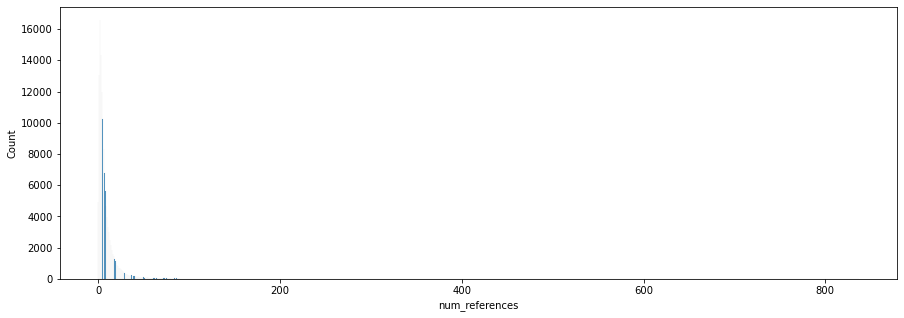

<IPython.core.display.Javascript object>

In [7]:
# Histplot of num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` is highly right skewed.
- We will verify some verifying of links to make sure the pages are for individuals.

In [8]:
# Example of verifying links (repeated in groups of 100 until num_references <100)
df.sort_values(by="num_references", ascending=False)[:10]

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
36579,19,Bill Andress,", 83, American baseball umpire.",https://en.wikipedia.org/wiki/Bill_Andress,837,2008,May,None,None,baseball umpire,None,None,None,None,None,None,None,None,None,83.0,None,United States of America,None,None
11356,14,Frank Sinatra,", 82, American singer , heart attack.",https://en.wikipedia.org/wiki/Frank_Sinatra,660,1998,May,"""My Way"", ""That Life"" and actor Oscar, winner",None,singer,heart attack,None,None,None,None,None,None,None,None,82.0,None,United States of America,None,"""My Way"", ""That Life"" and actor Oscar, 1954 winner"
35265,17,Bobby Fischer,", 64, American chess grandmaster, world champion , kidney failure.",https://en.wikipedia.org/wiki/Bobby_Fischer,631,2008,January,,None,chess grandmaster,world champion,kidney failure,None,None,None,None,None,None,None,64.0,None,United States of America,None,1972 1975
26014,11,Keith Miller,", 84, Australian Test cricketer, Australian rules footballer, fighter pilot and journalist.",https://en.wikipedia.org/wiki/Keith_Miller,586,2004,October,None,None,Test cricketer,rules footballer,fighter pilot and journalist,None,None,None,None,None,None,None,84.0,None,Australia,Australia,None
35003,28,Benazir Bhutto,", 54, Pakistani opposition leader and former prime minister , assassinated.",https://en.wikipedia.org/wiki/Benazir_Bhutto,554,2007,December,",",None,opposition leader and former prime minister,assassinated,None,None,None,None,None,None,None,None,54.0,None,Pakistan,None,"1988 1990, 1993 1996"
85511,25,Fidel Castro,", 90, Cuban politician, Prime Minister .",https://en.wikipedia.org/wiki/Fidel_Castro,531,2016,November,", President",None,politician,Prime Minister,None,None,None,None,None,None,None,None,90.0,None,Cuba,None,"1959 1976, President 1976 2008"
60287,5,Hugo Chávez,", 58, Venezuelan politician and military officer, President , heart attack.",https://en.wikipedia.org/wiki/Hugo_Ch%C3%A1vez,529,2013,March,since,None,politician and military officer,President,heart attack,None,None,None,None,None,None,None,58.0,None,Venezuela,None,since 1999
97905,25,John McCain,", 81, American politician and Navy officer, member of the U.S. Senate , glioblastoma.",https://en.wikipedia.org/wiki/John_McCain,528,2018,August,since and House of Representatives,None,politician and Navy officer,member of the Senate,glioblastoma,None,None,None,None,None,None,None,81.0,None,United States of America,None,since 1987 and House of Representatives 1983 1987
51541,20,Muammar Gaddafi,", 69, Libyan leader , shooting.",https://en.wikipedia.org/wiki/Muammar_Gaddafi,519,2011,October,,None,leader,shooting,None,None,None,None,None,None,None,None,69.0,None,Libya,None,1969 2011
105520,6,Robert Mugabe,", 95, Zimbabwean revolutionary and politician, President , cancer.",https://en.wikipedia.org/wiki/Robert_Mugabe,519,2019,September,and Prime Minister,None,revolutionary and politician,President,cancer,None,None,None,None,None,None,None,95.0,None,Zimbabwe,None,1987 2017 and Prime Minister 1980 1987


<IPython.core.display.Javascript object>

#### Observations:
- Some links point to lists, such as the entry with the maximum `num_references` for Bill Andress.
- Also, there are several entries that point to a list of German World War II medal recipiants.
- We will make a list of these links and change their `num_references` values to 1.

In [9]:
# Creating list of links containing "German" with over 20 references
checklist = [
    index
    for index in df.index
    if "German" in df.loc[index, "info"] and df.loc[index, "num_references"] > 20
]
link_list = df.loc[checklist, "link"].tolist()

<IPython.core.display.Javascript object>

In [10]:
# # Code used to go verify links
# print(link_list.pop())

<IPython.core.display.Javascript object>

#### Changing `num_references` to 1 where Entry Link Points to a List Page

In [11]:
# List of links that point to pages with lists of individuals
link_is_list = [
    "https://en.wikipedia.org/wiki/Bill_Andress",
    "https://en.wikipedia.org/wiki/Joachim_Boosfeld",
    "https://en.wikipedia.org/wiki/Alfred_Eick",
    "https://en.wikipedia.org/wiki/Gerhard_Fischer_(soldier)",
    "https://en.wikipedia.org/wiki/Arthur_B%C3%BCssecke",
    "https://en.wikipedia.org/wiki/Hans-G%C3%BCnther_Lange",
    "https://en.wikipedia.org/wiki/Waldemar_von_Gazen",
    "https://en.wikipedia.org/wiki/Heinz_Angelmaier",
    "https://en.wikipedia.org/wiki/Herbert_Fries",
    "https://en.wikipedia.org/wiki/Friedrich_Carl_(officer)",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Altermann",
    "https://en.wikipedia.org/wiki/Paul_Brasack",
    "https://en.wikipedia.org/wiki/Walther_Gerhold",
    "https://en.wikipedia.org/wiki/Siegfried_Gerstner",
    "https://en.wikipedia.org/wiki/Alois_Schnaubelt",
    "https://en.wikipedia.org/wiki/Karl-Heinz_Wiebe",
    "https://en.wikipedia.org/wiki/Hans-Hermann_Sturm",
    "https://en.wikipedia.org/wiki/Siegfried_Jamrowski",
    "https://en.wikipedia.org/wiki/Franz_Kieslich",
    "https://en.wikipedia.org/wiki/Wilhelm_Lehner",
    "https://en.wikipedia.org/wiki/Fritz_Langanke",
    "https://en.wikipedia.org/wiki/Achim_Wunderlich",
    "https://en.wikipedia.org/wiki/Viktor_Vitali",
    "https://en.wikipedia.org/wiki/Wilhelm_Noller",
    "https://en.wikipedia.org/wiki/Heinrich_Sonne",
    "https://en.wikipedia.org/wiki/Ludwig_Meister",
    "https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer",
    "https://en.wikipedia.org/wiki/Karl_Brommann",
    "https://en.wikipedia.org/wiki/Friedrich_Adrario",
    "https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz",
    "https://en.wikipedia.org/wiki/Hans-Georg_Borck",
    "https://en.wikipedia.org/wiki/Wilhelm_Weidenbr%C3%BCck",
    "https://en.wikipedia.org/wiki/Klaus_Feldt",
    "https://en.wikipedia.org/wiki/Erwin_Bachmann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Bn%E2%80%93Bz)",
    "https://en.wikipedia.org/wiki/List_of_German_supercentenarians#Hermann_Dörnemann",
    "https://en.wikipedia.org/wiki/List_of_Knight%27s_Cross_of_the_Iron_Cross_recipients_(Ba%E2%80%93Bm)",
    "https://en.wikipedia.org/wiki/Family_of_Barack_Obama#Stanley_Armour_Dunham",
    "https://en.wikipedia.org/wiki/Mbah_Gotho",
    "https://en.wikipedia.org/wiki/Thabet_bin_Laden",
]

<IPython.core.display.Javascript object>

In [12]:
# Creating list of row indexes with links that point to lists
rows_to_treat = [index for index in df.index if df.loc[index, "link"] in link_is_list]

# Treating num_references for these entries
df.loc[rows_to_treat, "num_references"] = 1

# Checking a sample of rows
df.loc[rows_to_treat, :].sample(2)

,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy
52003,22,Oskar Schäfer,", 90, German Waffen-SS member.",https://en.wikipedia.org/wiki/Oskar_Sch%C3%A4fer,1,2011,November,None,None,Waffen SS member,None,None,None,None,None,None,None,None,None,90.0,None,Germany,None,None
49670,25,Werner Freiherr von Beschwitz,", 96, German military officer in World War II, Iron Cross recipient.",https://en.wikipedia.org/wiki/Werner_Freiherr_von_Beschwitz,1,2011,May,None,None,military officer in World War II,Iron Cross recipient,None,None,None,None,None,None,None,None,96.0,None,Germany,None,None


<IPython.core.display.Javascript object>

#### Observations:
- With those entries treated, and the other top entries verified, let us take another look at the summary statistics and distribution of `num_references`.

In [13]:
# Summary statistics of updated num_references
df["num_references"].describe()

count    132652.000000
mean          9.734463
std          19.061006
min           0.000000
25%           2.000000
50%           5.000000
75%          10.000000
max         660.000000
Name: num_references, dtype: float64

<IPython.core.display.Javascript object>

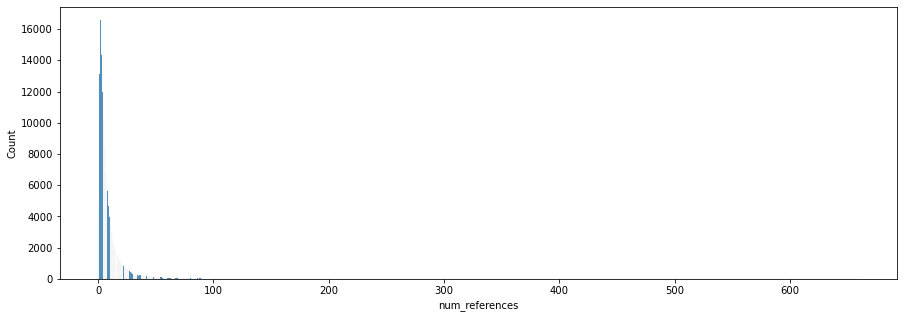

<IPython.core.display.Javascript object>

In [14]:
# Histplot of updated num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="num_references")
plt.show()

#### Observations:
- The distribution of `num_references` remains highly right skewed.
- 25% of entries have 2 or fewer references, which may be a good cutoff to search for `known_for` values.
- Let us view the log transformation of the feature, both for the full dataset, and for `num_references` > 2.

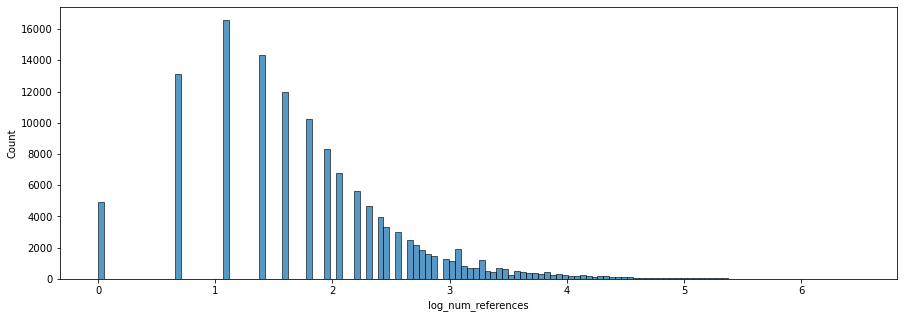

<IPython.core.display.Javascript object>

In [15]:
# Adding column for log_num_references
df["log_num_references"] = df["num_references"].apply(lambda x: np.log(x + 1))

# Histplot of log_num_references
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x="log_num_references")
plt.show()

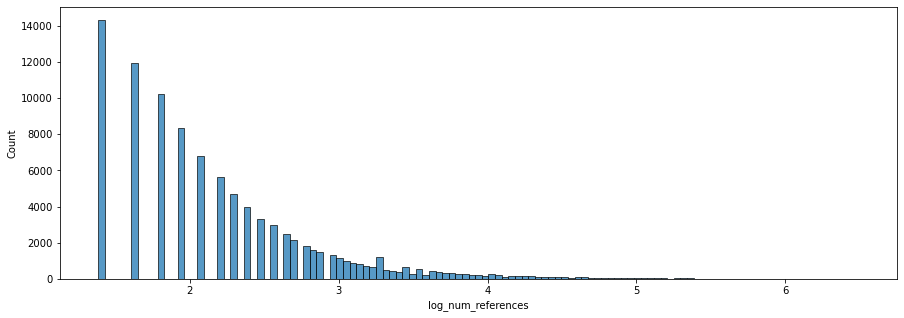

<IPython.core.display.Javascript object>

In [16]:
# Histplot of log_num_references where num_references > 2
plt.figure(figsize=(15, 5))
sns.histplot(data=df[df["num_references"] > 2], x="log_num_references")
plt.show()

#### Observations:
- The distribution is certainly more normalized with the log transformation, but follows a consistent curve for values > 2.
- For this analysis, we will focus on these more noted entries.

## Extracting `known_for` Data
Our goal will be to have some broader categories into which the specific values will fit.  `known_for` is a diverse feature, in that an individual may be known for a long-term role or roles, a specific event, a relationship with another person who is famous, etc.  So, to some extent, we will see what we find and adapt as we go.

Also, we will abandon searching left to right as an individual may fit more than one category, and in no particular order.  For example, Ronald Reagan, is entered as "American actor and politician".  He is most known as the 40th president of The United States, so if we prioritized the first value, he would fit only into the category containing actor.  At the same time, it may have been his acting career that led to his political career.  Both arenas are relevant, so we will aim to capture all categories for an individual.

We will take the following approach:
1. create and check a list of unique values in `info_2_` sub-columns using value_counts, in ascending order.
2. using the pop() method, add each role to it's associated category's list, below, taking care to screen and clarify values that may have multiple meanings, and adding those clarified values to the lists as indicated.
3. combine the lists for each category into one dictionary.
4. Create a corresponding column for each category, initialized equal to 0.
5. search for the values in the dictionary and change the category column to 1 if at least 1 match is found.
6. `cause_of_death` encountered in an `info_2` sub-column will be hard-coded.

#### Restricting our Dataset to Entries with More than 2 References

In [17]:
# Limiting the dataset to entries with > 2 references
df = df[df["num_references"] > 2]
print(f"There are {len(df)} remaining entries in the dataframe.")

There are 98060 remaining entries in the dataframe.


<IPython.core.display.Javascript object>

#### Sub-dividing Numbered `info_` Columns

In [18]:
%%time

# Columns to search
columns = [
    'info_1',
    'info_2',
    'info_3',
    'info_4',
    'info_5',
    'info_6',
    'info_7',
    'info_8',
    'info_9',
    'info_10',
    'info_11'
          ]

# For loop to split column on " and " and separate into respective columns removing leading/trailing white space
for column in columns:
    dataframe = df[df[column].notna()]
    for i in dataframe.index:
        item = dataframe.loc[i, column]
        if item:
            column_lst = item.split(" and ")

            for j in range(len(column_lst)):
                df.loc[i, column + f"_{j}"] = column_lst[j].strip()

# Checking the first 2 rows
df.head(2)

CPU times: total: 12.5 s
Wall time: 12.7 s


,day,name,info,link,num_references,year,month,info_parenth,info_1,info_2,info_3,info_4,info_5,info_6,info_7,info_8,info_9,info_10,info_11,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0
0,1,William Chappell,", 86, British dancer, ballet designer and director.",https://en.wikipedia.org/wiki/William_Chappell_(dancer),21,1994,January,None,None,dancer,ballet designer and director,None,None,None,None,None,None,None,None,86.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,3.091042,NaN,dancer,NaN,NaN,NaN,ballet designer,director,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Raymond Crotty,", 68, Irish economist, writer, and academic.",https://en.wikipedia.org/wiki/Raymond_Crotty,12,1994,January,None,None,economist,writer,and academic,None,None,None,None,None,None,None,68.0,None,Ireland,None,None,2.564949,NaN,economist,NaN,NaN,NaN,writer,NaN,NaN,and academic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Observations:
- With the original numbered `info_` columns further subdivided, we can now drop them.

#### Dropping `info_1` through `info_11` Columns

In [19]:
# Dropping info_1 through info_11 columns
cols_to_drop = [f"info_{i}" for i in range(1, 12)]
df.drop(cols_to_drop, axis=1, inplace=True)

# Checking a sample()
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0
103690,6,Sharon Cather,", 71, American art historian.",https://en.wikipedia.org/wiki/Sharon_Cather,6,2019,June,None,71.0,None,United States of America,None,None,1.94591,NaN,art historian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

#### Finding `known_for` Roles in `info_2_0`

In [20]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [21]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [22]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "sedevacantism" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [23]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [24]:
# # Example code to quick-screen values that may overlap categories
# df.loc[
#     [index for index in df.index if "politician and minister" in df.loc[index, "info"]]
# ]

<IPython.core.display.Javascript object>

In [25]:
# # Example code to quick-check a specific entry
# df[
#     df["info_2_0"]
#     == "politician known for urging crackdown on Tiananmen Square protests of"
# ]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [26]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "politician ; first black woman elected to a provincial legislature",
    "politician who was the first woman elected to the New Senate",
    "politician who served as Leader of the House of Lords",
    "politician who served as the th Premier of Manitoba",
    "politician leader of the People Republic of",
    "politician Lieutenant Governor of Manitoba",
    "politician chairman of the People Party of",
    "politician; former Premier of Nova Scotia",
    "politician involved in Mensalão scandal",
    "Democratic Republic of the politician",
    "Progressive Conservative politician",
    "Republican politician from Maryland",
    "politician of the Republican Party",
    "politician of the Communist Party",
    "Democratic Party Party politician",
    "politician from Southern Illinois",
    "Ulster Unionist Party politician",
    "politician of the National Party",
    "politician MP for Lewisham West",
    "Democratic Maryland politician",
    "politician of the Labour Party",
    "politician Mayor of San Bruno",
    "Sindhi nationalist politician",
    "Conservative Party politician",
    "politician from Massachusetts",
    "Libertarian Party politician",
    "politician from West Belfast",
    "Liberal Democrat politician",
    "Republican Party politician",
    "Virgin Islander politician",
    "Virgin Islands politician",
    "politician Representative",
    "Bougainvillean politician",
    "oldest elected politician",
    "Peronist Party politician",
    "Peronist party politician",
    "communist era politician",
    "revolutionary politician",
    "Conservative politician",
    "Gibraltarian politician",
    "Labour Party politician",
    "Makah tribal politician",
    "politician for minority",
    "conservative politician",
    "Fianna Fáil politician",
    "nationalist politician",
    "transgender politician",
    "Khmer Rouge politician",
    "pro Beijing politician",
    "Democratic politician",
    "Trotskyist politician",
    "Republican politician",
    "Polynesian politician",
    "separatist politician",
    "opposition politician",
    "right wing politician",
    "aboriginal politician",
    "republican politician",
    "Queensland politician",
    "communist politician",
    "Fine Gael politician",
    "far right politician",
    "socialist politician",
    "Papua New politician",
    "Communist politician",
    "Antillean politician",
    "Quebecois politician",
    "politician from Iowa",
    "politician statesman",
    "Prominent politician",
    "Sinn Féin politician",
    "prominent politician",
    "Bissauan politician",
    "Gwich'in politician",
    "Republic politician",
    "unionist politician",
    "Northern politician",
    "Southern politician",
    "colonial politician",
    "Muscogee politician",
    "populist politician",
    "Arabian politician",
    "corrupt politician",
    "Quechua politician",
    "Mahoran politician",
    "Iñupiat politician",
    "Mi'kmaq politician",
    "pan ist politician",
    "federal politician",
    "Liberal politician",
    "Labour politician",
    "tribal politician",
    "exiled politician",
    "Romani politician",
    "Colony politician",
    "Ojibwe politician",
    "Herero politician",
    "senior politician",
    "former politician",
    "Lakota politician",
    "Party politician",
    "local politician",
    "Inuit politician",
    "Māori politician",
    "South politician",
    "Labor politician",
    "and n politician",
    "East politician",
    "politician from",
    "Serb politician",
    "Arab politician",
    "Pima politician",
    "Cree politician",
    "Naga politician",
    "UAE politician",
    "pro politician",
    "ian politician",
    "and politician",
    "politician in",
    "politician TD",
    "ni politician",
    "s politician",
    "politician",
    "tractor driver",
    "plaintiff winner against NASA contractor",
    "economist who examined factor endowment",
    "blacklisted by the House Un Activities Committee",
    "Sestigers",
]

politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "voice actor known for the voice of the cartoon cat Garfield",
    "film actor who normally played Western villains",
    "Golden Bell award winning television actor",
    "plaintiff winner against NASA contractor",
    "actor who portrayed Tarzan in six films",
    "Tony Award winning actor of stage",
    "actor best known as The Master in",
    "actor famous for his alter ego",
    "Academy Award nominated actor",
    "Gibraltarian character actor",
    "Academy Award winning actor",
    "actor who appeared in over",
    "Nandi Award winning actor",
    "Bollywood character actor",
    "actor in gay erotic films",
    "Emmy Award winning actor",
    "actor in adventure films",
    "owner of Factory Records",
    "Tony Award winning actor",
    "actor Emmy Award winning",
    "pornographic film actor",
    "silent film child actor",
    "gay pornographic actor",
    "science fiction actor",
    "Yiddish theatre actor",
    "musical theatre actor",
    "actor on Murphy Brown",
    "musical theater actor",
    "film actor of descent",
    "counter culture actor",
    "Bollywood film actor",
    "Tollywood film actor",
    "BAFTA winning actor",
    "pornographic actor",
    "Hall of Fame actor",
    "Emmy winning actor",
    "former child actor",
    "Tony winning actor",
    "anime voice actor",
    "silent film actor",
    "television actor",
    "xiangsheng actor",
    "actor of theater",
    "theatrical actor",
    "indigenous actor",
    "actor in theatre",
    "voice over actor",
    "character actor",
    "Kathakali actor",
    "Bollywood actor",
    "Yan nhaŋu actor",
    "and film actor",
    "Broadway actor",
    "gay porn actor",
    "actor director",
    "actor in films",
    "actor Judas in",
    "actor of stage",
    "actor comedian",
    "actor of films",
    "theater actor",
    "theatre actor",
    "Kannada actor",
    "comedic actor",
    "comic actor ′",
    "musical actor",
    "comedy actor",
    "kabuki actor",
    "Mohawk actor",
    "Kabuki actor",
    "Igorot actor",
    "actor singer",
    "actor in and",
    "former actor",
    "voice actor",
    "child actor",
    "stage actor",
    "comic actor",
    "radio actor",
    "movie actor",
    "based actor",
    "wuxia actor",
    "film actor",
    "porn actor",
    "Sámi actor",
    "and actor",
    "era actor",
    "Noh actor",
    "n actor",
    "actress Little Eva in the first film adaptation of",
    "actress known for beach party films of s",
    "actress also associated with s art scene",
    "actress in the era of old time radio",
    "Hall of Fame pornographic actress",
    "soap opera actress for Televisa",
    "child actress of the silent era",
    "first female actress of cinema",
    "Oscar winning actress of stage",
    "Academy Award winning actress",
    "child actress in silent films",
    '"Venezuelan" B movie actress',
    "César Award winning actress",
    "Tony Award winning actress",
    "character actress of stage",
    "pornographic film actress",
    "AFI Award winning actress",
    "Broadway theatre actress",
    "actress popular in the s",
    "musical theatre actress",
    "Yiddish theatre actress",
    "silent film era actress",
    "award winning actress",
    "actress with dwarfism",
    "pornographic actress",
    "Hall of Fame actress",
    "silent movie actress",
    "and operetta actress",
    "silent film actress",
    "transsexual actress",
    "transgender actress",
    "television actress",
    "soap opera actress",
    "adult film actress",
    "character actress",
    "Yue opera actress",
    "Bollywood actress",
    "s B movie actress",
    "cult film actress",
    "actress of stage",
    "singer & actress",
    "Broadway actress",
    "theatre actress",
    "theater actress",
    "actress soprano",
    "B movie actress",
    "singer actress",
    "cinema actress",
    "Mohawk actress",
    "comedy actress",
    "voice actress",
    "stage actress",
    "child actress",
    "radio actress",
    "movie actress",
    "comic actress",
    "based actress",
    "Yakut actress",
    "opera actress",
    "dwarf actress",
    "Māori actress",
    "film actress",
    "sage actress",
    "born actress",
    "and actress",
    "actress and",
    "actress in",
    "actress on",
    "s actress",
    "actress",
    "television writer",
    "lead singer songwriter musician of rock band God Lives Underwater",
    "screenwriter who won the Academy Award for Best Story for",
    "writer of all episodes of the long running radio serial",
    "Hall of Fame country music singer songwriter",
    "Hall of Fame blues rock singer songwriter",
    "long time Associated Press cuisine writer",
    "Grammy Award winning singer songwriter",
    "outlaw country music singer songwriter",
    "Hall of Fame country singer songwriter",
    "Emmy winning television comedy writer",
    "Academy Award nominated screenwriter",
    "Emmy Award winning television writer",
    "Hall of Fame science fiction writer",
    "Baseball Hall of Fame sportswriter",
    "writer of more than children books",
    "co writer of the s national anthem",
    "writer who won the Newbery Medal",
    "Emmy nominated television writer",
    "rock singer songwriter",
    "country music singer songwriter",
    "southern soul singer songwriter",
    "comic book writer for DC Comics",
    "Emmy Award winning screenwriter",
    "First Nations singer songwriter",
    "Hall of Fame singer songwriter",
    "music singer songwriter",
    "country folk singer songwriter",
    "Arabian writer of Arab descent",
    "motion picture writer director",
    "writer of children literature",
    "award winning children writer",
    "Pulitzer Prize winning writer",
    "death metal singer songwriter",
    "folk music singer songwriter",
    "honky tonk singer songwriter",
    "folk blues singer songwriter",
    "folk rock singer songwriter",
    "psychedelic rock songwriter",
    "singer songwriter",
    "writer of detective fiction",
    "film director screenwriter",
    "red dirt singer songwriter",
    "juvenile literature writer",
    "country western songwriter",
    "writer of Berserker series",
    "writer under the pseudonym",
    "country singer songwriter",
    "Hall of Fame sportswriter",
    "singer songwriter",
    "animation writer producer",
    "Grammy winning songwriter",
    "television writer for and",
    "country music songwriter",
    "television comedy writer",
    "writer of children books",
    "Gujarati language writer",
    "silent film screenwriter",
    "techno singer songwriter",
    "comic book writer artist",
    "reggae singer songwriter",
    "television screenwriter",
    "blues singer songwriter",
    "Hall of Fame songwriter",
    "writer of short stories",
    "writer of crime fiction",
    "Urdu short story writer",
    "writer editor publisher",
    "R&B musician songwriter",
    "telenovela screenwriter",
    "television scriptwriter",
    'writer also known as ""',
    "Chukchi language writer",
    "science fiction writer",
    "folk singer songwriter",
    "rock singer songwriter",
    "advertising copywriter",
    "speechwriter",
    "soul singer songwriter",
    "born singer songwriter",
    "writer of pulp fiction",
    "writer of the Old West",
    "R&B singer songwriter",
    "insurance underwriter",
    "pop singer songwriter",
    "Oriya language writer",
    "writer of comic books",
    "writer on",
    "rockabilly songwriter",
    "writer of screenplays",
    "folk music songwriter",
    "television writer for",
    "children book writer",
    "crime fiction writer",
    "First Nations writer",
    "mystery novel writer",
    "writer of literature",
    "Urdu language writer",
    "writer",
    "comedy scriptwriter",
    "motorcycling writer",
    "experimental writer",
    "martial arts writer",
    "comedy screenwriter",
    "short story writer",
    "non fiction writer",
    "country songwriter",
    "comic strip writer",
    "anime screenwriter",
    "light novel writer",
    "writer of Westerns",
    "spy fiction writer",
    "singer songwriter",
    "television writer",
    "comic book writer",
    "Motown songwriter",
    "soap opera writer",
    "telenovela writer",
    "writer of descent",
    "writer of stories",
    "writer of fiction",
    "agent for writers",
    "nonfiction writer",
    "screenplay writer",
    "gardening writer",
    "writer of novels",
    "and screenwriter",
    "game show writer",
    "BBC Radio writer",
    "Sestigers writer",
    "fake news writer",
    "editorial writer",
    "writer from Nadu",
    "Braziliam writer",
    "detective writer",
    "writer on",
    "children writer",
    "language writer",
    "thriller writer",
    "Gujarati writer",
    "Canarian writer",
    "Guianese writer",
    "resident writer",
    "writer of drama",
    "cookbook writer",
    "writer of books",
    "head writer for",
    "fiction writer",
    "mystery writer",
    "fashion writer",
    "romance writer",
    "fantasy writer",
    "cookery writer",
    "Vepsian writer",
    "Western writer",
    "Arabian writer",
    "Aranese writer",
    "theatre writer",
    "R&B songwriter",
    "comedy writer",
    "travel writer",
    "comics writer",
    "horror writer",
    "Pueblo writer",
    "Romani writer",
    "Lakota writer",
    "Native writer",
    "sitcom writer",
    "script writer",
    "Jewish writer",
    "screenwriter",
    "scriptwriter",
    "crime writer",
    "music writer",
    "speechwriter",
    "manga writer",
    "comic writer",
    "Poet; writer",
    "based writer",
    "youth writer",
    "anime writer",
    "radio writer",
    "lyric writer",
    "food writer",
    "film writer",
    "jazz writer",
    "folk writer",
    "beat writer",
    "Inuk writer",
    "Beat writer",
    "Cree writer",
    "wine writer",
    "Sami writer",
    "poet writer",
    "songwriter",
    "and writer",
    "copywriter",
    "spy writer",
    "TV writer",
    "writer in",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "Manchester City footballer & Grimsby Town manager",
    "who was oldest living AFL VFL footballer",
    "Olympic bronze medal winning footballer",
    "footballer with Tottenham Hotspur and",
    "professional rugby league footballer",
    "Olympic silver medallist footballer",
    "footballer for West Bromwich Albion",
    "footballer at the Summer Olympics",
    "Olympic international footballer",
    "footballer for Manchester City &",
    "footballer for Hartlepool United",
    "footballer for Birmingham City",
    "World Cup champion footballer",
    "footballer for Stoke City F C",
    "footballer for Feyenoord and",
    "Olympic champion footballer",
    "Hall of Fame VFL footballer",
    "footballer for FC Barcelona",
    "footballer for Real Madrid",
    "rugby union footballer for",
    "Leicester City footballer",
    "footballer for Derry City",
    "international footballer",
    "footballer with Essendon",
    "rugby league footballer",
    "professional footballer",
    "Hall of Fame footballer",
    "Ipswich Town footballer",
    "footballer with one cap",
    "rugby union footballer",
    "association footballer",
    "promising footballer",
    "Olympic footballer[]",
    "World Cup footballer",
    "Olympic footballer",
    "footballer Norwich",
    "Arabian footballer",
    "footballer player",
    "former footballer",
    "rules footballer",
    "rugby footballer",
    "SANFL footballer",
    "WANFL footballer",
    "Serb footballer",
    "WAFL footballer",
    "VFL footballer",
    "footballer for",
    "AFL footballer",
    "era footballer",
    "and footballer",
    "footballer []",
    "footballer[]",
    "s footballer",
    "footballer",
    "football player paralyzed during a game in",
    "football player with the San Francisco ers",
    "Choctaw Chickasaw gridiron football player",
    "football player with the Cleveland Browns",
    "Olympic silver medalist football player",
    "Olympic bronze medalist football player",
    "Heisman Trophy winning football player",
    "football player for Manchester United",
    "Hall of Fame college football player",
    "football player born with no legs",
    "Hall of Fame CFL football player",
    "NFL Hall of Fame football player",
    "and association football player",
    "football player Dallas Cowboys",
    "international football player",
    "Hall of Fame football player",
    "professional football player",
    "rugby league football player",
    "football player of ethnicity",
    "association football player",
    "rugby union football player",
    "university football player",
    "former NFL football player",
    "football playerand a coach",
    "rugby football player for",
    "gridironl footballplayer",
    "gridiron football player",
    "college football player",
    "Olympic football player",
    "former football player",
    "rules football player",
    "arena football player",
    "rugby football player",
    "AAFC football player",
    "VFL football player",
    "CFL football player",
    "and football player",
    "NFL football player",
    "AFL football player",
    "pro football player",
    "NBA football player",
    "football playerer",
    "football player",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "manual typewriter expert",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "haulage contractor",
    "building contractor",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = []
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "known for urging crackdown on Tiananmen Square protests of",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["sedevacantism"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "factory worker",
    "civilian contractor",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "dog actor",
    "lemur actor",
    "canine actor",
    "Kodiak bear actor",
    "scarlet macaw actor",
    "Jack Russell Terrier dog actor",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [27]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Initializing `known_for` Category Columns

In [28]:
# Creating columns for each category
for category in known_for_dict:
    df[category] = 0

# Checking a sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species
10430,10,Mario Santiago Papasquiaro,", 44, Mexican poet, traffic accident.",https://en.wikipedia.org/wiki/Mario_Santiago_Papasquiaro,4,1998,January,None,44.0,None,Mexico,None,None,1.609438,NaN,poet,NaN,NaN,NaN,traffic accident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Extracting Category from `info_2_0` with `known_for_dict`

In [29]:
%%time

# Column to check
column = 'info_2_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 7min 13s
Wall time: 7min 15s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
50163,1,Harold Nelson,", 88, New Zealand Olympic runner.",https://en.wikipedia.org/wiki/Harold_Nelson_(athlete),19,2011,July,None,88.0,None,New Zealand,None,None,2.995732,NaN,Olympic runner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
47156,5,Charles McDowell,", 84, American journalist and syndicated columnist, complications from a stroke.","https://en.wikipedia.org/wiki/Charles_McDowell,_Jr._(journalist)",8,2010,November,None,84.0,None,United States of America,None,None,2.197225,NaN,journalist,syndicated columnist,NaN,NaN,complications from a stroke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [30]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 74899 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [31]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [32]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [33]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "artists' model" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [34]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [35]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "con artist"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [36]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "maverick",
    "Gros Ventre",
    "first President of Senegal;",
    "known for campaigns against fast food chains",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "journalist https: web archive org web http: wcco com local local_story_ htmlurl= |archive date= October }}< ref>",
    "journalist responsible for North Caucasus news on Channel One",
    "journalist who helped return paintings looted by the Nazis",
    "broadcast journalist for NBC News who was news anchor of",
    "photojournalist known for her coverage of the War in",
    "journalist who reported on the Revolution",
    "journalist who worked for from through",
    "journalist who supported democracy",
    "Pulitzer Prize winning journalist",
    "journalist Pulitzer Prize winner",
    "pioneering broadcast journalist",
    "freelance cameraman journalist",
    "journalist for the Daily Mail",
    "photojournalist for magazine",
    "classical music journalist",
    "freelance photo journalist",
    "journalist for Al Jazeera",
    "journalist for al Arabiya",
    "investigative journalist",
    "entertainment journalist",
    "show business journalist",
    "country music journalist",
    "music radio journalist",
    "journalist pamphleteer",
    "television journalist",
    "journalists'",
    "th century journalist",
    "rock music journalist",
    "jazz radio journalist",
    "newspaper journalist",
    "broadcast journalist",
    "freelance journalist",
    "literary journalist",
    "CBS News journalist",
    "photojournalist",
    "fashion journalist",
    "cookery journalist",
    "Balochi journalist",
    "Arabian journalist",
    "online journalist",
    "music journalist",
    "radio journalist",
    "photo journalist",
    "video journalist",
    "photojournalist",
    "film journalist",
    "jazz journalist",
    "arts journalist",
    "wine journalist",
    "East journalist",
    "born journalist",
    "Serb journalist",
    "news journalist",
    "CBS journalist",
    "and journalist",
    "journalist and",
    "journalist of",
    "TV journalist",
    "journalist",
    "mezzo soprano opera singer who sang with the Metropolitan Opera for many years",
    "opera singer best known for her performances with the Sadler Wells company",
    "singer formerly of the Happy Goodman Family",
    'singer known worldwide as the "Queen of Fado"',
    "singer Happy Goodman Family",
    'country music singer: "She Actin\' Single "',
    "lead singer of roots reggae group Culture",
    'Swamp Pop singer of "I\'m a Fool to Care"',
    "singer with The Soul Stirrers",
    "singer with Ladysmith Black Mambazo",
    "Hall of Fame country music singer",
    "lead singer of pop group The Move",
    "accomplished singer composer from",
    "Gwalior gharana classical singer",
    "lead singer of s AOR band Boston",
    "coloratura soprano opera singer",
    "lead singer of The Go Betweens",
    "Jaipur Atrauli gharana singer",
    "lead singer of Molly Hatchet",
    "R&B singer with The Drifters",
    "singer for Guy Lombardo band",
    "concert bass baritone singer",
    "singer known for her work on",
    "Hall of Fame country singer",
    '"New Wave" vallenato singer',
    "former singer for The Clash",
    "Hindustani classical singer",
    "mezzo soprano opera singer",
    "bass baritone opera singer",
    "lead singer of The Sylvers",
    "rock singer for Juggernaut",
    "advisor to Henry Kissinger",
    "mezzo soprano folk singer",
    "coloratura soprano singer",
    "Juno Award winning singer",
    "singer of traditional pop",
    "Ollywood playback singer",
    "Hall of Fame rock singer",
    'tango singer known as ""',
    "recording artist; singer",
    "singer for Shocking Blue",
    "singer with The Spinners",
    "Hall of Fame R&B singer",
    "Rabindra Sangeet singer",
    "singer of Drowning Pool",
    "singer & bass guitarist",
    "traditional pop singer",
    "sevdalinka folk singer",
    "national anthem singer",
    "music singer",
    "lead singer of Freddie",
    "rhythm & blues singer",
    "baritone opera singer",
    "Grammy winning singer",
    "operatic tenor singer",
    "electric blues singer",
    "one hit wonder singer",
    "country music singer",
    "soprano opera singer",
    "operatic bass singer",
    "bass baritone singer",
    "film playback singer",
    "rock 'n' roll singer",
    "Inuktitut pop singer",
    "popular music singer",
    "mezzo soprano singer",
    "Isleño décima singer",
    "Hall of Fame singer",
    "Tuvan throat singer",
    "Mi'kmaq folk singer",
    "bass concert singer",
    "baritone pop singer",
    "flamenco pop singer",
    "thrash metal singer",
    "Nazrul Geeti singer",
    "pop schlager singer",
    "country folk singer",
    "Tejano music singer",
    "traditional singer",
    "heavy metal singer",
    "Hokkien pop singer",
    "death metal singer",
    "rock urbano singer",
    "Nazrul Geet singer",
    "smooth soul singer",
    "Heavy metal singer",
    "lovers rock singer",
    "transsexual singer",
    "rockabilly singer",
    "soul blues singer",
    "sevdalinka singer",
    "music hall singer",
    "campursari singer",
    "space rock singer",
    "turbo folk singer",
    "a cappella singer",
    "bass opera singer",
    "Latin jazz singer",
    "folk music singer",
    "Hindustani singer",
    "folk blues singer",
    "honky tonk singer",
    "classical singer",
    "punk rock singer",
    "bluegrass singer",
    "luk thung singer",
    "folk rock singer",
    "singer guitarist",
    "vallenato singer",
    "luk krung singer",
    "jazz funk singer",
    "Inuktitut singer",
    "pop music singer",
    "singer songwrite",
    "canto pop singer",
    "glam rock singer",
    "soul jazz singer",
    "punk band singer",
    "soul funk singer",
    "playback singer",
    "schlager singer",
    "big band singer",
    "flamenco singer",
    "Carnatic singer",
    "language singer",
    "singer composer",
    "Schlager singer",
    "highlife singer",
    "operatic singer",
    "baritone singer",
    "singer of the s",
    "khananda singer",
    "R&B soul singer",
    "comedian singer",
    "pop rock singer",
    "operetta singer",
    "showband singer",
    "country singer",
    "cabaret singer",
    "popular singer",
    "soprano singer",
    "doo wop singer",
    "Dhrupad singer",
    "qawwali singer",
    "protest singer",
    "Western singer",
    "calypso singer",
    "novelty singer",
    "bachata singer",
    "chanson singer",
    "Qawwali singer",
    "Calypso singer",
    "Kannada singer",
    "back up singer",
    "ryūkōka singer",
    "reggae singer",
    "bolero singer",
    "ghazal singer",
    "cumbia singer",
    "Tejano singer",
    "Chaabi singer",
    "Romani singer",
    "bhajan singer",
    "Chalga singer",
    "thumri singer",
    "huayno singer",
    "backup singer",
    "mugham singer",
    "Oneida singer",
    "Yaghan singer",
    "anthem singer",
    "shaabi singer",
    "Taarab singer",
    "Berber singer",
    "Hutsul singer",
    "opera singer",
    "blues singer",
    "salsa singer",
    "tango singer",
    "banda singer",
    "samba singer",
    "Tatar singer",
    "Mbira singer",
    "rumba singer",
    "forró singer",
    "tenor singer",
    "morna singer",
    "s pop singer",
    "Choro singer",
    "druze singer",
    "Opera singer",
    "copla singer",
    "folk singer",
    "jazz singer",
    "soul singer",
    "rock singer",
    "fado singer",
    "punk singer",
    "waka singer",
    "band singer",
    "singer poet",
    "funk singer",
    "bass singer",
    "enka singer",
    "Baul singer",
    "pop singer",
    "R&B singer",
    "folksinger",
    "raï singer",
    "singer",
    'author whose story "The Wisdom of Eve" inspired the film',
    "Newbery Medal winning author of children books",
    "author under the pseudonym of John Godey",
    "author & syndicated newspaper columnist",
    "author of cookbooks on Southern cuisine",
    "Sahitya Akademi Award winning author",
    "National Book Award winning author",
    "author of science fiction novellas",
    "author of Chicka Chicka Boom Boom",
    "author of",
    "author of books including novels",
    "author of lesbian themed works",
    "author of children literature",
    "Pulitzer Prize winning author",
    "author of books",
    "speculative fantasy author",
    "Nobel Prize winning author",
    "author of",
    "author of children books",
    "author of mystery novels",
    "language children author",
    "Third Generation author",
    "autobiographical author",
    "science fiction author",
    "children’s book author",
    "kosher cookbook author",
    "Lovelock Paiute author",
    "author of pulp fiction",
    "author children books",
    "author on the",
    "author of gay erotica",
    "children book author",
    "nouveau roman author",
    "crime fiction author",
    "author of spy novels",
    "author of thrillers",
    "etiquette authority",
    "author & biographer",
    "young adult author",
    "gastronomic author",
    "spy fiction author",
    "author of cookbook",
    "comic book author",
    "true crime author",
    "Inuvialuit author",
    "author of fantasy",
    "author of fiction",
    "Sephardic author",
    "author of novels",
    "children author",
    "cookbook author",
    "Gujarati author",
    "author of plays",
    "language author",
    "culinary author",
    "fantasy author",
    "mystery author",
    "Occitan author",
    "Tlingit author",
    "romance author",
    "South n author",
    "western author",
    "graphic author",
    "author of food",
    "horror author",
    "Jewish author",
    "comics author",
    "sci fi author",
    "Native author",
    "manga author",
    "crime author",
    "pagan author",
    "co author of",
    "Urdu author",
    "UFO author",
    "also a world renowned poet",
    "poet who wrote about the Dust Bowl",
    "Pulitzer Prize winning poet",
    "poet of the Beat Generation",
    "Kannada language poet",
    "Occitan language poet",
    "Beat generation poet",
    "Beat Generation poet",
    "prize winning poet",
    "poet of the School",
    "experimental poet",
    "K'iche' Maya poet",
    "Ulster Scots poet",
    "contemporary poet",
    "Martiniquan poet",
    "avant garde poet",
    "surrealist poet",
    "vernacular poet",
    "Nuyorican poet",
    "Kashubian poet",
    "language poet",
    "Movement poet",
    "poet laureate",
    "Kannada poet",
    "Arabian poet",
    "Chicano poet",
    "Mi'kmaq poet",
    "Native poet",
    "Mormon poet",
    "Baháʼí poet",
    "ghazal poet",
    "rhythm poet",
    "singer poet",
    "Latino poet",
    "Pashto poet",
    "Druze poet",
    "Māori poet",
    "Urdu poet",
    "Beat poet",
    "beat poet",
    "Odia poet",
    "and poet",
    "dub poet",
    "poetess",
    "n poet",
    "poets",
    "poet",
    "based graffiti artist whose works were included in the Venice Biennale",
    "choreographer appointed as Sydney Dance Company artistic director",
    "artist known for his role in the Conceptualism",
    "textile artist who specialized in embroidery",
    "Academy Award winning visual effects artist",
    "artist who was a member of the Regina Five",
    "internationally recognized graphic artist",
    "visual artist known for her still lives",
    "internationally exhibited Navajo artist",
    "rock concert graphic poster artist",
    "stateless auto destructive artist",
    "avant garde installation artist",
    "figurative expressionist artist",
    "Hall of Fame comic book artist",
    "special effects make up artist",
    "abstract expressionist artist",
    "Golden Age comic book artist",
    "Oscar winning make up artist",
    "underground graffiti artist",
    "animation background artist",
    "motion picture matte artist",
    "film special effects artist",
    "contemporary visual artist",
    "experimental visual artist",
    "wet folding origami artist",
    "underground comics artist",
    "psychedelic poster artist",
    "sound installation artist",
    "experimental music artist",
    "video game concept artist",
    "television make up artist",
    "nomadic lifestyle artist",
    "recording artist; singer",
    "electronic music artist",
    "courtroom sketch artist",
    "dancehall reggae artist",
    "rock album cover artist",
    "Les Automatistes artist",
    "drag queen music artist",
    "special effects artist",
    "science fiction artist",
    "comic book artist born",
    "visual effects artist",
    "color abstract artist",
    "graphic design artist",
    "fantasy gaming artist",
    "musical Thavil artist",
    "neo conceptual artist",
    "fantasy coffin artist",
    "stained glass artist",
    "nonconformist artist",
    "environmental artist",
    "expressionist artist",
    "First Nations artist",
    "impressionist artist",
    "monumentalist artist",
    "horticultural artist",
    "n artist from Utopia",
    "country music artist",
    "artistic draughtsman",
    "neo mannerist artist",
    "contemporary artist",
    "installation artist",
    "World War II artist",
    "Peking opera artist",
    "artist photographer",
    "contemperary artist",
    "music artist",
    "Papunya Tula artist",
    "wood carving artist",
    "film make up artist",
    "Muay martial artist",
    "movie poster artist",
    "film concept artist",
    "performance artist",
    "comic strip artist",
    "avant garde artist",
    "film poster artist",
    "hand shadow artist",
    "watercolour artist",
    "lianhuanhua artist",
    "motorsports artist",
    "multi media artist",
    "psychedelic artist",
    "New Realist artist",
    "and graphic artist",
    "transgender artist",
    "shadow play artist",
    "comic book artist",
    "conceptual artist",
    "artistic director",
    "voice over artist",
    "figurative artist",
    "watercolor artist",
    "minimalist artist",
    "commercial artist",
    "indigenous artist",
    "surrealist artist",
    "Indigenous artist",
    "multimedia artist",
    "Yakshagana artist",
    "aboriginal artist",
    "West Coast artist",
    "artist of origins",
    "storyboard artist",
    "landscape artist",
    "artistic gymnast",
    "Kathakali artist",
    "botanical artist",
    "recording artist",
    "highwire artiste",
    "modernist artist",
    "harmonism artist",
    "newspaper artist",
    "Eurodance artist",
    "geometric artist",
    "animation artist",
    "based pop artist",
    "courtroom artist",
    "artist of origin",
    "abstract artist",
    "wildlife artist",
    "graffiti artist",
    "outsider artist",
    "portrait artist",
    "ceramics artist",
    "forensic artist",
    "heraldic artist",
    "computer artist",
    "hologram artist",
    "theatre artiste",
    "martial artist",
    "graphic artist",
    "textile artist",
    "ceramic artist",
    "make up artist",
    "pottery artist",
    "artists' model",
    "fantasy artist",
    "concept artist",
    "plastic artist",
    "hip hop artist",
    "cabaret artist",
    "kinetic artist",
    "dubbing artist",
    "weaving artist",
    "Iñupiat artist",
    "Western artist",
    "artist in wood",
    "trapeze artist",
    "theatre artist",
    "comedic artist",
    "carving artist",
    "Chicano artist",
    "woodcut artist",
    "thangka artist",
    "visual artist",
    "comics artist",
    "makeup artist",
    "street artist",
    "tattoo artist",
    "circus artist",
    "Ojibwe artist",
    "poster artist",
    "reggae artist",
    "enamel artist",
    "marine artist",
    "fetish artist",
    "pencil artist",
    "manhua artist",
    "equine artist",
    "native artist",
    "sketch artist",
    "modern artist",
    "Native artist",
    "Navajo artist",
    "design artist",
    "manga artist",
    "glass artist",
    "comic artist",
    "video artist",
    "voice artist",
    "Inuit artist",
    "fiber artist",
    "sound artist",
    "quilt artist",
    "Kiowa artist",
    "media artist",
    "batik artist",
    "pixel artist",
    "Kunqu artist",
    "blues artist",
    "mural artist",
    "artist model",
    "Route artist",
    "naïve artist",
    "strip artist",
    "movie artist",
    "folk artist",
    "mime artist",
    "Inuk artist",
    "drag artist",
    "land artist",
    "sand artist",
    "born artist",
    "fine artist",
    "rock artist",
    "game artist",
    "pop artist",
    "war artist",
    "rap artist",
    "R&B artist",
    "ink artist",
    "and artist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "baseball player who was second oldest living major league player",
    "baseball player who hit the first grand slam in the Mets history",
    "baseball player in the All Girls Professional Baseball League",
    "Hall of Fame baseball player for the Nishitetsu Lions",
    "baseball player with the Cleveland Indians",
    "Collegiate Hall of Fame baseball player",
    "Negro leagues baseball player",
    "Hall of Fame baseball player",
    "Negro league baseball player",
    "professional baseball player",
    "minor league baseball player",
    "one armed baseball player",
    "Baseball baseball player",
    "Republic baseball player",
    "Olympic baseball player",
    "AAGPBL baseball player",
    "former baseball player",
    "MLB baseball player",
    "All baseball player",
    "baseball player",
    "Olympic taekwondo martial artist",
    "artistic gymnastics coach",
    "Olympic artistic gymnast",
    "mixed martial artist",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = []
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "contractor",
    "businessman responsible for marketing the hula hoop",
    "businessman who founded Taylor Woodrow",
    "businessman who founded Pottery Barn",
    "businessman co founder of the River",
    "equine pharmaceutical businessman",
    "businessman oil company executive",
    "descent millionaire businessman",
    "businessman",
    "Arabian cosmetics businessman",
    "food production businessman",
    "agricultural businessman",
    "Gibraltarian businessman",
    "billionaire businessman",
    "real estate businessman",
    "millionaire businessman",
    "automotive businessman",
    "transport businessman",
    "emerald businessman",
    "grocery businessman",
    "Arabian businessman",
    "retail businessman",
    "Born businessman",
    "cork businessman",
    "n businessman",
    "businessman",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "authority on black people in the ancient world",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Latter day Saints general authority",
    "general authority of the LDS Church",
    "LDS Church general authority",
    "general authority LDS Church",
    "Mormon general authority",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["and\xa0philanthropist"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["implicated in the murder of Daniel Pearl", "scam artist", "con artist"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = []
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [37]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [38]:
%%time

# Column to check
column = 'info_2_0'

# Start dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in known_for_dict.items():
    for role in category_lst:
        for index in dataframe.index:
                item = df.loc[index, column]
                if item:
                    if role in item:
                        df.loc[index, category] = 1
                        df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 8min 18s
Wall time: 8min 20s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
4327,13,Frank Silva,", 44, American set dresser and actor, AIDS-related complications.",https://en.wikipedia.org/wiki/Frank_Silva,6,1995,September,None,44.0,None,United States of America,None,None,1.945910,NaN,set dresser,actor,NaN,NaN,AIDS related complications,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
27173,24,Mercedes Pardo,", 83, Venezuelan painter.",https://en.wikipedia.org/wiki/Mercedes_Pardo,9,2005,March,None,83.0,None,Venezuela,None,None,2.302585,NaN,painter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [39]:
#### Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 65621 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [40]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [41]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [42]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "comedian" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [43]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [44]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "ice skating comedian"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [45]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "prosecuting lawyer who was the first attorney in the to achieve a murder conviction with exclusively circumstantial evidence",
    "lawyer who fought for equitable access to legal services",
    "lawyer who co founded the National Lawyers Guild",
    "lawyer who defended pacifist Ezra Pound",
    "lawyer at the Department of Justice",
    "defense lawyer for Saddam Hussein",
    "lawyer who defended dissidents",
    "intellectual property lawyer",
    "lawyer for the Grateful Dead",
    "lawyer for left wing clients",
    "lawyer civil rights activist",
    "divorce lawyer to the stars",
    "lawyer political advisor",
    "criminal defense lawyer",
    "anti segregation lawyer",
    "First Amendment lawyer",
    "public interest lawyer",
    "constitutional lawyer",
    "animal welfare lawyer",
    "entertainment lawyer",
    "environmental lawyer",
    "civil rights lawyer",
    "human rights lawyer",
    "Gibraltarian lawyer",
    "immigration lawyer",
    "LGBT rights lawyer",
    "arbitration lawyer",
    "bankruptcy lawyer",
    "corporate lawyer",
    "jailhouse lawyer",
    "academic lawyer",
    "criminal lawyer",
    "defense lawyer",
    "trial lawyer",
    "labor lawyer",
    "South lawyer",
    "Māori lawyer",
    "libel lawyer",
    "pro lawyer",
    "tax lawyer",
    "lawyer",
    "diplomat with the Department of State",
    "Chickasaw Nation diplomat",
    "diplomatand ambassador",
    "diplomat Ambassador to",
    "first female diplomat",
    "government diplomat",
    "diplomat serving in",
    "communist diplomat",
    "diplomatic clerk",
    "career diplomat",
    "era diplomat",
    "diplomat to",
    "diplomat",
    "AIDS policy coordinator",
    "economist who did pioneering research in linear",
    "economist specializing in public economics",
    "Nobel Prize winning economist",
    "agricultural economist",
    "development economist",
    "libertarian economist",
    "political economist",
    "feminist economist",
    "Gandhian economist",
    "monetary economist",
    "Marxian economist",
    "Marxist economist",
    "health economist",
    "labor economist",
    "macroeconomist",
    "and economist",
    "Virgin Islander jurist",
    "federal jurist",
    "jurist",
    "senior judge of the District Court for the Southern District of Alabama",
    "federal judge who crafted the mass settlement of asbestos lawsuits",
    "judge of the District Court for the Western District of Missouri",
    "former chief judge of the Court of Appeals for the Third Circuit",
    "senior judge of the District Court for the Southern District of",
    "Superior Court judge who presided over the Charles Manson trial",
    "senior judge of the District Court for the Eastern District of",
    "circuit judge for the Court of Appeals for the Ninth Circuit",
    "senior judge of the Court of Appeals for the Ninth Circuit",
    "senior judge of the District Court for the District of New",
    "senior judge of the Family Division of the High Court",
    "district judge overseeing desegregation in the South",
    "judge on the Court of Appeals for the Third Circuit",
    "who was the first female Supreme Court judge",
    "senior judge for the Central District Court",
    "judge on the Supreme Court of Queensland",
    "prominent judge sitting in highest court",
    "judge on the Oregon Supreme Court",
    "judge of the High Court of and",
    "senior federal appellate judge",
    "judge of the ACT Supreme Court",
    "and Ohio judge for years",
    "City family court judge",
    "Bankruptcy Court judge",
    "Virgin Islander judge",
    "first female judge of",
    "district court judge",
    "senior federal judge",
    "senior circuit judge",
    "District Court judge",
    "Supreme Court judge",
    "appeals court judge",
    "former chief judge",
    "High Court judge",
    "district judge",
    "federal judge",
    "circuit judge",
    "senior judge",
    "judge in the",
    "Navajo judge",
    "state judge",
    "chief judge",
    "State judge",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "actor",
    "artist",
    "n artist",
    "geometric abstractionist painter",
    "abstract expressionist painter",
    "representational painter",
    "magic realist painter",
    "expressionist painter",
    "impressionist painter",
    "photorealist painter",
    "surrealistic painter",
    "avant garde painter",
    "watercolour painter",
    "color field painter",
    "Puerto Ricanpainter",
    "and realist painter",
    "mixed media painter",
    "surrealist painter",
    "figurative painter",
    "watercolor painter",
    "Andalusian painter",
    "aboriginal painter",
    "television painter",
    "landscape painter",
    "modernist painter",
    "Madhubani painter",
    "painter of themes",
    "cityscape painter",
    "Delftware painter",
    "abstract painter",
    "portrait painter",
    "folk art painter",
    "realist painter",
    "outback painter",
    "Realist painter",
    "Yolngu painter",
    "Coptic painter",
    "Cubist painter",
    "Native painter",
    "Ojibwe painter",
    "COBRA painter",
    "naïve painter",
    "icon painter",
    "born painter",
    "barn painter",
    "Yōga painter",
    "and painter",
    "signpainter",
    "painter of",
    "painter",
    "composer of Catholic liturgical songs",
    "Academy Award winning film score composer",
    "composer of contemporary classical music",
    "composer best known for work on Robotech",
    "composer of classic film music such as",
    "contemporary classical music composer",
    "composer of background music for and",
    "Academy Award winning film composer",
    "Pulitzer Prize winning composer",
    "contemporary classical composer",
    "composer prolific in film music",
    "composer of Broadway musicals",
    "composer of classical music",
    "Tony Award winning composer",
    "Emmy award winning composer",
    "experimental music composer",
    "electronic music composer",
    "video game music composer",
    "television score composer",
    "classical guitar composer",
    "composer of feature films",
    "classical music composer",
    "musical theater composer",
    "composer of film scores",
    "composer of orchestral",
    "country music composer",
    "experimental composer",
    "music composer",
    "jazz pianist composer",
    "avant garde composer",
    "composer of musicals",
    "film score composer",
    "film music composer",
    "television composer",
    "microtonal composer",
    "soundtrack composer",
    "video game composer",
    "theme song composer",
    "rockabilly composer",
    "classical composer",
    "Aromanian composer",
    "Cantopop composer",
    "composer of music",
    "musician composer",
    "Broadway composer",
    "musical composer",
    "composer of film",
    "hip hop composer",
    "migrant composer",
    "jingle composer",
    "music composer",
    "opera composer",
    "tango composer",
    "Filin composer",
    "Māori composer",
    "film composer",
    "jazz composer",
    "and composer",
    "composer",
    "musician who played at the Johannesburg Live concert",
    "musician with the hardcore punk band Big Boys",
    "musician known for his work with the Beatles",
    "musician known for his work on the theme",
    "musician credited with creating mambo",
    "musician for acoustic rock band Plush",
    'jazz musician known as "Mr Swing"',
    'musician known as "Saint Thomas"',
    "Hall of Fame bluegrass musician",
    "Grammy Award winning musician",
    "Grammy award winning musician",
    "award winning blues musician",
    "musician with the Bothy Band",
    "Hall of Fame blues musician",
    "reggae cross over musician",
    "Country & Western musician",
    "electronic dance musician",
    "traditional jazz musician",
    "dancehall garage musician",
    "electric blues musician",
    "Nazrul Sangeet musician",
    "big band style musician",
    "dixieland jazz musician",
    "Chicago blues musician",
    "Igbo highlife musician",
    "Andean cumbia musician",
    "Detroit blues musician",
    "Creole zydeco musician",
    "country blues musician",
    "Hall of Fame musician",
    "experimental musician",
    "contra dance musician",
    "rock 'n roll musician",
    "kadongo kamu musician",
    "traditional musician",
    "synthesizer musician",
    "avant garde musician",
    "garage punk musician",
    "jazz fusion musician",
    "heavy metal musician",
    "electronic musician",
    "rockabilly musician",
    "Indigenous musician",
    "minimalist musician",
    "bossa nova musician",
    "acid house musician",
    "Hindustani musician",
    "blues rock musician",
    "vocal jazz musician",
    "Volksmusik musician",
    "Rockabilly musician",
    "bluegrass musician",
    "classical musician",
    "folk rock musician",
    "punk rock musician",
    "dancehall musician",
    "vallenato musician",
    "surf rock musician",
    "Classical musician",
    "steel pan musician",
    "highlife musician",
    "mariachi musician",
    "big band musician",
    "steelpan musician",
    "musician activist",
    "outsider musician",
    "Steelpan musician",
    "military musician",
    "musician composer",
    "and rock musician",
    "children musician",
    "musician of music",
    "Indorock musician",
    "country musician",
    "hip hop musician",
    "shehnai musician",
    "session musician",
    "ambient musician",
    "calypso musician",
    "skiffle musician",
    "reggae musician",
    "gospel musician",
    "cumbia musician",
    "kwaito musician",
    "Tejano musician",
    "Jibaro musician",
    "Celtic musician",
    "Native musician",
    "street musician",
    "Reggae musician",
    "Romani musician",
    "blues musician",
    "polka musician",
    "Cajun musician",
    "tango musician",
    "roots musician",
    "salsa musician",
    "Māori musician",
    "khyal musician",
    "samba musician",
    "Tuvan musician",
    "mbira musician",
    "grime musician",
    "ashik musician",
    "benga musician",
    "Gnawa musician",
    "cajun musician",
    "Benga musician",
    "jazz musician",
    "rock musician",
    "folk musician",
    "soul musician",
    "punk musician",
    "Bubu musician",
    "Jùjú musician",
    "soca musician",
    "musician from",
    "R&B musician",
    "pop musician",
    "ska musician",
    "oud musician",
    "rap musician",
    "musician",
    "Academy Award winning film director",
    "Bodil Award winning film director",
    "gay pornographic film director",
    "horror film director of the s",
    "pornographic film director",
    "documentary film director",
    "independent film director",
    "Bollywood film director",
    "film director producer",
    "B movie film director",
    "film director for MGM",
    "adult film director",
    "short film director",
    "and film director",
    "era film director",
    "art film director",
    "film director in",
    "n film director",
    "film director",
    "landscape architect",
    "medieval architectural",
    "architectural lighting designer",
    "Southwestern style architect",
    "architectural photographer",
    "architectural",
    "architecture critic for",
    "horticultural architect",
    "architecture",
    "architecture",
    "architectural critic",
    "landscape architect",
    "modernist architect",
    "architecture critic",
    "architect in Oregon",
    "temple architect",
    "bridge architect",
    "church architect",
    "naval architect",
    "based architect",
    "and architect",
    "architectural",
    "architecture",
    "novelist who wrote a book shortlisted for the Booker Prize in",
    "novelist whose books were popular in the s",
    "Booker Prize winning novelist",
    "novelist under pseudonyms",
    "science fiction novelist",
    "experimental novelist",
    "young adult novelist",
    "adventure novelist",
    "romantic novelist",
    "children novelist",
    "adaption novelist",
    "fantasy novelist",
    "romance novelist",
    "mystery novelist",
    "Western novelist",
    "giallo novelist",
    "horror novelist",
    "crime novelist",
    "wuxia novelist",
    "Nisei novelist",
    "spy novelist",
    "n novelist",
    "novelist",
    'photographer who pioneered "environmental portraiture"',
    "photographer of the",
    "photographer during",
    "photographer of indigenous peoples in",
    "Pulitzer Prize winning photographer",
    "photographer based in San Francisco",
    "photographer at the fall of Saigon",
    "underwater nature photographer",
    "photographer born in Mérida",
    "architectural photographer",
    "Laguna Pueblo photographer",
    "documentary photographer",
    "advertising photographer",
    "photographer of children",
    "commercial photographer",
    "underwater photographer",
    "wilderness photographer",
    "celebrity photographer",
    "newspaper photographer",
    "wildlife photographer",
    "fine art photographer",
    "portrait photographer",
    "fashion photographer",
    "glamour photographer",
    "aerial photographer",
    "street photographer",
    "erotic photographer",
    "adult photographer",
    "press photographer",
    "crime photographer",
    "jazz photographer",
    "news photographer",
    "art photographer",
    "photographer",
    "abstract expressionist sculptor",
    "surrealist sculptor",
    "monumental sculptor",
    "minimalist sculptor",
    "modernist sculptor",
    "abstract sculptor",
    "portrait sculptor",
    "kinetic sculptor",
    "ceramic sculptor",
    "Apache sculptor",
    "figure sculptor",
    "steel sculptor",
    "folk sculptor",
    "sculptor",
    'comedian dubbed "Uncle Miltie"',
    "comedian respiratory problems",
    "Oneida Mohawk Cree comedian",
    "improvisational comedian",
    "Wiere Brothers comedian",
    "Grammy winning comedian",
    "Borscht Belt comedian",
    "ice skating comedian",
    "xiangsheng comedian",
    "stand up comedian",
    "radio comedian",
    "East comedian",
    "film comedian",
    "comedian",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "oldest living test cricketer for",
    "former international cricketer",
    "international test cricketer",
    "and Yorkshire cricketer",
    "cricketer for Glamorgan",
    "international cricketer",
    "professional cricketer",
    "Hall of Fame cricketer",
    "first class cricketer",
    "national cricketer",
    "test cricketer for",
    "Test cricketer",
    "test cricketer",
    "West cricketer",
    "cricketer for",
    "cricketer",
    "college basketball player for the University of",
    "Olympic silver medal winning basketball player",
    "Olympic bronze medal winning basketball player",
    "All basketball player for the Oklahoma Sooners",
    "basketball player for Arabian Al Ittihad team",
    "Olympic gold medal winning basketball player",
    "gold medal winning Olympic basketball player",
    "Collegiate Hall of Fame basketball player",
    "basketball player with the Boston Celtics",
    "Olympic gold medallist basketball player",
    "Hall of Fame Olympic basketball player",
    "Olympic champion basketball player",
    "basketball player of Seton Hall",
    "Atlanta Hawks basketball player",
    "Hall of Fame basketball player",
    "professional basketball player",
    "wheelchair basketball player",
    "All Star basketball player",
    "Spaniard basketball player",
    "Olympic basketball player",
    "college basketball player",
    "women basketball player",
    "and basketball player",
    "NBA basketball player",
    "basketball player",
    "dog show judge",
    "boxing judge",
    'professional wrestler best known as "Hercules Hernandez" or simply just "Hercules"',
    "professional wrestler of the s s famous for feuds with Buddy Rogers",
    "professional wrestler for the World Wrestling Federation",
    "professional wrestler during the Great Depression era",
    'professional wrestler best known as "Moondog King"',
    'professional wrestler known as "The Black Shadow"',
    'professional wrestler known as "Biff Wellington"',
    "professional wrestler known as liver transplant",
    "former World Wrestling Entertainment wrestler",
    "wrestler who competed in the Summer Olympics",
    'professional wrestler known as "The Crusher"',
    "professional wrestler known as",
    "Olympic silver medal winning wrestler",
    "World Championship Wrestling wrestler",
    "wrestler; patriarch of Hart wrestling",
    "Olympic gold medal winning wrestler",
    "Olympic medalist freestyle wrestler",
    "Hall of Fame professional wrestler",
    "freestyle wrestler of Avar descent",
    "lucha libre professional wrestler",
    "Olympic silver medallist wrestler",
    "Olympic silver medalist wrestler",
    "light heavyweight Greco wrestler",
    "professional wrestler of descent",
    "professional wrestler known as",
    "heavyweight freestyle wrestler",
    "female professional wrestler",
    "featherweight Greco wrestler",
    "women professional wrestler",
    "four time Olympic wrestler",
    "Olympic champion wrestler",
    "WWE professional wrestler",
    "Olympic Greco wrestler",
    "EstonianGreco wrestler",
    "professional wrestler",
    "professional\xa0wrestler",
    "Hall of Fame wrestler",
    "lucha libre wrestler",
    "traditional wrestler",
    "heavyweight wrestler",
    "freestyle wrestler",
    "wrestler known as",
    "Olympic wrestler",
    "midget wrestler",
    "female wrestler",
    "masked wrestler",
    "Greco wrestler",
    "sambo wrestler",
    "sumo wrestler",
    "pro wrestler",
    "WWF wrestler",
    "wrestler",
    "ice hockey goaltending coach for Winter Olympics gold medal team",
    "Olympic gold medal winning field hockey player",
    "Olympic bronze medallist field hockey player",
    "Olympic silver medallist ice hockey player",
    "Olympic silver medalist ice hockey player",
    "Olympic bronze medalist ice hockey player",
    "Detroit Red Wings hockey player in the s",
    "Olympic silver medallist in ice hockey",
    "Olympic champion field hockey player",
    "Olympic champion ice hockey player",
    "professional ice hockey defenseman",
    "Hall of Fame field hockey player",
    "Hall of Fame ice hockey linesman",
    "Hall of Fame ice hockey player",
    "professional ice hockey player",
    "ice hockey Hall of Fame player",
    "Olympic field hockey player",
    "field hockey representative",
    "professional hockey player",
    "ice hockey general manager",
    "Olympic ice hockey player",
    "college ice hockey player",
    "ice hockey administrator",
    "college ice hockey coach",
    "NHL ice hockey referee",
    "Olympic hockey player",
    "ice hockey goaltender",
    "ice hockey defenceman",
    "and ice hockey player",
    "ice hockey executive",
    "roller hockey player",
    "national hockey team",
    "sledge hockey player",
    "field hockey player",
    "ice hockey referee",
    "ice hockey trainer",
    "ice hockey player",
    "ice hockey coach",
    "hockey official",
    "hockey referee",
    "hockey player",
    "field hockey",
    "ice hockey",
    "hockey",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "mathematician & cosmologist; co advocate of the Steady State theory",
    "mathematician known for his contribution to graph theory",
    "mathematician specialising in group theory",
    "mathematician at the University of Chicago",
    "mathematician of ancestry",
    "and later mathematician",
    "applied mathematician",
    "amateur mathematician",
    "pure mathematician",
    "born mathematician",
    "and mathematician",
    "mathematician",
    "nuclear physicist who worked at the Manhattan Project Metallurgical Laboratory",
    "physicist who was a pioneer of solid state physics",
    "physicist who co discovered the Wigner Seitz cell",
    "physicist who won the Nobel Prize for Physics in",
    'physicist known as "the father of Pulsed Power"',
    "physicist specialized in theoretical catalysis",
    'physicist who coined the term "black hole"',
    "physicist Nobel Prize in Physics laureate",
    "leading physicist in the study of waves",
    "physicist known for the Casimir effect",
    "physicist who built the first laser",
    "Nobel Prize winning biophysicist",
    "physicist at Uppsala University",
    "experimental nuclear physicist",
    "Nobel Prize winning physicist",
    "condensed matter physicist",
    "and theoretical physicist",
    "mathematical geophysicist",
    "oceanographic physicist",
    "astroparticle physicist",
    "pioneering biophysicist",
    "computational physicist",
    "mathematical physicist",
    "experimental physicist",
    "molecular biophysicist",
    "physicist ane engineer",
    "theoretical physicist",
    "accelerator physicist",
    "atmospheric physicist",
    "solid state physicist",
    "mesoscopic physicist",
    "particle physicist",
    "chemical physicist",
    "research physicist",
    "nuclear physicist",
    "medical physicist",
    "thermal physicist",
    "climate physicist",
    "optical physicist",
    "plasma physicist",
    "atomic physicist",
    "health physicist",
    "space physicist",
    "metal physicist",
    "solar physicist",
    "astrophysicist",
    "neurophysicist",
    "East physicist",
    "and physicist",
    "geophysicist",
    "biophysicist",
    "physicist",
    "computer architect",
    "attending physician to President John F Kennedy after his assassination",
    "physician known for alternative cancer treatments",
    "physician who delivered first test tube baby",
    "family health physician",
    "public health physician",
    "respiratory physician",
    "consultant physician",
    "transplant physician",
    "orthopedic physician",
    "Ayurvedic physician",
    "aerospace physician",
    "ayurvedic physician",
    "tropical physician",
    "research physician",
    "chief physician",
    "physician",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = []
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "historian known for her studies of",
    "historian during World War II",
    "historian specialized on history",
    "Pulitzer Prize winning historian",
    "historian of southern Nevada",
    "Crow tribal nation historian",
    "historian of Mongol studies",
    "historian of indigenous",
    "historian of the Illyrians",
    "historian of the Holocaust",
    "Jewish Holocaust historian",
    "historian of early modern",
    "Wright brothers historian",
    "historian of the Southern",
    "historian of the Zulu War",
    "historian of colonialism",
    "historian of the Empire",
    "historian of modern age",
    "intellectual historian",
    "early modern historian",
    "contemporary historian",
    "revisionist historian",
    "philosophy historian",
    "historian of Eastern",
    "Holocaust historian",
    "historian of Nazism",
    "transport historian",
    "literary historian",
    "medieval historian",
    "cultural historian",
    "oriental historian",
    "linguist historian",
    "historian of Latin",
    "clothing historian",
    "Quebecer historian",
    "culinary historian",
    "ancient historian",
    "railway historian",
    "Romanov historian",
    "Babylon historian",
    "social historian",
    "Jewish historian",
    "Lakota historian",
    "postal historian",
    "historian of the",
    "tribal historian",
    "Quaker historian",
    "urban historian",
    "food historian",
    "idea historian",
    "Crow historian",
    "gay historian",
    "prehistorian",
    "historian of",
    "n historian",
    "historian",
    "anthropologist who founded the academic journal",
    "Three Affiliated Tribes academic",
    "Blackfoot academic administrator",
    "academic administrator",
    "Māori language academic",
    "academic administrator",
    "fat studies academic",
    "academic philosopher",
    "ans academic",
    "literature acadeic",
    "Opaskwayak academic",
    "university academic",
    "academic of descent",
    "academic professor",
    "literary academic",
    "academic director",
    "grammar academic",
    "academic leader",
    "Creole academic",
    "Druze academic",
    "academician",
    "academic",
    "home economist",
    "existentialist philosopher",
    "New Confucian philosopher",
    "philosopher of",
    "postmodernist philosopher",
    "philosopher of",
    "philosopher of language",
    "educational philosopher",
    "philosopher of",
    "analytic philosopher",
    "idealist philosopher",
    "academic philosopher",
    "social philosopher",
    "moral philosopher",
    "North philosopher",
    "East philosopher",
    "and philosopher",
    "philosopher",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "military officer of World War I",
    "and later military officer",
    "Air Force military officer",
    "CIA paramilitary officer",
    "Karen military officer",
    "WWII military officer",
    "military officer",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "general authority of The Church of Jesus Christ of Latter day Saints",
    "of the Latter Day Saint movement",
    "Syro Malabar Catholic prelate",
    "clandestine Catholic prelate",
    "defrocked Catholic prelate",
    "Patriotic Catholic prelate",
    "Maronite Catholic prelate",
    "Eastern Catholic prelate",
    "Coptic Catholic prelate",
    "Old Catholic prelate",
    "Catholic prelate",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["stalker of musician Björk", "involved in point shaving scandal", "defrocked"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "involved in Bob Knight controversy",
    "involved in quiz show scandals",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [46]:
# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ruth_Siems"].index
df.loc[index, "info_2_0"] = "inventor"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [47]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [48]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 9min 12s
Wall time: 9min 13s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
128695,6,Bob Falkenburg,", 95, American Hall of Fame tennis player and businessman, founder of Bob's.",https://en.wikipedia.org/wiki/Bob_Falkenburg,24,2022,January,None,95.0,None,United States of America,None,None,3.218876,NaN,Hall of Fame tennis player,businessman,NaN,NaN,founder of Bob,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
95125,30,Michael Tree,", 84, American violist.",https://en.wikipedia.org/wiki/Michael_Tree,4,2018,March,None,84.0,None,United States of America,None,None,1.609438,NaN,violist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [49]:
#### Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 44405 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [50]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [51]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [52]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "anthropologist" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [53]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [54]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "physical anthropologist"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [55]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "economist",
    "judge",
    "AIDS educator",
    "sex educator",
    "and political scientist",
    "political scientist",
    "Channel Islander civil servant",
    "civil servant from Providence",
    "international civil servant",
    "colonial civil servant",
    "civil servant",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "architect",
    "Academy Award winning sound engineer",
    "Grammy award winning music engineer",
    "Grammy Award winning sound engineer",
    "film sound engineer",
    "film recording engineer",
    "recording engineer",
    "music engineer",
    "sound engineer",
    "Academy Award nominated playwright",
    "Pulitzer Prize winning playwright",
    "Assiniboine playwright",
    "radio playwright",
    "playwright",
    'cartoonist Known for the biplane flying overhead trailing a banner that read "mild',
    "cartoonist who created the comic book",
    "Pulitzer Prize winning cartoonist",
    "cartoonist for The New Yorker",
    "underground comix cartoonist",
    "World War II cartoonist",
    "underground cartoonist",
    "comic strip cartoonist",
    "editorial cartoonist",
    "newspaper cartoonist",
    "animation cartoonist",
    "manga cartoonist",
    "and cartoonist",
    "cartoonist",
    "pornographic film producer",
    "independent film producer",
    "documentary film producer",
    "Bollywood film producer",
    "animated film producer",
    "horror film producer",
    "LGBT film producer",
    "film producer",
    "jazz pianist who played with Benny Goodman",
    "Jewish pianist portrayed in the film",
    "Hall of Fame country pianist",
    "Hall of Fame blues pianist",
    "Moravian classical pianist",
    "pianist for Frank Sinatra",
    "swing era jazz pianist",
    "electric blues pianist",
    "post bop jazz pianist",
    "popular music pianist",
    "boogie woogie pianist",
    "Hall of Fame pianist",
    "music pianist",
    "bebop jazz pianist",
    "classical pianist",
    "free jazz pianist",
    "born jazz pianist",
    "jazz funk pianist",
    "concert pianist",
    "ragtime pianist",
    "new age pianist",
    "blues pianist",
    "tango pianist",
    "jazz pianist",
    "cafe pianist",
    "rock pianist",
    "R&B pianist",
    "pianist",
    "Grammy Award winning conductor",
    "conductor of classical music",
    "symphony orchestra conductor",
    "conductor of popular music",
    "concert band conductor",
    "orchestral conductor",
    "orchestra conductor",
    "classical conductor",
    "symphony conductor",
    "musical conductor",
    "choral conductor",
    "opera conductor",
    "choir conductor",
    "music conductor",
    "jazz conductor",
    "guitarist for the heavy metal band Great White; victim of the Station nightclub fire",
    "bass guitarist for the punk band The Dead Milkmen",
    "rock guitarist who founded The Replacements",
    "blues guitarist who influenced Otis Redding",
    "guitarist with The Marshall Tucker Band",
    "guitarist who played with Frank Sinatra",
    "free improvising avant garde guitarist",
    "guitarist from rock outfit Rose Tattoo",
    "guitarist for the Cosmic Psychos",
    "Hall of Fame bluegrass guitarist",
    "rhythm guitarist for Body Count",
    "Hall of Fame blues guitarist",
    "guitarist of rock band Ratt",
    "electric blues guitarist",
    "Piedmont blues guitarist",
    "piedmont blues guitarist",
    "Chicago blues guitarist",
    "guitarist for Madrugada",
    "country music guitarist",
    "Hall of Fame guitarist",
    "bass guitarist for EMF",
    "pedal steel guitarist",
    "heavy metal guitarist",
    "death metal guitarist",
    "Head Charge guitarist",
    "rockabilly guitarist",
    "Gypsy jazz guitarist",
    "blues rock guitarist",
    "classical guitarist",
    "bluegrass guitarist",
    "slack key guitarist",
    "rock bass guitarist",
    "primitive guitarist",
    "post punk guitarist",
    "punk rock guitarist",
    "Lap steel guitarist",
    "flamenco guitarist",
    "country guitarist",
    "session guitarist",
    "reggae guitarist",
    "rhythm guitarist",
    "studio guitarist",
    "blues guitarist",
    "steel guitarist",
    "metal guitarist",
    "roots guitarist",
    "jazz guitarist",
    "bass guitarist",
    "rock guitarist",
    "folk guitarist",
    "lead guitarist",
    "soul guitarist",
    "guitarist",
    "principal dancer with the Alvin Ailey Dance Theater",
    "Emmy Award winning jazz dancer",
    "contact improvisation dancer",
    "classical ballet dancer",
    "vaudeville tap dancer",
    "expressionist dancer",
    "Bharatanatyam dancer",
    "based ballet dancer",
    "Cotton Club dancer",
    "transgender dancer",
    "ballet dancer and",
    "Polynesian dancer",
    "television dancer",
    "classical dancer",
    "Kathakali dancer",
    "burlesque dancer",
    "Kuchipudi dancer",
    "lindy hop dancer",
    "principal dancer",
    "acrobatic dancer",
    "ballroom dancer",
    "flamenco dancer",
    "flatfoot dancer",
    "oriental dancer",
    "Balinese dancer",
    "topless dancer",
    "ballet dancer",
    "modern dancer",
    "Kathak dancer",
    "exotic dancer",
    "Odissi dancer",
    "belly dancer",
    "tango dancer",
    "butoh dancer",
    "dwarf dancer",
    "hula dancer",
    "folk dancer",
    "tap dancer",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "Hall of Fame rugby league player",
    "international rugby union player",
    "Hall of Fame rugby union player",
    "rugby league player for Great",
    "rugby league player for Wigan",
    "All Blacks rugby union player",
    "former rugby union player for",
    "Papua New rugby league player",
    "rugby league administrator",
    "international rugby player",
    "Lions rugby league captain",
    "rugby union administrator",
    "wheelchair rugby player",
    "rugby union commentator",
    "rugby union player for",
    "rugby union executive",
    "rugby league referee",
    "rugby player for and",
    "rugby league player",
    "rugby union referee",
    "rugby union captain",
    "rugby union player",
    "rugby league coach",
    "rugby union winger",
    "rugby union coach",
    "rugby commentator",
    "rugby union lock",
    "rugby executive",
    "rugby player",
    "rugby league",
    "rugby union",
    "rugbyplayer",
    "rugby coach",
    "boxer who won the Empire super featherweight title",
    "former WBC world light welterweight champion boxer",
    "former world super featherweight champion boxer",
    "former world light welterweight champion boxer",
    "born former Empire heavyweight champion boxer",
    "former NBA world bantamweight champion boxer",
    "former WBC light welterweight champion boxer",
    "Olympic silver medalist lightweight boxer",
    "world light middleweight champion boxer",
    "former NABF lightweight champion boxer",
    "former WBC heavyweight champion boxer",
    "NABF super lightweight champion boxer",
    "former WBA heavyweight champion boxer",
    "Hall of Fame light heavyweight boxer",
    "champion professional boxer in the s",
    "former triple world champion boxer",
    "Olympic bronze medal winning boxer",
    "Olympic silver medal winning boxer",
    "former lightweight champion boxer",
    "Olympic gold medal winning boxer",
    "Hall of Fame featherweight boxer",
    "bodyguard for boxer Kostya Tszyu",
    "Olympic light heavyweight boxer",
    "featherweight lightweight boxer",
    "fly bantam featherweight boxer",
    "Olympic silver medalist boxer",
    "WBA flyweight champion boxer",
    "bantamweight champion boxer",
    "Olympic middleweight boxer",
    "heavyweight champion boxer",
    "Olympic bantamweight boxer",
    "dual world champion boxer",
    "Olympic heavyweight boxer",
    "light middleweight boxer",
    "light welterweight boxer",
    "light heavyweight boxer",
    "Olympic flyweight boxer",
    "Olympic medalist boxer",
    "heavyweight kickboxer",
    "world champion boxer",
    "featherweight boxer",
    "cruiserweight boxer",
    "Virgin Island boxer",
    "Golden Gloves boxer",
    "professional boxer",
    "Hall of Fame boxer",
    "welterweight boxer",
    "bantamweight boxer",
    "middleweight boxer",
    "heavyweight boxer",
    "lightweight boxer",
    "unlicensed boxer",
    "Olympic boxer []",
    "flyweight boxer",
    "champion boxer",
    "Muay kickboxer",
    "Olympic boxer",
    "amateur boxer",
    "Serb boxer",
    "kickboxer",
    "beatboxer",
    "and boxer",
    "era boxer",
    "boxer",
    "three time Super Bowl winning football coach of the San Francisco ers",
    "football coach at Amherst College for years",
    "National Football League football coach",
    "Northwestern University football coach",
    "head football coach at Ithaca College",
    "football coach for Indiana University",
    "Hall of Fame college football coach",
    "former national football coach",
    "Hall of Fame football coach",
    "high school football coach",
    "association football coach",
    "football coach of West y",
    "gridiron football coach",
    "college football coach",
    "East football coach",
    "football coach",
    "record setting harness racing driver",
    "Hall of Fame harness racing driver",
    "former Grand Prix racing driver",
    "Hall of Fame racing driver",
    "Indianapolis racing driver",
    "professional racing driver",
    "Formula One racing driver",
    "sprint car racing driver",
    "Grand Prix racing driver",
    "open wheel racing driver",
    "stock car racing driver",
    "off road racing driver",
    "racing driver champion",
    "amateur racing driver",
    "motor racing driver",
    "auto racing driver",
    "drag racing driver",
    "VLN racing driver",
    "racing driver",
    "Male international table tennis player",
    "Paralympic wheelchair tennis player",
    "Hall of Fame women tennis promoter",
    "wheelchair table tennis player",
    "Hall of Fame tennis executive",
    "Olympic table tennis player",
    "table tennis world champion",
    "Hall of Fame tennis player",
    "Female tennis player from",
    "wheelchair tennis player",
    "collegiate tennis coach",
    "tennis player in the s",
    "female tennis player",
    "table tennis player",
    "tennis commentator",
    "tennis champion",
    "tennis player",
    "table tennis",
    "tennis coach",
    "tennis agent",
    "tennis",
    "ice dancer",
    "darts administrator",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "industrial chemist best known for his work on polymers",
    "chemist known for his work on the Manhattan Project",
    "scientist in the field of electrochemistry",
    "physical chemist at AT&T Bell Laboratories",
    "Nobel Prize winner in chemistry",
    "of organic chemistry",
    "Nobel Prize winning biochemist",
    "Nobel Prize winning chemist",
    "synthetic organic chemist",
    "of biochemistry",
    "underground LSD chemist",
    "natural product chemist",
    "neuroscience biochemist",
    "of chemistry",
    "pharmaceutical chemist",
    "environmental chemist",
    "theoretical chemist",
    "chemistry",
    "biophysical chemist",
    "Southern biochemist",
    "atmospheric chemist",
    "analytical chemist",
    "biological chemist",
    "South wine chemist",
    "chemistry lecturer",
    "inorganic chemist",
    "physical chemist",
    "research chemist",
    "chemistry doctor",
    "Congress chemist",
    "organic chemist",
    "nuclear chemist",
    "polymer chemist",
    "textile chemist",
    "protein chemist",
    "quantum chemist",
    "electrochemist",
    "native chemist",
    "soil chemist",
    "food chemist",
    "neurochemist",
    "biochemist",
    "geochemist",
    "chemistry",
    "chemist",
    "aeronautical engineer who invented the tandem rotor placement in helicopter design",
    "rocket engineer who worked at the Jet Propulsion Laboratory",
    "chemical engineer for the Procter & Gamble company",
    'engineer nicknamed the "Father of the Corvette "',
    "engineer in charge during the Chernobyl disaster",
    "chemical engineer in unleaded gasoline",
    "of electrical engineering",
    "of aerospace engineering",
    "engineering construction executive",
    "communication satellites engineer",
    "mechanical engineering",
    "Electrical engineering",
    "Hall of Fame computer engineer",
    "biomedical engineering pioneer",
    "electronics engineer for Sony",
    "aircraft automotive engineer",
    "pioneering computer engineer",
    "telecommunications engineer",
    "civil engineering",
    "consulting nuclear engineer",
    "integrated circuit engineer",
    "bridge structural engineer",
    "naval electronics engineer",
    "computer hardware engineer",
    "videogame console engineer",
    "nuclear material engineer",
    "audio mastering engineer",
    "control systems engineer",
    "of engineering",
    "engineering seismologist",
    "engineering psychologist",
    "plant breeding engineer",
    "aeroelasticity engineer",
    "soil mechanics engineer",
    "optoelectronic engineer",
    "transportation engineer",
    "railway signal engineer",
    "environmental engineer",
    "metallurgical engineer",
    "refrigeration engineer",
    "computational engineer",
    "aeronautical engineer",
    "agricultural engineer",
    "engineering scientist",
    "engineering",
    "ice drilling engineer",
    "electronics engineer",
    "biochemical engineer",
    "aeronautics engineer",
    "electrical engineer",
    "mechanical engineer",
    "automotive engineer",
    "structural engineer",
    "industrial engineer",
    "acoustical engineer",
    "irrigation engineer",
    "motorcycle engineer",
    "biomedical engineer",
    "electronic engineer",
    "explosives engineer",
    "earthquake engineer",
    "spacecraft engineer",
    "motorsport engineer",
    "consulting engineer",
    "car design engineer",
    "video game engineer",
    "aerospace engineer",
    "hydraulic engineer",
    "petroleum engineer",
    "satellite engineer",
    "financial engineer",
    "materials engineer",
    "broadcast engineer",
    "executive engineer",
    "chemical engineer",
    "computer engineer",
    "software engineer",
    "aviation engineer",
    "aircraft engineer",
    "ice road engineer",
    "nuclear engineer",
    "traffic engineer",
    "systems engineer",
    "thermal engineer",
    "railway engineer",
    "optical engineer",
    "ceramic engineer",
    "welding engineer",
    "mining engineer",
    "design engineer",
    "rocket engineer",
    "camera engineer",
    "Toyota engineer",
    "diving engineer",
    "civil engineer",
    "audio engineer",
    "paper engineer",
    "NASA engineer",
    "auto engineer",
    "rail engineer",
    "and engineer",
    "bioengineer",
    "scientist whose pioneering measurements showed a carbon dioxide buildup in the earth atmosphere",
    "computer scientist who led the IBM team that developed Fortran",
    "pioneering scientist in the field of human consciousness",
    "scientist whose work helped develop prion theory",
    "scientist credited with inventing the wetsuit",
    "scientist in the field of electrochemistry",
    "scientist who co founded the Club of Rome",
    "computer scientist at Rice University",
    "Hall of Fame computer scientist",
    "environmental health scientist",
    "interdisciplanarily scientist",
    "computational neuroscientist",
    "computer scientist from UCSD",
    "Manhattan Project scientist",
    "medical research scientist",
    "missile control scientist",
    "cancer research scientist",
    "behavioral neuroscientist",
    "pharmaceutical scientist",
    "cognitive neuroscientist",
    "environmental scientist",
    "horticultural scientist",
    "communication scientist",
    "agricultural scientist",
    "aeronautical scientist",
    "conservation scientist",
    "high voltage scientist",
    "biomaterials scientist",
    "Ostforschung scientist",
    "IBM computer scientist",
    "Tatar rocket scientist",
    "information scientist",
    "atmospheric scientist",
    "engineering scientist",
    "veterinary scientist",
    "biomedical scientist",
    "materials scientist",
    "planetary scientist",
    "cognitive scientist",
    "fisheries scientist",
    "molecular scientist",
    "nutrition scientist",
    "stem cell scientist",
    "computer scientist",
    "research scientist",
    "material scientist",
    "wildlife scientist",
    "cultural scientist",
    "nuclear scientist",
    "medical scientist",
    "climate scientist",
    "social scientist",
    "rocket scientist",
    "marine scientist",
    "animal scientist",
    "forest scientist",
    "space scientist",
    "polar scientist",
    "neuro scientist",
    "radio scientist",
    "earth scientist",
    "plant scientist",
    "neuroscientist",
    "food scientist",
    "soil scientist",
    "rice scientist",
    "and scientist",
    "geoscientist",
    "environmental sociologist",
    "sociologist",
    "sociologist",
    "sociologist",
    "sociologist of science",
    "sociologist",
    "sociologist",
    "medical sociologist",
    "sociologist",
    "urban sociologist",
    "sociologist",
    "psychologist known for his pioneering work in autism treatment",
    "psychologist renowned for his critical studies of hypnosis",
    "psychologist who specialized in developmental psychology",
    "child development psychologist",
    "psychologist family therapist",
    "organizational psychologist",
    "developmental psychologist",
    "environmental psychologist",
    "psychologist at University",
    "experimental psychologist",
    "mathematical psychologist",
    "correctional psychologist",
    "evolutionary psychologist",
    "engineering psychologist",
    "development psychologist",
    "existential psychologist",
    "behavioral psychologist",
    "cognitive psychologist",
    "pediatric psychologist",
    "clinical psychologist",
    "traffic psychologist",
    "systems psychologist",
    "Jungian psychologist",
    "social psychologist",
    "child psychologist",
    "neuropsychologist",
    "parapsychologist",
    "and psychologist",
    "psychologist",
    "pioneer in the semiconductor industry",
    "neuro linguistic programming expert",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "ATM entrepreneur",
    "billionaire mining entrepreneur",
    "cocktail bar entrepreneur",
    "real estate entrepreneur",
    "financial entrepreneur",
    "marketing entrepreneur",
    "mini golf entrepreneur",
    "entrepreneur in Darwin",
    "internet entrepreneur",
    "property entrepreneur",
    "Arabian entrepreneur",
    "tourism entrepreneur",
    "serial entrepreneur",
    "travel entrepreneur",
    "timber entrepreneur",
    "wine entrepreneur",
    "entrepreneur",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "authority on",
    "Native educator",
    "university educator",
    "Inuit educator",
    "adult educator",
    "archaeologist specializing in Etruscan civilization",
    "archaeologist at the University of Sheffield",
    "archaeologist of sites in Anatolia",
    "archaeologist at the University of",
    "Middle Eastern archaeologist",
    "underwater archaeologist",
    "historical archaeologist",
    "classical archaeologist",
    "landscape archaeologist",
    "Meso archaeologist",
    "zooarchaeologist",
    "archaeologist",
    "linguist specialized in Romance languages",
    "linguistic anthropologist",
    "linguistics professor",
    "historical linguist",
    "linguist of descent",
    "linguistics scholar",
    "linguistics expert",
    "classical linguist",
    "Santhali linguist",
    "language linguist",
    "Yiddish linguist",
    "Creole linguist",
    "anthropologist specializing in Aztec culture",
    "social anthropologist ands ethnographer",
    "indigenous Hopi anthropologist",
    "culinary anthropologist griot",
    "linguistic anthropologist",
    "cultural anthropologist",
    "social anthropologist",
    "palaeoanthropologist",
    "paleoanthropologist",
    "anthropologist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "ship engineer",
    "Army soldier awarded the Medal of Honor during World War II",
    "Army World War II soldier who received the Medal of Honor",
    "World War II soldier portrayed by Donnie Wahlberg in",
    "Army soldier who was killed by the Taliban in istan",
    "SAS soldier involved in the Embassy Siege",
    "Army soldier during World War II",
    "World War II Waffen SS soldier",
    "soldier during World War II",
    "soldier serving in the War",
    "Nagorno Karabakh soldier",
    "soldier during the War",
    "Army infantry soldier",
    "World War II soldier",
    "soldier in the Army",
    "World War I soldier",
    "volunteer soldier",
    "Navy SEAL soldier",
    "combat soldier",
    "Gurkha soldier",
    "Danzig soldier",
    "child soldier",
    "Army soldier",
    "WWII soldier",
    "army soldier",
    "soldier",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = []
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["involved in match fixing scandal"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "civil engineer taken hostage in",
    "wrongfully convicted of murder",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [56]:
# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Seth_Firkins"].index
df.loc[index, "info_2_0"] = "sound engineer"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ben_Elliott"].index
df.loc[index, "info_2_0"] = "sound engineer"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Bruce_Swedien"].index
df.loc[index, "info_2_0"] = "sound engineer"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Elliot_Mazer"].index
df.loc[index, "info_2_0"] = "sound engineer"

# Dropping entry with link that points to daughter's page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Lola_Wasserstein"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Hard-coding cause_of_death value for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ty_Longley"].index
df.loc[index, "cause_of_death"] = "nightclub fire"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [57]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [58]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 7min 8s
Wall time: 7min 9s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
18387,4,Hunter Hancock,", 88, American R&B and rock DJ.",https://en.wikipedia.org/wiki/Hunter_Hancock,5,2004,August,None,88.0,None,United States of America,None,None,1.791759,NaN,R&B,rock DJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
22594,30,Mitzi Cunliffe,", 88, American sculptor.",https://en.wikipedia.org/wiki/Mitzi_Cunliffe,6,2006,December,None,88.0,None,United States of America,None,None,1.945910,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [59]:
#### Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 35719 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [60]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [61]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [62]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "fashion" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [63]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [64]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "fashion"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [65]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Communist Party labor activist",
    "former Ku Klux Klan member turned civil rights activist",
    "anti abortion activist;",
    "human rights activist in the fields of gay women",
    "Western Shoshone indigenous rights activist",
    "International Solidarity Movement activist",
    "Nisqually tribal fishing rights activist",
    "Congresswoman; women rights activist",
    "turned political activist",
    "New activist for West independence",
    "Papua New anti corruption activist",
    "anti communist political activist",
    "human rights activist in Chechnya",
    "Illinois anti corruption activist",
    "childhood immunizations activist",
    "medical cannabis rights activist",
    "Indigenous women rights activist",
    "anti role playing games activist",
    "conservative political activist",
    "Equal Rights Amendment activist",
    "independence activist for West",
    "independence movement activist",
    "nationalist political activist",
    "anti nuclear weapons activist",
    "republican political activist",
    "activist for assisted suicide",
    "comfort women rights activist",
    "children television activist",
    "reproductive health activist",
    "reproductive rights activist",
    "Revisionist Zionist activist",
    "left wing political activist",
    "anti death penalty activist",
    "transgender rights activist",
    "Kashmir separatism activist",
    "white civil rights activist",
    "anti nuclear power activist",
    "disability rights activist",
    "indigenous rights activist",
    "UNDP human rights activist",
    "language movement activist",
    "pro establishment activist",
    "anti White Terror activist",
    "Indigenous social activist",
    "Anishinaabe water activist",
    "sex worker rights activist",
    "activist for independence",
    "assisted suicide activist",
    "Hawaii sovereign activist",
    "and anti nuclear activist",
    "anti immigration activist",
    "activist for human rights",
    "exiled political activist",
    "political activist",
    "gay rights legal activist",
    "consumer rights activist",
    "abortion rights activist",
    "Hindu political activist",
    "workers' rights activist",
    "children rights activist",
    "white supremacy activist",
    "anti government activist",
    "anti psychiatry activist",
    "bisexual rights activist",
    "disabled rights activist",
    "civil liberties activist",
    "anti apartheid activist",
    "social justice activist",
    "anti communist activist",
    "anti Communist activist",
    "sexual freedom activist",
    "Māori language activist",
    "housing rights activist",
    "anti Apartheid activist",
    "anti polygraph activist",
    "justice reform activist",
    "life extension activist",
    "East political activist",
    "welfare rights activist",
    "Catholic peace activist",
    "environmental activist",
    "animal rights activist",
    "anti abortion activist",
    "mental health activist",
    "Native rights activist",
    "pro democracy activist",
    "pro communist activist",
    "victim rights activist",
    "extreme right activist",
    "desegregation activist",
    "native rights activist",
    "Kwakwaka'wakw activist",
    "anti colonial activist",
    "Navajo Nation activist",
    "Neo political activist",
    "labour rights activist",
    "birth control activist",
    "native people activist",
    "civil rights activist",
    "human rights activist",
    "women rights activist",
    "independence activist",
    "anti nuclear activist",
    "anti smoking activist",
    "anti poverty activist",
    "right to die activist",
    "conservative activist",
    "anti logging activist",
    "anti tobacco activist",
    "Ogala Lakota activist",
    "Raja freedom activist",
    "Civil Rights activist",
    "women health activist",
    "anti fascist activist",
    "prostitution activist",
    "conservation activist",
    "Māori rights activist",
    "LGBT rights activist",
    "transgender activist",
    "nationalist activist",
    "Sikh rights activist",
    "drug policy activist",
    "labor union activist",
    "land rights activist",
    "civil right activist",
    "gay rights activist",
    "indigenous activist",
    "aboriginal activist",
    "vegetarian activist",
    "neofascist activist",
    "anti Mafia activist",
    "Trotskyist activist",
    "Indigenous activist",
    "pro choice activist",
    "republican activist",
    "political activist",
    "community activist",
    "communist activist",
    "socialist activist",
    "democracy activist",
    "religious activist",
    "anti drug activist",
    "Burkinabè activist",
    "Winnebago activist",
    "Communist activist",
    "far right activist",
    "feminist activist",
    "language activist",
    "pro life activist",
    "HIV AIDS activist",
    "loyalist activist",
    "homeless activist",
    "anti war activist",
    "anti War activist",
    "humanist activist",
    "equality activist",
    "cannabis activist",
    "Zainichi activist",
    "Native s activist",
    "anti gun activist",
    "student activist",
    "antiwar activist",
    "Chicano activist",
    "Zionist activist",
    "cycling activist",
    "zionist activist",
    "POW MIA activist",
    "lesbian activist",
    "social activist",
    "rights activist",
    "health activist",
    "Jewish activist",
    "cancer activist",
    "albino activist",
    "Navajo activist",
    "Maoist activist",
    "Native activist",
    "peace activist",
    "labor activist",
    "Hindu activist",
    "Māori activist",
    "Tatar activist",
    "LGBTQ activist",
    "media activist",
    "'AIDS activist",
    "Sioux activist",
    "civic activist",
    "NAACP activist",
    "Dalit activist",
    "women activist",
    "urban activist",
    "LGBT activist",
    "AIDS activist",
    "food activist",
    "BDSM activist",
    "HIV activist",
    "Pan activist",
    "JDL activist",
    "gay activist",
    "general secretary of the National Union of",
    "Governor general of the",
    "attorney general",
    "first female major party candidate to run for Governor of North Carolina",
    "presidential candidate for the Alliance for Democracy party",
    "Democratic Party member of the House of Representatives",
    "who trained Martin Luther King Jr",
    "assistant secretary of the Department of Commerce",
    "leader of the Islamic Renaissance Party of istan",
    "first female chair of Michigan Republican Party",
    "Secretary of Treasury from under Jimmy Carter",
    "Press Secretary for President Jimmy Carter",
    "political leader of the Communist Party of",
    "Green Party member of the House of Lords",
    "leader of the Progressive Unionist Party",
    "Principal Speaker of Green Party of",
    "chairman of the Communist Party of",
    "leader of the Black Panther Party",
    "leader of Beijing Communist Party",
    "threatened by McCarthyism",
    "member of the Bonaparte dynasty",
    "Conservative Party chairman",
    "Black Panther Party member",
    "anti apartheid campaigner",
    "part of Watergate",
    "State Department official",
    "Communist party secretary",
    "Republican party official",
    "anti apartheid activist",
    "anti Apartheid activist",
    "Party student leader",
    "The anti apartheid",
    "Yukon Party Leader",
    "Labour Party MP",
    "anti apartheid",
    "party official",
    "art heiress",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "author",
    "conductor",
    "film musical arranger musical orchestrator",
    "National Film Award winning filmmaker",
    "counterculture experimental filmmaker",
    "BBC Northern broadcaster & filmmaker",
    "music director for Bollywood films",
    "underwater documentary filmmaker",
    "documentary filmmaker",
    "ʼNamgis documentary filmmaker",
    "music documentary filmmaker",
    "independent film executive",
    "of film studies",
    "Oscar winning film editor",
    "film production designer",
    "film marketing publicist",
    "producer of horror films",
    "film television producer",
    "film industry executive",
    "Emmy Award winning film",
    "Tony Award winning film",
    "documentary film editor",
    "experimental filmmaker",
    "documentary film maker",
    "pornographic filmmaker",
    "film critic for on ABC",
    "independent film maker",
    "documentary filmmaker",
    "film studio executive",
    "advertising filmmaker",
    "avant garde filmmaker",
    "independent filmmaker",
    "filmmaker",
    "film costume designer",
    "film archive pioneer",
    "film camera operator",
    "surrealist filmmaker",
    "film music director",
    "film location scout",
    "Bollywood filmmaker",
    "wildlife film maker",
    "film stunt director",
    "film choreographer",
    "film prop designer",
    "wildlife filmmaker",
    "film documentarian",
    "film art director",
    "film set designer",
    "director for film",
    "Olympic filmmaker",
    "film distributor",
    "adult film star",
    "South filmmaker",
    "film programmer",
    "film maker",
    "film executive",
    "film trumpeter",
    "film animator",
    "film lyricist",
    "film restorer",
    "film reviewer",
    "Arabian film",
    "film editor",
    "film critic",
    "film maker",
    "based film",
    "filmmaker",
    "film star",
    "and film",
    "filmgoer",
    "dancer",
    "porn star",
    "counter culture activist",
    "general manager of the Metropolitan Opera",
    "last living member of the Carter Family country music group",
    "abstract expressionist art collector",
    "widow of Wal Mart",
    "bassist for the Modern Jazz Quartet",
    "Academy Awards winning art director",
    "of Asian art history",
    "reality television participant",
    "art director ; designer of the",
    "Māori performing arts leader",
    "curator of contemporary art",
    "performing arts producer",
    "art curator of paintings",
    "international art dealer",
    "art theatre personality",
    "advocate of Native arts",
    "artisanal cheesemaker",
    "supporter of the arts",
    "modern art collector",
    "Republic art critic",
    "arts administrator",
    "patron of the arts",
    "art gallery owner",
    "film art director",
    "born art dealer",
    "Yup'ik artisan",
    "art collector",
    "art gallerist",
    "arts advocate",
    "art publisher",
    "art director",
    "art designer",
    "arts patron",
    "arts leader",
    "art critic",
    "art dealer",
    "art patron",
    "art expert",
    "bartender",
    "fashion illustrator turned",
    "Quapaw Osage fashion designer",
    "photographic fashion model",
    "fashion magazine publisher",
    "teacher of fashion design",
    "hanbok fashion designer",
    "batik fashion designer",
    "fashion illustrator",
    "fashion house owner",
    "male fashion model",
    "fashion executive",
    "fashion designer",
    "fashion promoter",
    "fashion retailer",
    "fashion stylist",
    "fashion pioneer",
    "fashion editor",
    "fashion critic",
    "fashion model",
    "fashion muse",
    "fashion",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "former Baseball general manager with the Baltimore Orioles",
    "former general manager of Montreal Canadiens",
    "general manager for the Galaxy soccer team",
    "general manager of the Pittsburgh Pirates",
    "baseball Hall of Fame general manager",
    "baseball general manager",
    "Hall of Fame Quarter Horse equestrian",
    "quarterback for UCLA Bruins football",
    "partially quadriplegic sailor",
    "mixed martial arts competitor",
    "Football League quarterback",
    "mixed martial arts fighter",
    "martial arts",
    "mixed martial arts trainer",
    "Hall of Fame darts player",
    "mixed martial art fighter",
    "martial arts grandmaster",
    "baseball team part owner",
    "martial arts instructor",
    "sports team part owner",
    "football quarterback",
    "martial arts teacher",
    "martial arts master",
    "martial arts expert",
    "woman darts player",
    "darts",
    "darts player",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "engineer",
    "scientist",
    "general practitioner",
    "general topologist",
    "cardiothoracic surgeon who refined John Gibbon heart lung bypass machine",
    "independent researcher in artificial intelligence",
    "researcher in artificial intelligence",
    "astronomer at Swarthmore College",
    "particle accelerator specialist",
    "oceanographic cartographer",
    "paediatric heart surgeon",
    "pioneering heart surgeon",
    "heart surgeon",
    "cartographer",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "businesswoman; chairperson of the Clerys department store",
    "founder Sam Walton",
    "billionaire department store",
    "industrial parts executive",
    "owner of Dart Drugs Chain",
    "chartered accountant",
    "auto parts executive",
    "CEO of Earthlink",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["educator", "linguist", "Teachers since"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "who fought in the Civil War",
    "resistance activist",
    "lieutenant general in the People Liberation Army",
    "Army Air Forces general during World War II",
    "army general Adjutant General to the Forces",
    "nazi Wehrmacht general during World War II",
    "general in the National Revolutionary Army",
    "general involved in the Algiers putsch of",
    "former head of general security in Gaza",
    "Wehrmacht general during World War II",
    "general in the People Liberation Army",
    "brigadier general in the Marine Corps",
    "Waffen SS general during World War II",
    "lieutenant general in the Air Force",
    "army general Commander of the Army",
    "brigadier general in the Air Force",
    "major general in the Marine Corps",
    "Air National Guard major general",
    "general for South during the War",
    "Marine Corps lieutenant general",
    "Marine Corps brigadier general",
    "Marine Corps four star general",
    "People Liberation Army general",
    "Republican Guard major general",
    "major general in the Air Force",
    "SS general during World War II",
    "general in the People Army of",
    "Air Force lieutenant general",
    "air force lieutenant general",
    "general during the dirty war",
    "Nationalist military general",
    "air force brigadier general",
    "Air Force four star general",
    "Air Force brigadier general",
    "military lieutenant general",
    "Army general during the War",
    "general during World War II",
    "Marine Corps major general",
    "general in the y Wehrmacht",
    "major general in the Army",
    "marines brigadier general",
    "Air Force general officer",
    "general in the Air Force",
    "Air Force major general",
    "army lieutenant general",
    "Army lieutenant general",
    "Army brigadier general",
    "USMC brigadier general",
    "army brigadier general",
    "airforce major general",
    "the Air Force general",
    "Marine Corps general",
    "army colonel general",
    "retired army general",
    "lieutenant general",
    "army major general",
    "Army major general",
    "Bundeswehr general",
    "Air Force general",
    "air force general",
    "brigadier general",
    "inspector general",
    "military general",
    "colonel general",
    "general officer",
    "general in the",
    "police general",
    "major general",
    "South general",
    "Stasi general",
    "army general",
    "Army general",
    "Serb general",
    "USMC general",
    "Deputy Director of the Department of State Office of Security",
    "police commissioner of the Philadelphia Police Department",
    "leader of the Bielski partisans during World War II",
    "Secretary of the Navy in the Carter administration",
    "partisan who assassinated official Wilhelm Kube",
    "World War II Jewish partisan fighter",
    "partisan during World War II",
    "Sparta Battalion commander",
    "Watergate scandal principal",
    "Navy Chief Quartermaster",
    "Communist Party militant",
    "anti communist partisan",
    "World War II partisan",
    "wartime codebreaker",
    "Wehrmacht artillery",
    "wartime firefighter",
    "drug cartel leader",
    "chartered surveyor",
    "Jewish partisan",
    "wartime spy",
    "partisan",
    "Partisan",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "anti Catholic religious activist",
    "Jewish religious activist",
    "Christian activist",
    "young earth creationist leader",
    "Young Earth creationist",
    "Neturei Karta rabbi",
    "Carthusian monk",
    "flat earther",
    "prelate from Patriotic Catholic Association",
    "prelate of the Catholic Church",
    "prelate in the Catholic Church",
    "Catholic clandestine prelate",
    "Catholic laicized prelate",
    "Catholic Cardinal prelate",
    "Orthodox Old Rite prelate",
    "Eastern Orthodox prelate",
    "United Methodist prelate",
    "Church of South prelate",
    "Islamic Sufism prelate",
    "Episcopalian prelate",
    "Catholic ex prelate",
    "Episcopal prelate",
    "Apostolic prelate",
    "Mar Thoma prelate",
    "episcopal prelate",
    "Church of prelate",
    "Angelican prelate",
    "Anglican prelate",
    "Orthodox prelate",
    "catholic prelate",
    "Lutheran prelate",
    "Buddhist prelate",
    "Maronite prelate",
    "Coptic prelate",
    "Jewish prelate",
    "Mormon prelate",
    "prelate",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "amyotrophic lateral sclerosis activist",
    "natural childbirth",
    "cancer research activist",
    "literacy activist",
    "healthcare activist",
    "education activist",
    "Catholic activist",
    "youth activist",
    "palliative care",
    "animal welfare activist",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "executed for a double murder",
    "drug trafficker for the Sinaloa Cartel",
    "member of the Detroit Partnership",
    "involved in Madoff investment scandal",
    "convicted in Watergate scandal",
    "cartel leader",
    "convicted malice murderer",
    "convicted double murderer",
    "convicted mass murderer",
    "convicted murderer",
    "suspected murderer",
    "vigilante murderer",
    "double murderer",
    "triple murderer",
    "child murderer",
    "mass murderer",
    "murderer",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "ALD patient portrayed in the film",
    "film subject",
    "priest who participated in the exorcism on which was based",
    "recipient of the first artificial heart transplant",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "thoroughbred racehorse involved in sports betting substitution scandal"
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [66]:
# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Paul_Jennings_Hill"].index
df.loc[index, "cause_of_death"] = "executed"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Leslie_Wyche"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Kermit_Eady"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Rudi_Leavor"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Aroha_Reriti-Crofts"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Helena_Sanders"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jamal_al_Barzinji"].index
df.loc[index, "info_2_0"] = "Muslim humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jane_Tomlinson"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Michael_Shernoff"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/John_Chittick"].index
df.loc[index, "info_2_0"] = "humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Brenda_Rawnsley"].index
df.loc[index, "info_2_0"] = "arts humanitarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jean_Battersby"].index
df.loc[index, "info_2_0"] = "arts government advisor"



<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [67]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [68]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 5min 54s
Wall time: 5min 54s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
95494,20,Benjamin Kogo,", 77, Kenyan steeplechase runner, Olympic silver medalist , prostate cancer.",https://en.wikipedia.org/wiki/Benjamin_Kogo,3,2022,January,,77.0,None,Kenya,None,1968,1.386294,NaN,steeplechase runner,NaN,NaN,NaN,Olympic silver medalist,NaN,NaN,prostate cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
33841,17,George Clarke,", 89, British footballer .",https://en.wikipedia.org/wiki/George_Clarke_(footballer_born_1921),4,2011,February,Ipswich Town,89.0,None,United Kingdom of Great Britain and Northern Ireland,None,Ipswich Town,1.609438,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [69]:
#### Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 30386 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [70]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [71]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [72]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "professor" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [73]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [74]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "professor of aesthetics at University of Strasbourg"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [75]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "activist",
    "attorney who represented James Earl Ray",
    "disability rights attorney",
    "criminal defense attorney",
    "First Amendment attorney",
    "entertainment attorney",
    "civil rights attorney",
    "real estate attorney",
    "prosecuting attorney",
    "defense attorney",
    "labor attorney",
    "attorney",
    "turned opponent",
    "anorexic",
    "royal of the Pahlavi dynasty",
    "member of the royal family",
    "traditional royal",
    "Māori royal elder",
    "Manchurian royal",
    "royal courtier",
    "royal consort",
    "royal steward",
    "royal servant",
    "former royal",
    "royal prince",
    "and royal",
    "royalist",
    "royalty",
    "who fought two First Amendment battles during the s",
    "former executive secretary of the Student Nonviolent Coordinating Committee",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "film",
    "artisan",
    "arts",
    "radio broadcaster",
    "first regular broadcaster on CBC Television",
    "Papua New radio broadcaster",
    "classical music broadcaster",
    "broadcaster for CBC",
    "Hall of Fame broadcaster",
    "pirate radio broadcaster",
    "broadcaster for",
    "television broadcaster",
    "radio news broadcaster",
    "outdoors broadcaster",
    "radio broadcaster",
    "music broadcaster",
    "Māori broadcaster",
    "news broadcaster",
    "BBC broadcaster",
    "broadcaster",
    "smoking model",
    "model for Calvin Klein",
    "model agency executive",
    "railway modeller",
    "model of the s",
    "softcore model",
    "modeling agent",
    "glamour model",
    "pin up model",
    "model scout",
    "supermodel",
    "male model",
    "model",
    "suspected of anthrax attacks",
    "sportswear",
    "drummer for rock band Jefferson Airplane",
    "drummer for rock band Bleed the Dream",
    "drummer for rock band Doobie Brothers",
    "drummer for the glam rock band Sweet",
    "drummer with s soft rock band Bread",
    "drummer for glam rock band Mud",
    "drummer for the bands Trouble",
    "one time drummer for The Who",
    "drummer with The Searchers",
    "Hall of Fame rock drummer",
    "session drummer for ABBA",
    "avant garde jazz drummer",
    "former Shadows drummer",
    "hardcore punk drummer",
    "Hall of Fame drummer",
    "swing jazz drummer",
    "drummer; recorded",
    "free jazz drummer",
    "jazz pop drummer",
    "New Wave drummer",
    "Cheyenne drummer",
    "session drummer",
    "reggae drummer",
    "former drummer",
    "studio drummer",
    "metal drummer",
    "Vodou drummer",
    "blues drummer",
    "swing drummer",
    "jazz drummer",
    "rock drummer",
    "drummer",
    "royal biographer",
    "former publisher of the Lewy body disease",
    "science fiction fanzine publisher",
    "pornographic magazine publisher",
    "publisher of",
    "science fiction publisher",
    "rock magazine publisher",
    "independent publisher",
    "comic book publisher",
    "newspaper publisher",
    "magazine publisher",
    "literary publisher",
    "cookbook publisher",
    "website publisher",
    "music publisher",
    "Bible publisher",
    "media publisher",
    "manga publisher",
    "book publisher",
    "publisher of",
    "publisher",
    "animator for the Walt Disney Company",
    "Academy Award winning animator",
    "animator for Betty Boop",
    "cinema animator pioneer",
    "stop motion animator",
    "background animator",
    "Disney animator",
    "animator",
    "cinematographer for Orson Welles",
    "cinematographer for the movie",
    "cinematographer Oscar",
    "cinematographer",
    "record producer who discovered Sinéad O'Connor",
    "two time Grammy Award winning record producer",
    "Grammy Award winning record producer",
    "Hall of Fame record producer",
    "punk rock record producer",
    "hip hop record producer",
    "jazz record producer",
    "R&B record producer",
    "record producer",
    "rapper better known as 'Proof' of D",
    "Freestyle rapper",
    "hardcore rapper",
    "rapper producer",
    "rapper",
    "classical music philanthropist",
    "arts philanthropist",
    "violinist with the Beaux Arts Trio",
    "classical violin prodigy",
    "classical violinist",
    "Carnatic violinist",
    "concert violinist",
    "Amateur violinist",
    "violin instructor",
    "female violinist",
    "violin virtuoso",
    "blues violinist",
    "jazz violinist",
    "violin luthier",
    "violin teacher",
    "violin soloist",
    "viola teacher",
    "viola soloist",
    "violin maker",
    "violinist",
    "violist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "National Football League header with the Pittsburgh Steelers",
    "for the Pittsburgh Steelers",
    "Virgin Islander Baltimore Orioles coach",
    "Baltimore Orioles cheerleader of the s",
    "Baltimore Orioles",
    "longtime caddy for legendary golfer Jack Nicklaus",
    "Hall of Fame golf",
    "Hall of Fame professional golfer",
    "international golfer",
    "PGA Tour golf player",
    "professional golfer",
    "Hall of Fame golfer",
    "golf club designer",
    "golf administrator",
    "PGA Tour golfer",
    "amateur golfer",
    "pro golf caddy",
    "golf champion",
    "golf promoter",
    "golf pioneer",
    "golf player",
    "golfer",
    "golf",
    "Olympic bronze medal winning track cyclist",
    "Paralympic bronze medal winning cyclist",
    "Olympic silver medal winning cyclist",
    "bronze medal winning Olympic cyclist",
    "Olympic silver medallist cyclist",
    "Olympic silver medalist cyclist",
    "Olympic cyclist gold medalist",
    "Olympic silver medal cyclist",
    "Olympic road racing cyclist",
    "professional racing cyclist",
    "long distance motorcyclist",
    "Paralympic racing cyclist",
    "Olympic racing cyclist",
    "Olympic track cyclist",
    "cross country cyclist",
    "long distance cyclist",
    "professional cyclist",
    "road racing cyclist",
    "rally motorcyclist",
    "endurance cyclist",
    "Olympic cyclist",
    "racing cyclist",
    "track cyclist",
    "motorcyclist",
    "road cyclist",
    "BMX cyclist",
    "cyclist",
    "horse racing announcer & television sports",
    "Olympic silver medal winning sports shooter",
    "Negro league baseball sports",
    "professional sports team owner",
    "triple international sportsman",
    "Hall of Fame sports executive",
    "television sports",
    "college sports administrator",
    "television sports",
    "Olympic sports commissioner",
    "sports director",
    "Hall of Fame sports",
    "sports franchise co owner",
    "wheelchair sports athlete",
    "radio sports",
    "sports radio",
    "sports radio personality",
    "high school sports coach",
    "IOC sports administrator",
    "television sports",
    "motorsports broad",
    "Olympic sports shooter",
    "baseball sports",
    "motorsports",
    "sports administrator",
    "motorsports director",
    "BBC sports",
    "Hall of Fame sports",
    "motorsports manager",
    "radio sports",
    "sports personality",
    "sports team owner",
    "sports executive",
    "sports official",
    "sports promoter",
    "sports director",
    "Republic sports",
    "sports shooter",
    "sports manager",
    "sports player",
    "sports agent",
    "sports coach",
    "sportsperson",
    "sports diver",
    "motorsports",
    "sportswoman",
    "sportsman",
    "father of royal divorcée Sarah",
    "Hall of Fame Thoroughbred racehorse trainer",
    "Thoroughbred racehorses trainer",
    "thoroughbred racehorses trainer",
    "thoroughbred racehorse trainer",
    "hall of fame racehorse trainer",
    "Thoroughbred racehorse trainer",
    "racehorse trainer",
    "racehorse jockey",
    "racehorse owner",
    "Olympic gold medal winning modern pentathlete",
    "Olympic bronze medallist shot put athlete",
    "Olympic gold medal winning decathlete",
    "Olympic bronze medal winning athlete",
    "Olympic gold medal winning biathlete",
    "Olympic champion modern pentathlete",
    "Olympic gold medal winning athlete",
    "Olympic middle distance athlete",
    "Olympic bronze medalist athlete",
    "athlete at the Summer Olympics",
    "Olympic modern pentathlete",
    "wheelchair sports athlete",
    "Olympic decathlon athlete",
    "Olympic long jump athlete",
    "Olympic champion athlete",
    "Senior Olympics athlete",
    "nonagenarian triathlete",
    "and multi sport athlete",
    "middle distance athlete",
    "Olympic track athlete",
    "international athlete",
    "Hall of Fame athlete",
    "steeplechase athlete",
    "Olympic pentathlete",
    "ski jumping athlete",
    "champion decathlete",
    "racewalking athlete",
    "modern pentathlete",
    "Olympic decathlete",
    "Paralympic athlete",
    "paralympic athlete",
    "paraplegic athlete",
    "Olympic triathlete",
    "Olympic biathlete",
    "versatile athlete",
    "biathlon athlete",
    "Olympic athlete",
    "masters athlete",
    "college athlete",
    "Masters athlete",
    "olympic athlete",
    "sprint athlete",
    "track athlete",
    "field athlete",
    "heptathlete",
    "decathlete",
    "triathlete",
    "biathlete",
    "athlete",
    "One of the first women to swim the Channel",
    "triple gold medal winning Olympic swimmer",
    "Olympic silver medal winning swimmer",
    "Olympic Hall of Fame swimming coach",
    "Olympic gold medal winning swimmer",
    "Olympic champion freestyle swimmer",
    "Olympic silver medalist swimmer",
    "swimmer ad world record holder",
    "Olympic long distance swimmer",
    "Olympic breaststroke swimmer",
    "Olympic synchronised swimmer",
    "Olympic backstroke swimmer",
    "Olympic champion swimmer",
    "Olympic swimming coach",
    "long distance swimmer",
    "Hall of Fame swimmer",
    "Olympic gold swimmer",
    "breaststroke swimmer",
    "competition swimmer",
    "Paralympian swimmer",
    "paralympian swimmer",
    "competitive swimmer",
    "backstroke swimmer",
    "Paralympic swimmer",
    "freestyle swimmer",
    "butterfly swimmer",
    "marathon swimmer",
    "Olympic swimmer",
    "Masters swimmer",
    "swimming coach",
    "era swimmer",
    "swim coach",
    "swimmer",
    "basketball coach of the University of Tennessee Volunteers",
    "center on the University of Arizona women basketball team",
    "basketball pioneer who popularized the sport in City",
    "equipment manager for Wildcats men basketball since",
    "college basketball coach for Wake Forest University",
    "NBA basketball announcer for the Memphis Grizzlies",
    "basketball coach for the Harlem Globetrotters",
    "women basketball coach at Military Academy",
    "Hall of Fame high school basketball coach",
    "Hall of Fame college basketball coach",
    "Hall of Fame basketball administrator",
    "college basketball",
    "professional basketball referee",
    "Hall of Fame basketball coach",
    "professional basketball coach",
    "club basketball administrator",
    "high school basketball coach",
    "Olympic basketball official",
    "basketball official scorer",
    "college basketball coach",
    "coach for A&M basketball",
    "basketball team manager",
    "women basketball coach",
    "basketball executive",
    "NBA basketball coach",
    "basketball official",
    "basketball referee",
    "basketball coach",
    "basketball agent",
    "basketball owner",
    "basketball star",
    "basketballer",
    "basketball",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "astronomer at the Hayden Planetarium",
    "research astronomer",
    "optical astronomer",
    "amateur astronomer",
    "radio astronomer",
    "solar astronomer",
    "and astronomer",
    "astronomer",
    "biologist who made important contributions to fisheries science",
    "molecular biologist at the National Cancer Institute",
    "Nobel Prize winning molecular biologist",
    "microbiologist at Stanford",
    "developmental biologist",
    "computational biologist",
    "evolutionary biologist",
    "medical microbiologist",
    "reproductive biologist",
    "theoretical biologist",
    "agriculture biologist",
    "structural biologist",
    "veterinary biologist",
    "molecular biologist",
    "fisheries biologist",
    "radiation biologist",
    "wildlife biologist",
    "cellular biologist",
    "geomicrobiologist",
    "genetic biologist",
    "marine biologist",
    "plant biologist",
    "chronobiologist",
    "palaeobiologist",
    "microbiologist",
    "cell biologist",
    "neurobiologist",
    "astrobiologist",
    "paleobiologist",
    "radiobiologist",
    "oncobiologist",
    "biologist",
    "botanist specialising in South flora",
    "taxonomic botanist",
    "archaeobotanist",
    "palaeobotanist",
    "ethnobotanist",
    "paleobotanist",
    "botanist",
    "psychiatrist specializing in psychic phenomena",
    "orthomolecular psychiatrist",
    "developmental psychiatrist",
    "psychiatrist known as the",
    "experimental psychiatrist",
    "child psychiatrist",
    "neuropsychiatrist",
    "psychiatrist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "Arabian billionaire banker",
    "billionaire banker",
    "investment banker",
    "merchant banker",
    "banker",
    "; widow of McDonald founder Ray Kroc",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "classical scholar who specialized in mythology",
    "scholar known for writings on the Iroquois",
    "literary scholar of Native literature",
    "scholar of",
    "scholar of the Caucasian cultures",
    "scholar of continental philosophy",
    "scholar of renaissance humanism",
    "and scholar in medieval studies",
    "scholar of Semitic languages",
    "scholar in",
    "scholar of Asian languages",
    "disability studies scholar",
    "scholar of historiography",
    "scholar of gender studies",
    "scholar of ancient law",
    "gender studies scholar",
    "scholar of literature",
    "Shakespearean scholar",
    "Renaissance scholar",
    "medievalist scholar",
    "scholar of medieval",
    "literature scholar",
    "manuscript scholar",
    "scholar of studies",
    "scholar of history",
    "classical scholar",
    "education scholar",
    "holocaust scholar",
    "rare book scholar",
    "Holocaust scholar",
    "literary scholar",
    "Sanskrit scholar",
    "classics scholar",
    "language scholar",
    "Semitics scholar",
    "medieval scholar",
    "Mayanist scholar",
    "Chaucer scholar",
    "Tlingit scholar",
    "library scholar",
    "Muslim scholar",
    "Jewish scholar",
    "Yolngu scholar",
    "Vedic scholar",
    "Urdu scholar",
    "scholar",
    "Stanford University professor",
    "professor of education at the University of Washington",
    "professor of aesthetics at University of Strasbourg",
    "professor of",
    "professor at Princeton Theological Seminary",
    "professor of History at University College",
    "professor of history at Indiana University",
    "professor of philosophy of religion",
    "professor in",
    "professor of comparative literature",
    "professor of modern Jewish history",
    "professor at Columbia University",
    "professor of Ancient Philosophy",
    "professor of Early Christianity",
    "professor of Jewish literature",
    "political philosophy professor",
    "professor of at University of",
    "professor of Asian studies",
    "professor of women studies",
    "library science professor",
    "professor of Assyriology",
    "professor of literature",
    "professor of philosophy",
    "women studies professor",
    "University of professor",
    "professor of geography",
    "professor of education",
    "professor of Classics",
    "professor of classics",
    "university professor",
    "philosophy professor",
    "School professor",
    "professor of studies",
    "literature professor",
    "professor of history",
    "professor of Hebrew",
    "associate professor",
    "professor emeritus",
    "language professor",
    "history professor",
    "and professor",
    "professor of",
    "professor",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "general",
    "turned bounty hunter",
    "Army officer during World War II",
    "People Liberation Army officer",
    "World War II Army officer",
    "th Army officer",
    "Army officer",
    "police officer who save hundreds of Jews from the Holocaust during World War II",
    "police officer Director of the Intelligence Bureau",
    "police officer with Greater Manchester Police",
    "military police officer during World War II",
    "police officer Poughkeepsie",
    "military police officer",
    "colonial police officer",
    "marine police officer",
    "police officer",
    "who helped uncover the Bay of Pigs Invasion plan",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Christian Protestant Ecumenical theologian",
    "Evangelical Christian theologian",
    "dispensationalist theologian",
    "Eastern Orthodox theologian",
    "Southern Baptist theologian",
    "evangelical theologian",
    "Evangelical theologian",
    "Protestant theologian",
    "liberation theologian",
    "protestant theologian",
    "Christian theologian",
    "Methodist theologian",
    "Church of theologian",
    "Catholic theologian",
    "Lutheran theologian",
    "Anglican theologian",
    "Qur'anic theologian",
    "Islamic theologian",
    "Jesuit theologian",
    "Jewish theologian",
    "Queer theologian",
    "Sunni theologian",
    "lay theologian",
    "theologian",
    "Catholic priest",
    "Jesuit priest in the Society of Jesus",
    "Traditionalist Catholic priest",
    "priest of the Catholic Church",
    "Chaldean Catholic priest",
    "American]] Jesuit priest",
    "Eastern Orthodox priest",
    "priest of the Church of",
    "Catholic Jesuit priest",
    "Jesuit Catholic priest",
    "Episcopalian priest",
    "Zen Buddhist priest",
    "Catholic CMI priest",
    "Evangelical priest",
    "transgender priest",
    "Franciscan priest",
    "Episcopal priest",
    "Church of priest",
    "Santerían priest",
    "Catholic priest",
    "Anglican priest",
    "Lutheran priest",
    "Orthodox priest",
    "Buddhist priest",
    "catholic priest",
    "Sōtō Zen priest",
    "Jesuit priest",
    "Wiccan priest",
    "Taoist priest",
    "Marist priest",
    "archpriest",
    "priest",
    "Anglican Bishop of the Arctic",
    "Anglican bishop of Willochra",
    "retired Anglican archbishop",
    "Anglican archbishop",
    "Anglican theologian",
    "Anglican co primate",
    "Anglican clergyman",
    "s Anglican primate",
    "Anglican Primate",
    "Anglican priest",
    "Anglican bishop",
    "Anglican cleric",
    "Anglican Bishop",
    "Anglican clergy",
    "Anglican",
    "Orthodox rabbi; President of Bar Ilan University",
    "Chasidic rabbi of the Boston Hasidic dynasty",
    "rabbi of the Western Wall for years",
    "renowned Sephardic Orthodox rabbi",
    "Orthodox Religious Zionist rabbi",
    "chief rabbi of Cincinnati",
    "zionist orthodox rabbi",
    "Orthodox Jewish rabbi",
    "Chabad Chasidic rabbi",
    "chief military rabbi",
    "chief rabbi of Haifa",
    "Conservative rabbi",
    "Sephardic rabbi",
    "Orthodox rabbi",
    "orthodox rabbi",
    "Hasidic rabbi",
    "Haredi rabbi",
    "Reform rabbi",
    "Chabad rabbi",
    "reform rabbi",
    "Jewish rabbi",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    'philanthropist known in Kansas City as "Secret Santa"',
    "social change philanthropist",
    "education philanthropist",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    'convicted serial killer nicknamed "The Granny Killer"',
    "Salt Lake City spree killer",
    "convicted serial killer",
    "suspected serial killer",
    "convicted spree killer",
    "alleged serial killer",
    "convicted killer",
    "serial killer",
    "spree killer",
    "pedophile",
    "convicted in Ipperwash shooting",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "heart",
    "claimant of royalty",
    "associated with the Mỹ Lai massacre",
    "girl whose severe swimming pool injury led to tougher laws",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Hall of Fame thoroughbred racehorse",
    "Hall of Fame Thoroughbred racehorse",
    "Champion Thoroughbred racehorse",
    "trained Thoroughbred racehorse",
    "trained thoroughbred racehorse",
    "National Hunt racehorse",
    "Thoroughbred racehorse",
    "thoroughbred racehorse",
    "Hall of Fame racehorse",
    "Standardbred racehorse",
    "standardbred racehorse",
    "champion racehorse",
    "trained racehorse",
    "harness racehorse",
    "royal cocker spaniel",
    "rabbit",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [76]:
# Hard-coding info_2_0 for entry to correctly categorize
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Patrick_Quinn_(ALS_activist)"
].index
df.loc[index, "info_2_0"] = "humanitarian"

# Dropping entry with link that points to husband's page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ramona_Bell"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Hard-coding info_2_1 for entry to categorize correctly
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Tony_Dean_(conservationist)"
].index
df.loc[index, "info_2_1"] = "conservationist"

# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Otis_Chandler"].index
df.loc[index, "cause_of_death"] = "Lewy body disease"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [77]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [78]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 6min 42s
Wall time: 6min 43s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
45306,25,Jenny Dalenoord,", 95, Dutch illustrator of children's books and cartoon artist.",https://en.wikipedia.org/wiki/Jenny_Dalenoord,3,2013,October,None,95.0,None,Netherlands,None,None,1.386294,NaN,illustrator of children books,cartoon artist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
16529,13,Robert Kost,", 66, Canadian artist.",https://en.wikipedia.org/wiki/Robert_Kost,15,2003,May,None,66.0,None,Canada,None,None,2.772589,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [79]:
#### Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 23641 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [80]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [81]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [82]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "turned informant" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [83]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [84]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "criminalist"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [85]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "royal",
    "Union business agent",
    "aristocrat",
    "public servant",
    "Grand Duchess",
    "hereditary peer of the Peerage of",
    "hereditary peer",
    "life peer",
    "peeress",
    "peer",
    "legal adviser",
    "legal expert",
    "of the Court of Appeals for the First Circuit",
    "credit union administrator",
    "labor union executive",
    "union representative",
    "trade union official",
    "labour union leader",
    "trade union leader",
    "labor union leader",
    "union organizer",
    "trade unionista",
    "trade unionist",
    "labor unionist",
    "union official",
    "union leader",
    "unionist",
    "criminal law",
    "criminalist",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "art",
    "television news anchor for over four decades",
    "television station",
    "Emmy Award winning television director",
    "Emmy Award winning television producer",
    "pioneer gardening television presenter",
    "Bravo television network trainer on",
    "Hall of Fame television programmer",
    "Hall of Fame television director",
    "first woman television executive",
    "first female television director",
    "television continuity announcer",
    "television documentary director",
    "reality television personality",
    "state television correspondent",
    "gardening television presenter",
    "children television presenter",
    "television game show producer",
    "television news correspondent",
    "television executive producer",
    "television fitness presenter",
    "television weather presenter",
    "network television executive",
    "local television personality",
    "television news anchor since",
    "television graphic designer",
    "television production mogul",
    "public television innovator",
    "television camera operator",
    "pioneering television chef",
    "television news presenter",
    "television news executive",
    "television quiz show host",
    "television news producer",
    "children television host",
    "television news reporter",
    "television station owner",
    "television correspondent",
    "reality television star",
    "television reality star",
    "television personality",
    "television news anchor",
    "public television host",
    "television commentator",
    "television weatherman",
    "television newsreader",
    "television presenter",
    "television executive",
    "television announcer",
    "television dramatist",
    "television anchorman",
    "television producer",
    "television director",
    "television reporter",
    "television designer",
    "television pioneer",
    "television hostess",
    "television newsman",
    "television anchor",
    "television critic",
    "television emcee",
    "television drama",
    "television host",
    "television chef",
    "television cook",
    "television star",
    "television",
    "show business publicist",
    "Jewish literary critic",
    "literary critic",
    "variant inventor",
    "inventor of SpaghettiOs",
    "co inventor of Trivial Pursuit",
    "inventor of the Barbie doll",
    "inventor of the smiley",
    "board game inventor",
    "boardgame inventor",
    "jazz harmonica player often credited as the world first",
    "Grammy Award winning jazz fusion keyboardist",
    "Grammy Award winning jazz producer",
    "hard bop jazz tenor saxophonist",
    "Southern jazz radio disc jockey",
    "jazz baritone saxophone player",
    "tenor saxophone jazz performer",
    "big band era jazz trumpeter",
    "jazz multi instrumentalist",
    "modern jazz double bassist",
    "swing music jazz trumpeter",
    "New Orleans jazz trumpeter",
    "jazz baritone saxophonist",
    "Grammy Award winning jazz",
    "West coast jazz trumpeter",
    "Latin jazz percussionist",
    "jazz soprano saxophonist",
    "jazz tenor saxophonist",
    "jazz radio personality",
    "jazz alto saxophonist",
    "jazz valve trombonist",
    "jazz dance instructor",
    "swing jazz bandleader",
    "jazz music impresario",
    "jazz saxophone player",
    "jazz nightclub owner",
    "jazz clarinet player",
    "jazz upright bassist",
    "jazz tenor saxophone",
    "jazz big band leader",
    "jazz double bassist",
    "jazz trumpet player",
    "jazz bagpipe player",
    "jazz fusion bassist",
    "jazz percussionist",
    "jazz vibraphonist",
    "jazz clarinettist",
    "free jazz bassist",
    "jazz accordionist",
    "jazz saxophonist",
    "jazz clarinetist",
    "jazz keyboardist",
    "jazz tuba player",
    "jazz trombonist",
    "jazz bandleader",
    "jazz club owner",
    "jazz vibraphone",
    "jazz trumpeter",
    "jazz cornetist",
    "jazz presenter",
    "crossover jazz",
    "jazz organist",
    "jazz vocalist",
    "jazz arranger",
    "jazz flautist",
    "jazz promoter",
    "jazz clarinet",
    "jazz producer",
    "jazz bassist",
    "jazz hornist",
    "jazz cellist",
    "jazz flutist",
    "jazz pioneer",
    "jazz expert",
    "jazz critic",
    "jazz tenor",
    "jazz music",
    "jazz",
    "punk graphic designer",
    "graphic designer",
    "former bassist for The Jimi Hendrix Experience",
    "bassist for Buck Owens' Buckaroos",
    "Hall of Fame session bassist",
    "modern jazz double bassist",
    "progressive metal bassist",
    "progressive rock bassist",
    "bassist for the Dolls",
    "Hall of Fame bassist",
    "country rock bassist",
    "jazz upright bassist",
    "jazz double bassist",
    "heavy metal bassist",
    "jazz fusion bassist",
    "rock double bassist",
    "punk rock bassist",
    "free jazz bassist",
    "bluegrass bassist",
    "The Cars bassist",
    "new wave bassist",
    "upright bassist",
    "double bassist",
    "blues bassist",
    "jazz bassist",
    "rock bassist",
    "punk bassist",
    "bassist",
    "caster for the Philadelphia Flyers",
    "pioneering language newscaster",
    "weather forecaster",
    "newscaster",
    "caster",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "sports",
    "founder heli skiing",
    "hurler ·",
    "hurler",
    "football linebacker in the National Football League",
    "Olympic bronze medal winning football goalkeeper",
    "football placekicker for University of Southern",
    "president of the national football federation",
    "football running back for the Denver Broncos",
    "University of Michigan football head coach",
    "football manager with West Ham United F C",
    "football manager of Stockport County and",
    "national football team assistant coach",
    "former coach of national football team",
    "football offensive lineman in the s",
    "World Cup winning football manager",
    "professional football placekicker",
    "Hall of Fame football team owner",
    "professional football goalkeeper",
    "international football manager",
    "Hall of Fame football referee",
    "football manager of Barnsley",
    "former association football",
    "openly gay football referee",
    "college football head coach",
    "football offensive lineman",
    "indoor football team owner",
    "football offensive tackle",
    "football assistant coach",
    "arena football executive",
    "gridiron footballplayer",
    "football administrator",
    "football club chairman",
    "AFL football executive",
    "football international",
    "football place kicker",
    "football running back",
    "executive of football",
    "professional football",
    "rules football legend",
    "football goalkeeper",
    "football team owner",
    "football linebacker",
    "football head coach",
    "football club owner",
    "football midfielder",
    "football executive",
    "player of football",
    "football announcer",
    "football official",
    "football chairman",
    "football director",
    "football halfback",
    "football manager",
    "football referee",
    "college football",
    "football forward",
    "football striker",
    "football mascot",
    "football umpire",
    "football safety",
    "football scout",
    "football agent",
    "footballplayer",
    "football club",
    "football fan",
    "football",
    "Hall of Fame cricket player",
    "professional in cricket",
    "South cricket official",
    "former cricket captain",
    "cricket administrator",
    "cricket team captain",
    "Test cricket umpire",
    "test cricket umpire",
    "test cricket player",
    "cricket chairman",
    "cricket official",
    "cricket captain",
    "cricket player",
    "cricket umpire",
    "cricket coach",
    "cricket",
    "International Grandmaster of chess",
    "correspondence chess grandmaster",
    "Hall of Fame chess grandmaster",
    "chess grandmaster living in",
    "chess International Master",
    "chess international master",
    "Grandmaster chess player",
    "chess Woman Grandmaster",
    "era chess grandmaster",
    "grandmaster of chess",
    "chess grandmaster",
    "chess Grandmaster",
    "chess FIDE Master",
    "chess problemist",
    "and chess player",
    "chess organizer",
    "chess champion",
    "chess player",
    "chess master",
    "chessplayer",
    "Olympic bronze medal winning discus thrower",
    "rower who competed in the Summer Olympics",
    "Olympic silver medal winning rower",
    "Olympic gold medal winning rower",
    "Olympic champion javelin thrower",
    "four time Olympic hammer thrower",
    "Olympic silver medallist rower",
    "Hall of Fame javelin thrower",
    "Olympic javelin thrower",
    "Olympic discus thrower",
    "Olympic hammer thrower",
    "Olympic champion rower",
    "competition rower",
    "javelin thrower",
    "hammer thrower",
    "discus thrower",
    "Olympic rower",
    "rose grower",
    "ocean rower",
    "and rower",
    "sherpa mountaineer",
    "mountaineer legend",
    "ski mountaineer",
    "and mountaineer",
    "mountaineer",
    "Olympic sailor",
    "captain of the Nordic skiing team at the Winter Olympics",
    "long distance runner who competed in the Summer Olympics",
    "× m relay gold medallist at the Summer Olympics",
    "silver medalist in decathlon at Summer Olympics",
    "Olympic gold medal winning cross country skier",
    "Olympic bronze medal winning alpine ski racer",
    "Olympic silver medal winning handball player",
    "Olympic bronze medal winning discus thrower",
    "Olympic silver medal winning sprint canoer",
    "Olympic silver medal winning figure skater",
    "Olympic silver medal winning triple jumper",
    "Olympic gold medal winning marathon runner",
    "Olympic bronze medal winning steeplechaser",
    "Olympic silver medal winning speed skater",
    "rower who competed in the Summer Olympics",
    "Olympic medal winning cross country skier",
    "Olympic silver medal winning weightlifter",
    "Olympic bronze medallist slalom canoeist",
    "m relay gold medalist at Summer Olympics",
    "bronze medal winning Olympic high jumper",
    "Olympic silver medal winning race walker",
    "Olympic bronze medallist* sprint canoer",
    "Olympic champion at the Summer Olympics",
    "Olympic bronze medal winning equestrian",
    "Olympic gold medal winning weightlifter",
    "International Olympic Committee member",
    "Olympic gold medal winning snowboarder",
    "Olympic gold medal winning foil fencer",
    "Olympic champion cross country skier",
    "triple Olympic champion speed skater",
    "Olympic silver medal winning hurdler",
    "Olympic silver medal winning gymnast",
    "Olympic silver medal winning fencer",
    "Olympic silver medal winning sailor",
    "Olympic bronze medalist in shot put",
    "decathlon Olympic bronze medallist",
    "Olympic bronze medalist in fencing",
    "Olympic bronze medal winning diver",
    "Olympic silver medal winning rower",
    "Olympic gold medal winning gymnast",
    "Olympic gold medal skiing champion",
    "Olympic gold medal winning fencer",
    "Olympic gold medal winning sailor",
    "East Olympic champion long jumper",
    "Olympic gold medal winning rower",
    "Olympic champion javelin thrower",
    "four time Olympic hammer thrower",
    "Olympic speed skating competitor",
    "Olympic silver medallist gymnast",
    "Olympic gold medal winning diver",
    "East Olympic committee president",
    "Olympic gymnast who won one gold",
    "Olympic bronze medallist runner",
    "Olympic canoeing gold medallist",
    "Olympic High Jump gold medalist",
    "Olympic middle distance runner",
    "Olympic silver medalist fencer",
    "Olympic silver medalist sailor",
    "four time Olympic speed skater",
    "Olympic taekwondo practitioner",
    "Olympic silver medallist rower",
    "Olympic medal winning sprinter",
    "Olympic champion weightlifter",
    "Olympic silver medalist diver",
    "Olympic long distance runner",
    "Olympic champion shot putter",
    "Olympic silver medal winning",
    "Olympic judo bronze medalist",
    "Olympic Association official",
    "Olympic medal winning fencer",
    "Olympic bronze medal winning",
    "Olympic cross country skier",
    "Olympic champion equestrian",
    "Olympic water polo champion",
    "Olympic champion in fencing",
    "Olympic show jumping rider",
    "Olympic gold medal hurdler",
    "Olympic gold medalist in m",
    "Olympic wrestling champion",
    "Olympic gold medal winning",
    "Olympic water polo player",
    "Olympic volleyball player",
    "Olympic champion sprinter",
    "Olympic volleyball coach",
    "Olympic sailing champion",
    "Olympic equestrian rider",
    "Olympic rowing medallist",
    "Olympic rhythmic gymnast",
    "Olympic javelin thrower",
    "Olympic handball player",
    "Olympic marathon runner",
    "Olympic distance runner",
    "Olympic champion sailor",
    "Olympic slalom canoeist",
    "Olympic champion fencer",
    "Olympic bronze medalist",
    "Olympic boxing champion",
    "Olympic hurdle medalist",
    "Olympic discus thrower",
    "Olympic hammer thrower",
    "Olympic mountain biker",
    "Olympic champion rower",
    "Gwich'in Olympic skier",
    "Olympic skeleton racer",
    "Olympic biathlon skier",
    "Olympic pistol shooter",
    "coach of Olympic track",
    "Olympic figure skater",
    "Olympic sport shooter",
    "Olympic sprint canoer",
    "Olympic triple jumper",
    "Olympic soccer player",
    "Olympic steeplechaser",
    "Olympic skeet shooter",
    "Olympic bicycle racer",
    "Olympic silver fencer",
    "Olympic weightlifter",
    "Olympic alpine skier",
    "Olympic speed skater",
    "Olympic pole vaulter",
    "Olympic trap shooter",
    "Olympic rowing coach",
    "Olympic Nordic skier",
    "Olympic high jumper",
    "Olympic long jumper",
    "Olympic shot putter",
    "Olympic race walker",
    "Olympic snowboarder",
    "Olympic pair skater",
    "Olympic show jumper",
    "Olympic speedskater",
    "Olympic equestrian",
    "Olympic bobsledder",
    "Olympic racewalker",
    "Olympic ski jumper",
    "Olympic ice skater",
    "Olympic handballer",
    "Olympic windsurfer",
    "Olympic yachtsman",
    "Olympic clergyman",
    "Olympic taekwondo",
    "Olympic sprinter",
    "Olympic official",
    "Olympic horseman",
    "Olympic canoeist",
    "Olympic gymnast",
    "Olympic hurdler",
    "Olympic shooter",
    "Olympic diver[]",
    "Olympic fencer",
    "Olympic runner",
    "Olympic sailor",
    "Olympic judoka",
    "Olympic canoer",
    "Olympic archer",
    "Olympic silver",
    "Olympic skater",
    "Olympic hammer",
    "Olympic middle",
    "Olympic bronze",
    "Olympic rower",
    "Olympic diver",
    "Olympic track",
    "Olympic skier",
    "Olympic luger",
    "Olympic gold",
    "Olympics",
    "Olympic",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "who built Alaska first",
    "geologist at Columbia University",
    "structural geologist",
    "planetary geologist",
    "marine geologist",
    "hydrogeologist",
    "astrogeologist",
    "geologist",
    "veterinary surgeon who was the inspiration for",
    "pediatric orthopedic surgeon",
    "consultant cardiac surgeon",
    "pediatric cardiac surgeon",
    "cardio thoracic surgeon",
    "paediatric neurosurgeon",
    "cardiovascular surgeon",
    "hepatobiliary surgeon",
    "orthopaedic surgeon",
    "orthopedic surgeon",
    "transplant surgeon",
    "veterinary surgeon",
    "pediatric surgeon",
    "podiatric surgeon",
    "vascular surgeon",
    "thoracic surgeon",
    "cardiac surgeon",
    "plastic surgeon",
    "pioneer surgeon",
    "trauma surgeon",
    "cancer surgeon",
    "dental surgeon",
    "neurosurgeon",
    "hand surgeon",
    "eye surgeon",
    "surgeon",
    "inventor of Nissin instant ramen noodles including the Cup Noodle",
    "inventor of disposable plastic endotracheal tube",
    "inventor of the acoustic suspension loudspeaker",
    "inventor of the battery powered smoke detector",
    "inventor of the disposable hypodermic syringe",
    "inventor of intermittent windshield wipers",
    "inventor of the Nautilus exercise machines",
    "co inventor of the catalytic converter",
    "inventor of the modern hot air balloon",
    "inventor of the flight data recorder",
    "co inventor of the TV remote control",
    "inventor who invented the lava lamp",
    "aviation safety device inventor",
    "inventor of disposable nappies",
    "inventor of crash test dummies",
    "inventor of narrative therapy",
    "inventor of phototypesetting",
    "medical device inventor",
    "inventor of bubble gum",
    "aeronautical inventor",
    "sailboard inventor",
    "pacemaker inventor",
    "firearm inventor",
    "evolutionary geneticist",
    "behavioral geneticist",
    "population geneticist",
    "behaviour geneticist",
    "behavior geneticist",
    "plant geneticist",
    "immunogeneticist",
    "cytogeneticist",
    "geneticist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "cable television executive",
    "Hall of Fame business executive",
    "business executive",
    "cosmetics businesswoman",
    "business pioneer",
    "railroad businesswoman",
    "Jewish businessperson",
    "business consultancy",
    "business consultant",
    "small businesswoman",
    "business executive",
    "business oligarch",
    "business magnate",
    "business manager",
    "business tycoon",
    "businessperson",
    "businesswoman",
    "electronics industrialist",
    "billionaire industrialist",
    "energy industrialist",
    "car industrialist",
    "industrialist",
    "inventor of Rice a Roni",
    "inventor of the Chipwich ice cream sandwich",
    "tobacco grower",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["ethnomusicologist", "musicologist", "Islamicist", "Scholer"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "army lieutenant imprisoned by the NKVD",
    "World War II army officer",
    "army intelligence officer",
    "senior army officer",
    "army Major General",
    "WWII army officer",
    "army Green Beret",
    "army commander",
    "army reservist",
    "army officer",
    "army colonel",
    "army veteran",
    "army leader",
    "army chief",
    "army medic",
    "army major",
    "army",
    "admiral who was Commander in Chief in the",
    "four star admiral in the Navy",
    "retired Navy vice admiral",
    "naval rear admiral",
    "Navy vice admiral",
    "Navy rear admiral",
    "four star admiral",
    "navy vice admiral",
    "navy rear admiral",
    "vice admiral",
    "Navy admiral",
    "rear admiral",
    "navy admiral",
    "admiral",
    "turned informant",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "rabbi",
    "cardinal of the Catholic Church",
    "Coptic Catholic cardinal",
    "Catholic cardinal",
    "catholic cardinal",
    "Maronite cardinal",
    "cardinal",
    "Islamic spiritual leader",
    "Islamic religious leader",
    "Arabian Islamic cleric",
    "Shi'a Islamic leader",
    "Tatar Islamic cleric",
    "Islamic Sufi leader",
    "Islamic researcher",
    "Islamic preacher",
    "Arabian Islamic",
    "Islamic cleric",
    "Islamic leader",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["philanthropist", "and socialite", "socialite"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "illegal lottery operator",
    "member of the Camorra criminal organisation",
    "convicted criminal",
    "pardoned criminal",
    "computer criminal",
    "serial criminal",
    "cyber criminal",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "youth team player with football team Queens Park Rangers",
    "football pools winner",
    "security guard wrongly accused of the Atlanta Olympics bombing",
    "criminal defendant diagnosed with multiple personality disorder",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "racehorse",
    "Olympic champion dressage horse",
    "Olympic eventing horse",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [86]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [87]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 6min 31s
Wall time: 6min 31s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
54888,17,Sir David Willcocks,", 95, British choirmaster, director of music at Choir of King's College, Cambridge.",https://en.wikipedia.org/wiki/David_Willcocks,31,2015,September,None,95.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,3.465736,NaN,choirmaster,NaN,NaN,NaN,director of music at Choir of King College,NaN,NaN,Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
66187,20,Eugene Domack,", 61, American geologist.",https://en.wikipedia.org/wiki/Eugene_Domack,7,2017,November,None,61.0,None,United States of America,None,None,2.079442,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [88]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 18276 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [89]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [90]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [91]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "of Richard Nixon" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [92]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [93]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "founding editor of stomach cancer"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [94]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "managing director of the Abu Dhabi Investment Authority",
    "political campaign director for Barack Obama in Nevada",
    "director of Office of Telecommunications Policy",
    "director of the Mint from to",
    "of Radio Peace",
    "legal",
    "press officer during War",
    "foreign service",
    "secretary of foreign affairs",
    "public affairs professional",
    "public affairs consultant",
    "public affairs officer",
    "government officer",
    "colonial officer",
    "IAS officer",
    "liberal feminist political",
    "ant feminist",
    "radical feminist",
    "anarcho feminist",
    "pioneer feminist",
    "lesbian feminist",
    "Chicana feminist",
    "ecofeminist",
    "feminist",
    "amateur",
    "Amazon environmentalist",
    "environmentalist",
    "political campaign director for Barack Obama in Nevada",
    "political leader Ruhollah Khomeini",
    "political adviser to Lyndon Johnson",
    "Pulitzer Prize winning political",
    "post Marxist political",
    "Marxist political",
    "political campaign staffer",
    "liberal feminist political",
    "communist political leader",
    "Communist political leader",
    "serial political candidate",
    "political era dissident",
    "neo fascist political",
    "political personality",
    "political consultant",
    "political strategist",
    "political campaigner",
    "political researcher",
    "political matriarch",
    "political dissident",
    "political commissar",
    "political prankster",
    "political secretary",
    "political organizer",
    "political operative",
    "political organiser",
    "political financier",
    "political celebrity",
    "political prisoner",
    "political lobbyist",
    "Comanche political",
    "political advisor",
    "political analyst",
    "political science",
    "political adviser",
    "Marxist political",
    "political figure",
    "political leader",
    "political exile",
    "political aide",
    "geopolitical",
    "political",
    "barrister",
    "of Richard Nixon",
    "transport executive",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "director of most episodes of Monty Python Flying Circus",
    "publishing director of Burke Peerage Limited",
    "director of John H Johnson Fashion Fair",
    "theater director who staged plays on",
    "managing director of BBC Radio",
    "Emmy Award winning director",
    "public relations director",
    "motion picture director",
    "marching band director",
    "radio program director",
    "and animation director",
    "college band director",
    "church music director",
    "photographic director",
    "music video director",
    "second unit director",
    "theatrical director",
    "commercial director",
    "animation director",
    "assistant director",
    "festival director",
    "Broadway director",
    "director of Radio",
    "theatre director",
    "theater director",
    "casting director",
    "company director",
    "musical director",
    "B movie director",
    "gallery director",
    "funeral director",
    "choral director",
    "opera director",
    "stage director",
    "music director",
    "movie director",
    "voice director",
    "media director",
    "anime director",
    "radio director",
    "press director",
    "band director",
    "set director",
    "Broadway theatre producer",
    "musical theatre producer",
    "theatre personality",
    "theatre impresario",
    "theatre critic for",
    "theatre publicist",
    "theatre director",
    "theatre producer",
    "theatre designer",
    "theatre promoter",
    "theatre manager",
    "theatre critic",
    "theatre owner",
    "theatre",
    "illustrator for the original books",
    "illustrator of children books",
    "science fiction illustrator",
    "magazine cover illustrator",
    "children book illustrator",
    "comic books illustrator",
    "comic book illustrator",
    "commercial illustrator",
    "botanical illustrator",
    "children illustrator",
    "fantasy illustrator",
    "comics illustrator",
    "manga illustrator",
    "comic illustrator",
    "book illustrator",
    "bird illustrator",
    "illustrator",
    "reality show personality",
    "social media personality",
    "reality TV personality",
    "talk radio personality",
    "political personality",
    "talk show personality",
    "Internet personality",
    "internet personality",
    "theatre personality",
    "webcast personality",
    "street personality",
    "radio personality",
    "media personality",
    "TV personality",
    "personality",
    "Michelin Star winning chef",
    "famed New Orleans chef",
    "celebrity chef",
    "internet chef",
    "pastry chef",
    "Creole chef",
    "Cajun chef",
    "head chef",
    "chef",
    "press officer",
    "classical music radio program host",
    "Hall of Fame radio talk show host",
    "radio announcer",
    "radio broadcasting executive",
    "Hall of Fame talk radio host",
    "radio production executive",
    "news radio correspondent",
    "language radio show host",
    "radio announcer",
    "Hall of Fame radio host",
    "radio program director",
    "public radio announcer",
    "talk radio personality",
    "radio talk show host",
    "radio play performer",
    "talk radio show host",
    "radio host",
    "radio station owner",
    "radio ventriloquist",
    "BBC radio presenter",
    "radio personality",
    "radio disc jockey",
    "radio disk jockey",
    "radio programmer",
    "radio newsreader",
    "radio presenter",
    "radio announcer",
    "radio executive",
    "talk radio host",
    "radio dramatist",
    "radio show host",
    "radio performer",
    "radio producer",
    "radio director",
    "radio operator",
    "radio TV host",
    "radio anchor",
    "radio mogul",
    "radio host",
    "talk radio",
    "CBC radio",
    "radio DJ",
    "cooking teacher",
    "singing teacher",
    "Grammy Award winning saxophonist",
    "Hall of Fame saxophonist",
    "street saxophonist",
    "tenor saxophonist",
    "blues saxophonist",
    "alto saxophonist",
    "rock saxophonist",
    "R&B saxophonist",
    "saxophonist",
    "mezzo soprano who defected from the Bolshoi Opera in",
    "mezzo soprano at the City Opera for years",
    "dramatic coloratura soprano",
    "coloratura mezzo soprano",
    "operatic mezzo soprano",
    "coloratura soprano",
    "soprano chanteuse",
    "operatic soprano",
    "dramatic soprano",
    "mezzo soprano",
    "lyric soprano",
    "opera soprano",
    "soprano",
    "credited with inventing sisig",
    "at WTSP Tampa Bay",
    "disk jockey known as 'Nightbird'",
    "former BBC Radio disc jockey",
    "country music disc jockey",
    "Hall of Fame disc jockey",
    "BBC Radio disc jockey",
    "footwork disc jockey",
    "country disc jockey",
    "reggae disc jockey",
    "radio disc jockey",
    "radio disk jockey",
    "club disc jockey",
    "BBC disc jockey",
    "disc jockey",
    "disk jockey",
    "editor in chief of King Features Syndicate",
    "former executive editor",
    "Pulitzer Prize winning newspaper editor",
    "newspaper editor of the from until",
    "former editor of the globalization",
    "United Press International editor",
    "founding editor of stomach cancer",
    "science fiction fanzine editor",
    "editorial page editor for the",
    "editor of black publications",
    "founding editor of magazine",
    "editor in chief of magazine",
    "Oscar winning sound editor",
    "magazine executive editor",
    "newspaper editor in chief",
    "science fiction editor",
    "book publishing editor",
    "newspaper chief editor",
    "photojournalism editor",
    "women magazine editor",
    "visual effects editor",
    "games magazine editor",
    "mystery novel editor",
    "Disney comics editor",
    "book review editor",
    "managing editor of",
    "comic book editor",
    "publishing editor",
    "newspaper editor",
    "magazine editor",
    "literary editor",
    "cookbook editor",
    "editor in chief",
    "fiction editor",
    "sound editor",
    "photo editor",
    "music editor",
    "book editor",
    "news editor",
    "CNET editor",
    "editor of",
    "editor",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "collegiate athletic director",
    "college athletic director",
    "athletic director",
    "rower",
    "assistant soccer coach of the men national team",
    "soccer player with the Minnesota Kicks",
    "CEO of soccer club Shelbourne F C",
    "Hall of Fame soccer executive",
    "Hall of Fame soccer manager",
    "Hall of Fame soccer player",
    "soccer administrator",
    "college soccer coach",
    "soccer goalkeeper",
    "soccer executive",
    "soccer trainer",
    "college soccer",
    "soccer player",
    "soccer coach",
    "soccer",
    "play by play",
    '"yoga teacher to the stars"',
    "pioneer judo teacher",
    "aikido teacher",
    "Aikido teacher",
    "yoga teacher",
    "Paralympic champion sprinter",
    "Hall of Fame sprinter",
    "sprinter",
    "F racing boat pilot",
    "Valencian pilotari",
    "sabre fencer",
    "saber fencer",
    "épée fencer",
    "foil fencer",
    "fencer",
    "competitive figure skater as a teenager",
    "short track speed skater",
    "long distance ice skater",
    "roller derby skater",
    "Roller derby skater",
    "figure skater",
    "speed skater",
    "pair skater",
    "skater",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "inventor",
    "founding executive director",
    "mathematical statistician",
    "medical statistician",
    "social statistician",
    "biostatistician",
    "statistician",
    "pioneer of radio astronomy",
    "clinical radiologist",
    "neuroradiologist",
    "radiologist",
    "World Health Organization doctor who discovered SARS",
    'doctor who discovered "Tapanui flu"',
    "motorcycle race doctor",
    "medical doctor",
    "alleged doctor",
    "doctor",
    "meteorologist",
    "ornithologist",
    "invertebrate zoologist",
    "medical zoologist",
    "turtle zoologist",
    "cryptozoologist",
    "soil zoologist",
    "zoologist",
    "first nurse to earn a master degree",
    "mental health nurse",
    "registered nurse",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "managing director of Ulsterbus",
    "chief executive officer",
    "real estate developer regarded as the",
    "industrial real estate developer",
    "billionaire real estate",
    "real estate developer",
    "real estate executive",
    "real estate investor",
    "real estate magnate",
    "real estate tycoon",
    "real estate broker",
    "real estate mogul",
    "real estate",
    "nurseryman",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "director of the National Gallery of Art from to",
    "director of the Metropolitan Museum of Art",
    "director of the Cleveland Museum of Art",
    "deputy director of the National Air",
    "oral history archive director",
    "university director",
    "executive director",
    "museum director",
    "design director",
    "school director",
    "officer of arms",
    "teacher who popularized speed reading",
    "physical education teacher",
    "Lakota language teacher",
    "transgender teacher",
    "mathematics teacher",
    "pioneering teacher",
    "University teacher",
    "school teacher",
    "schoolteacher",
    "Métis teacher",
    "head teacher",
    "headteacher",
    "translator of modern literature",
    "translator of literature",
    "literary translator",
    "translator",
    "map librarian at the Public Library",
    "Papua New librarian",
    "children librarian",
    "picture librarian",
    "medical librarian",
    "librarian",
    "cultural geographer",
    "geographer",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "first director of the Coast Guard Women Reserve",
    "mission director",
    "former CIA director",
    "aviator who set several aviation records in his teens",
    "aviator who set several world speed records",
    "first female aviator in the Forest Service",
    "naval aviator during World War II",
    "military aviator anf fighter ace",
    "the first female aviator",
    "Marine Corps aviator",
    "Hall of Fame aviator",
    "World War II aviator",
    "military aviator",
    "pioneer aviator",
    "naval aviator",
    "WWII aviator",
    "Navy aviator",
    "aviator",
    "Directorate of Operations officer for the CIA stationed in",
    "SS officer who was Commissar of all concentration camps",
    "Imperial Army World War II intelligence officer",
    "World War II commanding officer of Easy Company",
    "Air Forces officer during the Second World War",
    "officer in the Wehrmacht during World War II",
    "secret service officer",
    "highly decorated Navy submarine officer",
    "Navy officer during the Missile Crisis",
    'CIA officer known as "the Blond Ghost"',
    "officer in the Army of the Republic of",
    "Wehrmacht officer during World War II",
    "World War II non commissioned officer",
    "paratroop officer during World War II",
    "Special Operations Executive officer",
    "officer during the Second World War",
    "Army military intelligence officer",
    "naval officer during World War II",
    "World War II Army medical officer",
    "senior officer in the Royal Navy",
    "officer of the Pontifical Guard",
    "operations officer in the C I A",
    "World War II Waffen SS officer",
    "Administrative Service officer",
    "SS officer during World War II",
    "World War II air force officer",
    "military intelligence officer",
    "officer in the Wehrmacht of y",
    "Royal Observer Corps officer",
    "counter intelligence officer",
    "infantry officer in the Army",
    "SS non commissioned officer",
    "counterintelligence officer",
    "officer during World War II",
    "Engineering Service officer",
    "World War II naval officer",
    "chief intelligence officer",
    "Air Defence Forces officer",
    "naval intelligence officer",
    "officer with Easy Company",
    "officer in the Royal Navy",
    "World War II RAF officer",
    "Americane Marine officer",
    "non commissioned officer",
    "Corps officer",
    "military warrant officer",
    "Army Air Forces officer",
    "law enforcement officer",
    "noncommissioned officer",
    "Merchant Marine officer",
    "Royal Air Force officer",
    "officer in World War II",
    "Army Air Corps officer",
    "Special Forces officer",
    "Army infantry officer",
    "intelligence officer",
    "Marine Corps officer",
    "correctional officer",
    "World War II officer",
    "Armed Forces officer",
    "officer in the Coast",
    "officer in the Army",
    "officer during WWII",
    "Navy U boat officer",
    "coast guard officer",
    "Coast Guard officer",
    "Navy officer during",
    "officer in the Navy",
    "y Wehrmacht officer",
    "Royal Naval officer",
    "Royal Navy officer",
    "resistance officer",
    "scientific officer",
    "Air Force officer",
    "air force officer",
    "CIA field officer",
    "Navy flag officer",
    "Waffen SS officer",
    "security officer",
    "CIA case officer",
    "WWII RAF officer",
    "aviation officer",
    "commando officer",
    "customs officer",
    "medical officer",
    "officer in the",
    "prison officer",
    "officer of the",
    "Forces officer",
    "naval officer",
    "Naval officer",
    "Navy officer",
    "navy officer",
    "WRAF officer",
    "nazi officer",
    "RAF officer",
    "CIA officer",
    "SOE officer",
    "air officer",
    "KGB officer",
    "and officer",
    "SS officer",
    "MI officer",
    "police radio dispatcher",
    "radio operator",
    "Island radio operator",
    "War helicopter pilot who helped stop the My Lai Massacre",
    "pilot of the which dropped the atomic bomb on Hiroshima",
    "fighter pilot who served in the during World War II",
    "pilot credited with strafing Erwin Rommel car",
    "co pilot of the atomic bombing of Nagasaki at",
    "test pilot noted for his work with Spitfire",
    "Airforce Service pilot during World War II",
    "Navy dive bomber pilot during World War II",
    "night fighter pilot during World War II",
    'Air Force pilot known as "Green Leader"',
    "test pilot for the de Havilland company",
    "RAF fighter pilot during World War II",
    "pilot in the Air Force during WWII",
    "fighter pilot during World War II",
    "bomber pilot during World War II",
    "pilot in the during World War II",
    "distinguished World War II pilot",
    "World War II nightfighter pilot",
    "fighter pilot in the Air Force",
    "Americans Army Air Corps pilot",
    "WASP pilot during World War II",
    "bomber pilot during World War",
    "Coast Guard helicopter pilot",
    "World War II Air Force pilot",
    "World War II military pilot",
    "y pilot during World War II",
    "World War II fighter pilot",
    "Air Force helicopter pilot",
    "pilot during World War II",
    "World War II glider pilot",
    "World War II bomber pilot",
    "World War I fighter pilot",
    "WWII era transport pilot",
    "Air Force fighter pilot",
    "WWII fighter pilot ace",
    "World War II pilot ace",
    "Army Air Forces pilot",
    "fighter pilot for the",
    "Army helicopter pilot",
    "Air Force test pilot",
    "WWII air force pilot",
    "Army Air Force pilot",
    "Army Air Corps pilot",
    "night fighter pilot",
    "NASA research pilot",
    "aircraft test pilot",
    "World War II pilot",
    "WWII fighter pilot",
    "Hall of Fame pilot",
    "jet age test pilot",
    "jet fighter pilot",
    "Belorussian pilot",
    "RAF fighter pilot",
    "era fighter pilot",
    "WWII bomber pilot",
    "dive bomber pilot",
    "aerobatics pilot",
    "helicopter pilot",
    "Air Forces pilot",
    "air force pilot",
    "Air Force pilot",
    "aerobatic pilot",
    "NASA test pilot",
    "military pilot",
    "WWII RAF pilot",
    "fighter pilot",
    "airline pilot",
    "warbird pilot",
    "glider pilot",
    "bomber pilot",
    "X test pilot",
    "female pilot",
    "stunt pilot",
    "USAAF pilot",
    "test pilot",
    "RCAF pilot",
    "RAAF pilot",
    "race pilot",
    "navy pilot",
    "WASP pilot",
    "RAF pilot",
    "and pilot",
    "jet pilot",
    "WW pilot",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Islamic",
    "Hindu spiritual teacher",
    "teacher of Rinzai Zen",
    "Zen Buddhist teacher",
    "teacher of Buddhism",
    "Rinzai Zen teacher",
    "meditation teacher",
    "spiritual teacher",
    "Vipassana teacher",
    "religious teacher",
    "Buddhist teacher",
    "charismatic religious leader",
    "Protestant religious leader",
    "New Age religious leader",
    "Hindu religious leader",
    "Ibadi religious leader",
    "Dalit religious leader",
    "Jain religious leader",
    "Shia religious leader",
    "religious leader",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "executive director of Casa Alianza",
    "director of the Peace Corps",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "criminal",
    "mobster with the Chicago Outfit",
    "organized crime mobster",
    "mobster and",
    "mobster",
    "convicted of treason",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "supercentenarian who was oldest person",
    "claimant supercentenarian",
    "supercentenarian",
    "woman murdered by a Minneapolis Police officer",
    "teacher whose oxygen machine failed after power cut for unpaid account",
    "teacher who named Pluto",
    "substitute teacher",
    "volunteer teacher",
    "teacher aide",
    "Jewish Holocaust survivor",
    "Holocaust survivor",
    "barbecue stand owner",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [95]:
# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jim_Service"].index
df.loc[index, "info_2_0"] = "CEO"

# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Hideo_Ogata"].index
df.loc[index, "cause_of_death"] = "stomach cancer"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [96]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [97]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 6min 48s
Wall time: 6min 48s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
13195,2,James A. Corbett,", 67, American rancher and philosopher.",https://en.wikipedia.org/wiki/James_A._Corbett,7,2001,August,None,67.0,None,United States of America,None,None,2.079442,NaN,rancher,philosopher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
54530,19,Leonard A. Sawyer,", 90, American politician, member of the Washington House of Representatives .",https://en.wikipedia.org/wiki/Leonard_A._Sawyer,5,2015,August,,90.0,None,United States of America,None,1955 1975,1.791759,NaN,,NaN,NaN,NaN,member of the Washington House of Representatives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [98]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 14606 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [99]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [100]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [101]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "stage" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [102]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [103]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "hostage"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [104]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Docklands Development Corporation",
    "Blackfeet tribal executive",
    "Puyallup tribal executive",
    "Chippewa tribal executive",
    "health executive",
    "military veterans advocate",
    "campaigner for the medical use of cannabis",
    "World War II Vichy government official",
    "fascist leader of the Independent State of in World War II",
    "private secretary of Adolf Hitler during World War II",
    "World War II conscientious objector",
    "conservationist who founded Monkey World",
    "wildlife conservationist",
    "elephant conservationist",
    "canal conservationist",
    "conservationist",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "director",
    "entertainment industry executive",
    "public broadcasting executive",
    "adult entertainment executive",
    "recording industry executive",
    "Hall of Fame music executive",
    "public relations executive",
    "record industry executive",
    "book publishing executive",
    "music industry executive",
    "record company executive",
    "graphic design executive",
    "Motion picture executive",
    "entertainment executive",
    "country music executive",
    "broadcasting executive",
    "record label executive",
    "movie studio executive",
    "music label executive",
    "publishing executive",
    "newspaper executive",
    "broadcast executive",
    "DC Comics executive",
    "executive producer",
    "theater executive",
    "studio executive",
    "record executive",
    "Motown executive",
    "executive at MGM",
    "media executive",
    "music executive",
    "press executive",
    "movie executive",
    "news executive",
    "executive with",
    "radio",
    "of acting at the Royal Academy of Dramatic Arts",
    "barbecue",
    "Grammy Award winning music producer",
    "Emmy Award winning producer",
    "Tony Award winning producer",
    "electronic music producer",
    "gay pornography producer",
    "summer theater producer",
    "country music producer",
    "trance music producer",
    "documentary producer",
    "music video producer",
    "theatrical producer",
    "surf music producer",
    "soap opera producer",
    "video game producer",
    "comic book producer",
    "animation producer",
    "game show producer",
    "Broadway producer",
    "Vocaloid producer",
    "hip hop producer",
    "theater producer",
    "B movie producer",
    "concert producer",
    "reggae producer",
    "comedy producer",
    "music producer",
    "movie producer",
    "media producer",
    "stage producer",
    "anime producer",
    "news producer",
    "porn producer",
    "TV  producer",
    "and producer",
    "BBC producer",
    "TV producer",
    "organist of the St Peter Basilica in Rome",
    "classical organist",
    "cathedral organist",
    "concert organist",
    "stadium organist",
    "organist",
    "lyricist known for writing musicals with Adolph Green including",
    "Hall of Fame lyricist",
    "Broadway lyricist",
    "musical lyricist",
    "lyricist",
    "commentator in New Orleans",
    "commentator with ITV",
    "news commentator",
    "commentator",
    "classical cellist",
    "concert cellist",
    "cellist",
    "correspondent during World War II",
    "stage choreographer",
    "stage performer",
    "stage hypnotist",
    "stage designer",
    "stage producer",
    "stage magician",
    "stage manager",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "executive for the Football League BC Lions",
    "National Basketball Association executive",
    "minor league baseball executive",
    "collegiate athletic executive",
    "automobile racing executive",
    "college athletics executive",
    "motor racing executive",
    "motorsport executive",
    "wrestling executive",
    "baseball executive",
    "Baseball executive",
    "boxing executive",
    "sport executive",
    "jockey in thoroughbred horse racing",
    "jockey in thoroughbred racing",
    "National Champion jockey",
    "National Hunt jockey",
    "Hall of Fame jockey",
    "horse racing jockey",
    "female jockey",
    "jockey",
    "professional road bicycle racer who won two stages of the Tour de",
    "short circuit motorcycle road racer",
    "Grand Prix motorcycle road racer",
    "professional road bicycle racer",
    "motorcycle sidecar road racer",
    "Hall of Fame motorcycle racer",
    "professional motocross racer",
    "Grand Prix motorcycle racer",
    "Paralympic wheelchair racer",
    "motorcycle speedway racer",
    "off road motorcycle racer",
    "Hall of Fame drag racer",
    "motorcycle rally racer",
    "motorcycle road racer",
    "Moto motorcycle racer",
    "horse harness racer",
    "mountain bike racer",
    "road bicycle racer",
    "powerboating racer",
    "hillclimbing racer",
    "disabled ski racer",
    "cyclo cross racer",
    "touring car racer",
    "motorcycle racer",
    "alpine ski racer",
    "automobile racer",
    "wheelchair racer",
    "land speed racer",
    "sprint car racer",
    "motorcross racer",
    "Alpine ski racer",
    "motocross racer",
    "stock car racer",
    "motorbike racer",
    "motorboat racer",
    "NHRA drag racer",
    "ski cross racer",
    "off road racer",
    "bicycle racer",
    "sidecar racer",
    "barrel racer",
    "MotoGP racer",
    "yacht racer",
    "motor racer",
    "rally racer",
    "drag racer",
    "auto racer",
    "ski racer",
    "air racer",
    "Air racer",
    "racer",
    "sport sailor",
    "land sailor",
    "sailor",
    "champion Paralympic weightlifter",
    "world champion weightlifter",
    "heavyweight weightlifter",
    "weightlifter",
    "Hall of Fame racetrack",
    "race track",
    "Hall of Fame track",
    "centenarian track",
    "first time track",
    "masters track",
    "track coach",
    "track",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "nurse",
    "cancer immunologist",
    "immunologist",
    "medical researcher in immunology",
    "medical technology",
    "biomedical researcher",
    "medical practitioner",
    "medical researcher",
    "medical oncologist",
    "medical hypnotist",
    "medical pioneer",
    "who founded Monkey World",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "marketing executive at Pepsi who shunned racial stereotypes in advertising",
    "chief executive of",
    "marketing executive credited with developing Doritos",
    "billionaire aerospace defense executive",
    "retail furniture home design executive",
    "Hall of Fame advertising executive",
    "automotive manufacturing executive",
    "billionaire construction executive",
    "billionaire health care executive",
    "information technology executive",
    "investment management executive",
    "managerial consulting executive",
    "consumer electronics executive",
    "lumber manufacturing executive",
    "container transport executive",
    "restaurant industry executive",
    "automobile industry executive",
    "billionaire grocery executive",
    "brewing advertising executive",
    "telecommunications executive",
    "timeshare exchange executive",
    "building materials executive",
    "food manufacturing executive",
    "performance rights executive",
    "building material executive",
    "consumer products executive",
    "commodity trading executive",
    "teaching hospital executive",
    "insurance company executive",
    "natural resource executive",
    "aircraft leasing executive",
    "investment chief executive",
    "food processing executive",
    "marketing executive",
    "home furnishing executive",
    "transportation executive",
    "communications executive",
    "pharmaceutical executive",
    "public utility executive",
    "farm equipment executive",
    "civil aviation executive",
    "food industry executive",
    "movie theater executive",
    "travel agency executive",
    "hair products executive",
    "airline chief executive",
    "office supply executive",
    "manufacturing executive",
    "cable network executive",
    "construction executive",
    "conglomerate executive",
    "pest control executive",
    "advertising executive",
    "metallurgic executive",
    "Arabian oil executive",
    "oil company executive",
    "automotive executive",
    "automobile executive",
    "industrial executive",
    "video game executive",
    "investment executive",
    "e commerce executive",
    "marketing executive",
    "financial executive",
    "insurance executive",
    "corporate executive",
    "petroleum executive",
    "utilities executive",
    "furniture executive",
    "fast food executive",
    "cosmetics executive",
    "brokerage executive",
    "railroad executive",
    "shipping executive",
    "beverage executive",
    "catering executive",
    "law firm executive",
    "gambling executive",
    "trucking executive",
    "aircraft executive",
    "banking executive",
    "airline executive",
    "textile executive",
    "tobacco executive",
    "telecom executive",
    "finance executive",
    "brewing executive",
    "Arabian executive",
    "retail executive",
    "mining executive",
    "casino executive",
    "gaming executive",
    "liquor executive",
    "realty executive",
    "coffee executive",
    "travel executive",
    "prison executive",
    "lumber executive",
    "chief executive",
    "hotel executive",
    "sugar executive",
    "spice executive",
    "glass executive",
    "dairy executive",
    "steel executive",
    "audio executive",
    "food executive",
    "bank executive",
    "rail executive",
    "taxi executive",
    "coal executive",
    "oil executive",
    "RCA executive",
    "ski executive",
    "toy executive",
    "TV executive",
    "agricultural producer",
    "billionaire financier",
    "financier",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "chief executive of the Museum of Te Papa Tongarewa",
    "chief executive of the Philadelphia Museum of Art",
    "university executive",
    "museum executive",
    "teacher of",
    "teacher",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "officer",
    "militant leader of the Vilayat Dagestan",
    "exiled anti Castro militant",
    "militant in al Qaeda wing",
    "independentist militant",
    "Sunni Islamist militant",
    "independence militant",
    "nationalist militant",
    "militant separatist",
    "militant commander",
    "extremist militant",
    "communist militant",
    "Islamist militant",
    "neo nazi militant",
    "far left militant",
    "jihadist militant",
    "Taliban militant",
    "militant leader",
    "ISIS militant",
    "Lehi militant",
    "pro militant",
    "militant",
    "pilot",
    "Army General who commanded military operations in the War from to",
    "National Liberation Army paramilitary leader",
    "military frogman during World War II",
    "Northern Alliance military commander",
    "Serb military commander in the War",
    "military communications listener",
    "paramilitary intelligence chief",
    "republican paramilitary leader",
    "head of military intelligence",
    "nationalist military leader",
    "Serb paramilitary commander",
    "Chetnik military commander",
    "Hutu paramilitary leader",
    "ISIL military commander",
    "paramilitary commander",
    "era military commander",
    "loyalist paramilitary",
    "military patrol skier",
    "military ruler of the",
    "military intelligence",
    "military interpreter",
    "paramilitary leader",
    "military commander",
    "military volunteer",
    "military official",
    "military veteran",
    "military leader",
    "military office",
    "military chief",
    "Hamas military",
    "paramilitary",
    "military man",
    "military",
    "medical orderly during World War II",
    "medical patient",
    "aid worker credited who saved over Jewish children during World War II",
    "submarine commander awarded the Medal of Honor during World War II",
    "World War II dissident who led Jews over the Pyrenees to freedom",
    "Medal of Honor recipient for actions during World War II",
    "communist leader of the Resistance during World War II",
    "Special Operations Executive agent in World War II",
    "rifleman with the Marine Corps during World War II",
    "U boat commander of the sunken during World War II",
    "y commander in the Waffen SS during World War II",
    "Special Operations Executive during World War II",
    "fighter ace of the Air Force during World War II",
    "planner of the Great Escape during World War II",
    "commander of the Waffen SS during World War II",
    "Army Air Forces flying ace during World War II",
    "member of the Resistance during World War II",
    "World War II veteran acquitted of war crimes",
    "Vice Admiral in the Navy during World War II",
    "Marine Corps infantryman during World War II",
    "Navy submarine commander during World War II",
    "U boat commander in the during World War II",
    "fighter ace of the RAAF during World War II",
    "Navajo prisoner of war during World War II",
    "Air Forces flying ace during World War II",
    "Oberstleutnant in the during World War II",
    "Seminole Code Talker during World War II",
    "decorated bomber ace during World War II",
    "Air Force flying ace during World War II",
    "codebreaker at Park during World War II",
    "submarine commander during World War II",
    "resistance fighter during World War II",
    "Resistance fighter during World War II",
    "resistance member during World War II",
    "World War II messenger pigeon trainer",
    "flight lieutenant during World War II",
    "World War II Medal of Honor recipient",
    "Resistance member during World War II",
    "Royal Marine Commando in World War II",
    "World War II Special Operations agent",
    "nazi collaborator during World War II",
    "night fighter ace during World War II",
    "resistance leader during World War II",
    "U boat commander during World War II",
    "World War II anti Hitler conspirator",
    "Resistance agent during World War II",
    "flight navigator during World War II",
    "military frogman during World War II",
    "nazi camp guard during World War II",
    "freedom fighter during World War II",
    "medical orderly during World War II",
    "Navajo code talker in World War II",
    "y fighter ace during World War II",
    "World War II Secret Service agent",
    "World War II Spitfire fighter ace",
    "collaborator during World War II",
    "SS commander during World War II",
    "U boat commander in World War II",
    "fighter ace during World War II",
    "codebreaker during World War II",
    "World War II resistance fighter",
    "Navajo World War II code talker",
    "field medic during World War II",
    "flying ace during World War II",
    "World War II resistance member",
    "World War II Resistance member",
    "World War II resistance leader",
    "World War II spy for the Union",
    "World War II Navy fighter ace",
    "SOE agent during World War II",
    "World War II ambulance driver",
    "Commando during World War II",
    "fighter ace in World War II",
    "World War II tank commander",
    "World War II Panzer captain",
    "sniper during World War II",
    "World War II cryptographer",
    "World War II fighter ace",
    "World War II codebreaker",
    "World War II paratrooper",
    "World War II flying ace",
    "World War II RAF airman",
    "spy during World War II",
    "ace during World War II",
    "World War II air gunner",
    "World War II submariner",
    "World War II Flying ace",
    "World War II navigator",
    "World War II combatant",
    "World War II commando",
    "World War II veteran",
    "World War II General",
    "World War II fighter",
    "combat  World War II",
    "World War II air ace",
    "World War II airman",
    "World War II marine",
    "World War II during",
    "World War II hero",
    "World War II ace",
    "World War II spy",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "southern gospel",
    "gospel preacher",
    "gospel",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "rescue foundation executive",
    "non profit executive",
    "charity executive",
    "youth social worker",
    "social worker",
    "nature conservationist",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = ["convicted of deporting Jews to death camps"]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "anencephalic baby who became the center of a medical controversy",
    "medical cannabidiol patient",
    "medical research subject",
    "taken hostage in",
    "Taliban hostage",
    "hostage in",
    "hostage",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [105]:
# Dropping entry with link that points to event rather than individual's page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Neil_Coulbeck"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Susan_Baer"].index
df.loc[index, "info_2_0"] = "public"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Gary_Burrell"].index
df.loc[index, "info_2_0"] = "science executive"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Carl_Kotchian"].index
df.loc[index, "info_2_0"] = "executive"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/John_Leake_(NAAFI_manager)"
].index
df.loc[index, "info_2_0"] = "Navy"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ted_Briggs"].index
df.loc[index, "info_2_0"] = "Navy"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Molly_Kool"].index
df.loc[index, "info_2_0"] = "sea captain"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Susan_Clark_(sailor)"].index
df.loc[index, "info_2_0"] = "sea captain"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Robert_Walker_(sailor)"].index
df.loc[index, "info_2_0"] = "Navy"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Robert_Stinnett"].index
df.loc[index, "info_2_0"] = "Navy"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Betty_Leslie-Melville"].index
df.loc[index, "info_2_0"] = "wildlife rescuer"

# Hard-coding info_2_1 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Joan_Root"].index
df.loc[index, "info_2_1"] = "documentarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ron_Taylor_(diver)"].index
df.loc[index, "info_2_0"] = "scuba diver documentarian"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Wade_Doak"].index
df.loc[index, "info_2_0"] = "scuba diver documentarian"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [106]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [107]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 5min 17s
Wall time: 5min 17s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
87948,24,Alan Robert Murray,", 66, American sound editor .",https://en.wikipedia.org/wiki/Alan_Robert_Murray,4,2021,February,"Oscar, , , winner ,",66.0,None,United States of America,None,"Oscar, 2007, 2015, winner ,",1.609438,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
43769,22,Cameron Baird,", 32, Australian soldier, Victoria Cross recipient, shot.",https://en.wikipedia.org/wiki/Cameron_Baird,11,2013,June,None,32.0,None,Australia,None,None,2.484907,NaN,,NaN,NaN,NaN,Victoria Cross recipient,NaN,NaN,shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [108]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 12466 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [109]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [110]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [111]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "winemaker" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [112]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [113]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "rice farmer"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [114]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "government adviser of Milton Obote",
    "Conservative government minister",
    "first government ombudsman",
    "local government official",
    "government administrator",
    "government researcher",
    "government official",
    "government minister",
    "government advisor",
    "dissident republican",
    "student dissident",
    "East y dissident",
    "FARC dissident",
    "dissident",
    "advocate for disadvantaged students",
    "university student",
    "student dissident",
    "student leader",
    "princess",
    "princess of the House of Savoy",
    "Qing dynasty imperial prince",
    "Sealandic princess",
    "Imperial prince",
    "Arabian prince",
    "princess",
    "prince",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "producer",
    "stage",
    "prima ballerina",
    "ballerina",
    "keyboardist for Bruce Springsteen & The E Street Band",
    "keyboardist for Janis Joplin",
    "progressive rock keyboardist",
    "Hall of Fame keyboardist",
    "keyboardist of Spirit",
    "blues keyboardist",
    "rock keyboardist",
    "funk keyboardist",
    "keyboardist",
    "modern dance choreographer",
    "ballet choreographer",
    "choreographer",
    "costume designer of Broadway musicals",
    "Tony Award winning costume designer",
    "and Broadway costume designer",
    "costume jewelry designer",
    "set costume designer",
    "costume designer",
    "costume",
    "founder of exotica musical genre",
    "electronic music programmer",
    '"father of bluegrass" music',
    "classical music impresario",
    "country music entertainer",
    "music industry biographer",
    "electronic music pioneer",
    "country music performer",
    "father of Chicano music",
    "pioneer of Celtic music",
    "classical music manager",
    "classical music critic",
    "musical administrator",
    "folk music researcher",
    "country music fiddler",
    "country music manager",
    "music hall performer",
    "folk music promoter",
    "soul music promoter",
    "rock music promoter",
    "country music star",
    "performer of music",
    "music venue owner",
    "traditional music",
    "rock music critic",
    "music researcher",
    "musical arranger",
    "electronic music",
    "music publicist",
    "music education",
    "music promoter",
    "music arranger",
    "music manager",
    "country music",
    "musical agent",
    "music website",
    "music critic",
    "music expert",
    "music video",
    "beach music",
    "folk music",
    "rap music",
    "of music",
    "musical",
    "music",
    "newspaper columnist for the San Francisco Chronicle",
    "syndicated gossip columnist for the",
    "Pulitzer Prize winning columnist",
    "syndicated newspaper columnist",
    "entertainment columnist",
    "liver cancer columnist",
    "newspaper columnist",
    "magazine columnist",
    "advice columnist",
    "gossip columnist",
    "crime columnist",
    "humor columnist",
    "columnist",
    "comedy magician",
    "card magician",
    "magician",
    "tenor saxophone player",
    "operatic lyric tenor",
    "operatic tenor",
    "countertenor",
    "opera tenor",
    "lyric tenor",
    "heldentenor",
    "tenor",
    "hip hop DJ",
    "reggae DJ",
    "BBC DJ",
    "DJ",
    "Cochiti Pueblo potter",
    "studio potter",
    "master potter",
    "potter",
    "science fiction bibliographer",
    "science fiction expert",
    "science fiction fan",
    "science fiction",
    "newspaper columnist for the San Francisco Chronicle",
    "Pulitzer Prize winning newspaper reporter",
    "news correspondent",
    "syndicated newspaper columnist",
    "newspaper correspondent",
    "broadcast news reporter",
    "news anchor",
    "newspaper proprietor",
    "newspaper columnist",
    "news correspondent",
    "newspaper reporter",
    "ITN news presenter",
    "newspaper designer",
    "newsreel narrator",
    "newspaper pioneer",
    "newspaper website",
    "newspaper magnate",
    "newspaper owner",
    "news presenter",
    "TV news anchor",
    "news cameraman",
    "news reporter",
    "newspaperman",
    "news anchor",
    "news reader",
    "newsreader",
    "newspaper",
    "Tulu Kannada dramatist",
    "drama critic",
    "dramaturge",
    "dramatist",
    "drama",
    "biographer of Laurel",
    "literary biographer",
    "biographer",
    "TV entertainer most active in y",
    "children entertainer",
    "country music entertainer",
    "transvestite entertainer",
    "entertainment columnist",
    "transsexual entertainer",
    "vaudeville entertainer",
    "entertainment manager",
    "children entertainer",
    "street entertainer",
    "comic entertainer",
    "drag entertainer",
    "entertainment",
    "entertainer",
    "tenor saxophone player",
    "operatic lyric tenor",
    "operatic tenor",
    "countertenor",
    "opera tenor",
    "lyric tenor",
    "heldentenor",
    "tenor",
    "creator of the Howdy Doody puppet",
    "wayang golek puppeteer",
    "wayang puppeteer",
    "potehi puppeteer",
    "puppet designer",
    "puppeteer",
    "reggae percussionist",
    "salsa percussionist",
    "percussionist",
    "classical trumpeter",
    "highlife trumpeter",
    "trumpet player",
    "trumpeter",
    "rock band manager for The Yardbirds",
    "rock critic who worked for Dolls",
    "progressive rock keyboardist",
    "rock multi instrumentalist",
    "rock album cover designer",
    "manager of rock groups",
    "rock concert promoter",
    "rock 'n' roll groupie",
    "promoter of punk rock",
    "rock tour organiser",
    "rock music promoter",
    "punk rock vocalist",
    "Hall of Fame rock",
    "rock music critic",
    "rock keyboardist",
    "rocketry pioneer",
    "rocket designer",
    "rock vocalist",
    "rock manager",
    "rockabilly",
    "rocksteady",
    "punk rock",
    "hard rock",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "Hall of Fame gymnast",
    "gymnastics coach",
    "rhythmic gymnast",
    "gymnast",
    "professional bodybuilder",
    "bodybuilding promoter",
    "bodybuilding pioneer",
    "bodybuilder",
    "five time world bridge champion",
    "world champion bridge player",
    "professional bridge player",
    "contract bridge champion",
    "contract bridge player",
    "contract bridge",
    "bridge player",
    "bridge",
    "West long distance runner",
    "middle distance runner",
    "long distance runner",
    "ultramarathon runner",
    "steeplechase runner",
    "orienteering runner",
    "marathon runner",
    "distance runner",
    "sprint runner",
    "fell runner",
    "runner",
    "Baseball player who was the first to come out as gay",
    "Baseball player for the Philadelphia Athletics",
    "All Girls Professional Baseball League player",
    "Baseball All Star pitcher",
    "former Baseball All Star",
    "former Baseball pitcher",
    "former Baseball umpire",
    "former Baseball player",
    "Baseball Hall of Famer",
    "Baseball commissioner",
    "Baseball team owner",
    "Baseball infielder",
    "umpire in Baseball",
    "Baseball pitcher",
    "Baseball catcher",
    "Baseball manager",
    "Baseball player",
    "Baseball umpire",
    "Baseball scout",
    "judo coach",
    "judoka",
    "Paralympic wheelchair curler",
    "world champion curler",
    "Hall of Fame curler",
    "curling champion",
    "curler",
    "Hall of Fame badminton player",
    "badminton player",
    "badminton",
    "baseball third baseman outfielder who played for the Cincinnati Reds",
    "first Black baseball pitcher to win a World Series game",
    "baseball relief pitcher for the St Louis Cardinals",
    "of baseball great Ted Williams",
    "baseball first base coach for the Tulsa Drillers",
    "longtime minor league baseball record holder",
    "Hall of Fame college baseball coach",
    "baseball pitcher for Boston Red Sox",
    "baseball memorabilia collector",
    "Hall of Fame baseball manager",
    "Hall of Fame baseball umpire",
    "college baseball head coach",
    "Hall of Fame baseball coach",
    "baseball clubhouse manager",
    "AAGPBL baseball pitcher",
    "baseball second basemen",
    "baseball pitcher player",
    "baseball second baseman",
    "college baseball coach",
    "baseball college coach",
    "baseball right fielder",
    "baseball third baseman",
    "baseball administrator",
    "baseball team owner",
    "baseball researcher",
    "baseball outfielder",
    "baseball shortstop",
    "baseball infielder",
    "baseball promoter",
    "baseball pitcher",
    "baseball manager",
    "college baseball",
    "baseball catcher",
    "baseball umpire",
    "baseball figure",
    "baseball batboy",
    "baseball coach",
    "baseball scout",
    "baseball owner",
    "women baseball",
    "baseball fan",
    "baseball",
    "newschool skier",
    "world champion field handball team player",
    "East handball player",
    "handball referee",
    "handball manager",
    "handball player",
    "handball coach",
    "handballer",
    "handball",
    "professional racecar driver",
    "racecar driver",
    "Paralympic alpine skier",
    "Nordic combined skier",
    "retired alpine skier",
    "cross country skier",
    "cross county skier",
    "professional skier",
    "para alpine skier",
    "alpine free skier",
    "free style skier",
    "freestyle skier",
    "newschool skier",
    "champion skier",
    "extreme skier",
    "alpine skier",
    "water skier",
    "skier",
    "Antarctic explorer",
    "Arctic explorer",
    "polar explorer",
    "explorer",
    "former defensive back for the Football Leagues Saskatchewan Roughriders",
    "Hall of Fame show jumping rider",
    "Dakar Rally motorcycle rider",
    "motorcycle speedway rider",
    "speedway motorcycle rider",
    "freestyle motocross rider",
    "motorcycle trials rider",
    "professional bull rider",
    "motorcycle stunt rider",
    "sidecarcross rider",
    "motorcycle rider",
    "motocross rider",
    "speedway rider",
    "enduro rider",
    "rodeo rider",
    "stunt rider",
    "BMX rider",
    "equestrian at the Asian Games",
    "national equestrian coach",
    "Hall of Fame equestrian",
    "paralympic equestrian",
    "equestrian competitor",
    "Paralympic equestrian",
    "dressage equestrian",
    "equestrian eventer",
    "equestrian",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "pediatrician",
    "cardiologist who invented the technique of coronary bypass surgery",
    "paediatric cardiologist",
    "pediatric cardiologist",
    "cardiologist",
    "paleoentomologist",
    "entomologist",
    "child psychoanalyst",
    "psychoanalyst",
    "Nobel Prize winning pharmacologist",
    "behavioral pharmacologist",
    "clinical pharmacologist",
    "psychopharmacologist",
    "neuropharmacologist",
    "pharmacologist",
    "pediatric neurologist",
    "neurologist",
    "pathologist who specialized in sickle cell anemia",
    "paediatric pathologist",
    "veterinary pathologist",
    "chemical pathologist",
    "speech pathologist",
    "animal pathologist",
    "dermatopathologist",
    "cancer pathologist",
    "plant pathologist",
    "phytopathologist",
    "oral pathologist",
    "neuropathologist",
    "pathologist",
    "virologist credited with eradicating polio in",
    "plant virologist",
    "virologist",
    "natural history",
    "naturalist",
    "mathematical ecologist",
    "statistical ecologist",
    "behavioral ecologist",
    "landscape ecologist",
    "plant ecologist",
    "ecology pioneer",
    "paleoecologist",
    "deep ecologist",
    "geo ecologist",
    "gynecologist",
    "ecological",
    "paleontologist who revolutionized understanding of dinosaurs",
    "vertebrate paleontologist",
    "paleontologist",
    "rocket expert",
    "and rocket designer",
    "rock climber",
    "child psychotherapist",
    "psychotherapist",
    "criminologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "restaurateur",
    "pastoral",
    "leveraged buyout investor",
    "venture capital investor",
    "billionaire investor",
    "hedge fund investor",
    "property investor",
    "Arabian investor",
    "stock investor",
    "angel investor",
    "value investor",
    "investor",
    "controversial son",
    "natural resource magnate",
    "Rarámuri farmer",
    "farmers' leader",
    "potato farmer",
    "rice farmer",
    "farmers'",
    "farmer",
    "winemaker",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "educationist who created the Ladybird books",
    "educational administrator",
    "education expert",
    "adult education innovator",
    "education administrator",
    "educational researcher",
    "education consultant",
    "educational theorist",
    "education reformer",
    "education leader",
    "education",
    "educationalist",
    "educationist",
    "educational",
    "philologist of language",
    "classical philologist",
    "philologist",
    "sinologist",
    "folklore researcher",
    "Tatar folklorist",
    "and folklorist",
    "folklorist",
    "emeritus curator at the Smithsonian Institution National Museum of Natural History",
    "manuscripts curator at the Museum",
    "Smithsonian Institution curator",
    "shoe museum curator",
    "museum curator",
    "curator",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "astronaut in Mercury",
    "candidate astronaut",
    "former astronaut",
    "NASA astronaut",
    "astronaut",
    "marshal of the air force",
    "Air Force air marshal",
    "Army field marshal",
    "air chief marshal",
    "Air Force marshal",
    "air vice marshal",
    "field marshal",
    "air marshall",
    "vice marshal",
    "air marshal",
    "Air marshal",
    "marshal",
    "freedom fighter",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "pastor at the University Baptist Church in Waco",
    "Pentecostal evangelical pastor",
    "evangelical Protestant pastor",
    "Evangelical Lutheran pastor",
    "Independent Baptist pastor",
    "Baptist megachurch pastor",
    "evangelical pastor",
    "Pentecostal pastor",
    "Protestant pastor",
    "pastoral theology",
    "Christian pastor",
    "reformist pastor",
    "Baptist pastor",
    "senior pastor",
    "Theravada Buddhist monk",
    "Sinhalese Buddhist monk",
    "Mahayana Buddhist monk",
    "Eastern Orthodox monk",
    "Coptic Orthodox monk",
    "Zen Buddhist monk",
    "Benedictine monk",
    "breatharian monk",
    "Buddhist monk",
    "Catholic monk",
    "buddhist monk",
    "Orthodox monk",
    "Trappist monk",
    "Jesuit monk",
    "Hindu monk",
    "Jain monk",
    "monk",
    "biblical",
    "Apostolic nuncio",
    "Benedictine nun",
    "Poor Clare nun",
    "Catholic nun",
    "Buddhist nun",
    "nun",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "terrorist involved in the Glasgow International Airport attack",
    "islamist terrorist group leader",
    "Arabian suspected terrorist",
    "terrorist in Bali bombings",
    "convicted terrorist",
    "al Qaeda terrorist",
    "Islamist terrorist",
    "domestic terrorist",
    "Arabian terrorist",
    "terrorist",
    "humanitarian aid worker",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "gynaecologist who is among the oldest men to have fathered a child",
    "Hispanic John Jay College of Criminal Justice student",
    "student at South Hadley High School",
    "high school student",
    "centenarian student",
    "graduate student",
    "exchange student",
    "college student",
    "honors student",
    "Ph D student",
    "law student",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [115]:
# Hard-coding info_2_0 value for entry to correctly categorize
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Hugh_Lawson,_6th_Baron_Burnham"
].index
df.loc[index, "info_2_0"] = "newspaper"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Joe_Axelson"].index
df.loc[index, "info_2_0"] = "Basketball"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ned_Tanen"].index
df.loc[index, "info_2_0"] = "movie"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Robert_Pauley"].index
df.loc[index, "info_2_0"] = "Radio"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Douglas_B._Leeds"].index
df.loc[index, "info_2_0"] = "Art"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Jo%C3%A3o_N%C3%ADlson_Zunino"
].index
df.loc[index, "info_2_0"] = "Football"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Steve_Beck_(chairman)"].index
df.loc[index, "info_2_0"] = "Football"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Murder_of_Allison_Baden-Clay"
].index
df.loc[index, "info_2_0"] = "victim"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Sheena_Bora_murder_case"].index
df.loc[index, "info_2_0"] = "victim"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Beppo_Mauhart"].index
df.loc[index, "info_2_0"] = "executive Football"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Robert_W._Lundeen"].index
df.loc[index, "info_2_0"] = "executive technology"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Janet_Lewis-Jones"].index
df.loc[index, "info_2_0"] = "executive TV"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Andrew_Paulson"].index
df.loc[index, "info_2_0"] = "executive TV"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/A._Daniel_O%27Neal"].index
df.loc[index, "info_2_0"] = "executive public"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Derek_Keys"].index
df.loc[index, "info_2_0"] = "executive public"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Pierre_Viot"].index
df.loc[index, "info_2_0"] = "movie public"

# Hard-coding cause_of_death value for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Alan_MacDiarmid"].index
df.loc[index, "cause_of_death"] = "death from a fall off a bridge"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Alan_MacDiarmid"].index
df.loc[index, "info_2_0"] = "science"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Miles_J._Jones"].index
df.loc[index, "info_2_0"] = "convicted science"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Eve_Carson"].index
df.loc[index, "info_2_0"] = "college student"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/John_Jacobs_(activist)"].index
df.loc[index, "info_2_0"] = "student leader"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Furkan_Do%C4%9Fan"].index
df.loc[index, "info_2_0"] = "student leader"

# Dropping entry that points to page for other individual
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ali_Irsan"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Sohrab_Aarabi"].index
df.loc[index, "info_2_0"] = "student leader"


<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [116]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [117]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 5min 36s
Wall time: 5min 36s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
62213,14,Walter Wheeler,", 91, American politician.",https://en.wikipedia.org/wiki/Walter_Wheeler_(politician),3,2017,February,None,91.0,None,United States of America,None,None,1.386294,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1
30968,28,Herb Ellis,", 88, American jazz guitarist, Alzheimer's disease.",https://en.wikipedia.org/wiki/Herb_Ellis,6,2010,March,None,88.0,None,United States of America,None,None,1.945910,NaN,,NaN,NaN,NaN,Alzheimer disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [118]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 9411 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [119]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [120]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [121]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "herpetologist" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [122]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [123]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "stuntman"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [124]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Communist revolutionary figure",
    "communist revolutionary",
    "Communist revolutionary",
    "revolutionary socialist",
    "marxist revolutionary",
    "revolutionary thinker",
    "revolutionary figure",
    "revolutionary leader",
    "civil rights movement leader",
    "Romani civil rights leader",
    "civil rights campaigner",
    "civil rights advocate",
    "civil rights pioneer",
    "civil rights leader",
    "civil rights worker",
    "civil rights",
    "economic advisor",
    "health economics",
    "economics",
    "economic",
    "labor leader",
    "nobleman",
    "first Vice President of the Navajo Nation",
    "President of the Maryland State Senate",
    "President of Federal Reserve Bank of",
    "President of Fish & Game Commission",
    "President of the People Republic of",
    "President of the Arab Republic",
    "Vice President of the Republic",
    "nd President of the Republic",
    "President of the Bundestag",
    "President of the Republic",
    "former President of South",
    "President of from to",
    "th President of the",
    "Sixth President of",
    "President of the",
    "th President of",
    "nd President of",
    "Prime Minister of the Socialist Republic of",
    "Prime Minister of under Mobutu Sese Seko",
    "former Prime Minister of the Union",
    "Prime Minister of the Republic",
    "Prime Minister of Southern",
    "First Prime Minister of",
    "first Prime Minister of",
    "Prime Minister of the",
    "th Prime Minister of",
    "st Prime Minister of",
    "nd Prime Minister of",
    "Prime Minister of",
    "of communication",
    "and noblewoman",
    "noblewoman",
    "nobleman",
    "noble",
    "former First Lady of Montana",
    "First Lady of New Hampshire",
    "First Lady of West Virginia",
    "First Lady of North Dakota",
    "gubernatorial First Lady",
    "First Lady of Maryland",
    "First Lady of Illinois",
    "First Lady of Michigan",
    "First Lady of Alabama",
    "First Lady of the",
    "South First Lady",
    "First Lady of",
    "First Lady",
    "'palimony' lawsuit",
    "international human rights law expert",
    "son in law of former President Nasser",
    "international law expert",
    "born constitutional law",
    "constitutional law",
    "international law",
    "labor law expert",
    "lawman",
    "drug control expert",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "industrial designer for Dansk International Designs",
    "Hall of Fame theatrical set designer",
    "designer of printed textiles",
    "theatrical lighting designer",
    "role playing game designer",
    "modernist textile designer",
    "designer of women lingerie",
    "Emmy winning set designer",
    "designer of the star flag",
    "electric guitar designer",
    "designer of board games",
    "production designer",
    "embroidery designer",
    "theatrical designer",
    "restaurant designer",
    "custom car designer",
    "women shoe designer",
    "board game designer",
    "conceptual designer",
    "furniture designer",
    "landscape designer",
    "animation designer",
    "interior designer",
    "lighting designer",
    "typeface designer",
    "footwear designer",
    "ceramics designer",
    "carnival designer",
    "logotype designer",
    "textile designer",
    "jewelry designer",
    "concept designer",
    "wargame designer",
    "handbag designer",
    "course designer",
    "scenic designer",
    "grotto designer",
    "puzzle designer",
    "sound designer",
    "glass designer",
    "chief designer",
    "shoe designer",
    "type designer",
    "book designer",
    "flag designer",
    "set designer",
    "toy designer",
    "anddesigner",
    "TV designer",
    "electric blues harmonica player",
    "Austin blues club owner",
    "rhythm & blues vocalist",
    "blues harmonica player",
    "documenter of blues",
    "blues harmonicist",
    "East Coast blues",
    "electric blues",
    "blues vocalist",
    "bluesman",
    "blues",
    "rock",
    "humorist Georges Bernier",
    "Cajun humorist",
    "humorist",
    "rhythm & blues vocalist",
    "rhythm",
    "big band clarinetist",
    "folk clarinetist",
    "clarinet player",
    "clarinetist",
    "PA announcer",
    "public address announcer",
    "continuity announcer",
    "ESPN announcer",
    "BBC announcer",
    "announcer",
    "interviewer",
    "publicist for the University of Maryland",
    "Tony Award winning publicist",
    "publicist",
    "escapologist",
    "conspiracy theorist",
    "vocalist of new wave group the Waitresses",
    "lead vocalist of the R&B group Hi Five",
    "lead vocalist for The Chi Lites",
    "Hindustani classical vocalist",
    "rhythm & blues vocalist",
    "heavy metal vocalist",
    "classical vocalist",
    "big band vocalist",
    "carnatic vocalist",
    "dhrupad vocalist",
    "vocal pedagogue",
    "reggae vocalist",
    "dance vocalist",
    "blues vocalist",
    "R&B vocalist",
    "vocal coach",
    "vocalist",
    "plaintiff in landmark",
    "classical flautist",
    "flautist",
    "Creole fiddle player",
    "string band fiddler",
    "bluegrass fiddler",
    "old time fiddler",
    "fiddle player",
    "Cajun fiddler",
    "fiddler",
    "operatic bass baritone at the Vienna State Opera",
    "operatic bass baritone",
    "operatic contralto",
    "operatic baritone",
    "operatic bass",
    "bass baritone at the Metropolitan Opera",
    "baritone with the Metropolitan Opera",
    "opera baritone",
    "bass baritone",
    "baritone",
    "talent manager",
    "talent agent",
    "talent scout",
    "talent",
    "Pulitzer Prize winning reporter",
    "BBC reporter for Radio Kent",
    "investigative reporter",
    "freelance reporter",
    "Indymedia reporter",
    "consumer reporter",
    "crime reporter",
    "BBC reporter",
    "ITN reporter",
    "reporter",
    "child beauty queen",
    "beauty queen",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "chief test driver for Toyota Motor Company",
    "USAC champion midget car driver",
    "Alfa Romeo works' test driver",
    "professional drifting driver",
    "Hall of Fame race car driver",
    "Formula One race car driver",
    "Hall of Fame NASCAR driver",
    "off road race truck driver",
    "NASCAR Busch Series driver",
    "NASCAR stock car driver",
    "NASCAR race car driver",
    "champion NASCAR driver",
    "IndyCar Series driver",
    "stock car race driver",
    "former NASCAR driver",
    "Formula One driver",
    "NASCAR race driver",
    "racing car driver",
    "V Supercar driver",
    "Grand Prix driver",
    "rally raid driver",
    "stock car driver",
    "race car driver",
    "rally co driver",
    "IndyCar driver",
    "jet car driver",
    "NASCAR driver",
    "rally driver",
    "sulky driver",
    "taxi driver",
    "race driver",
    "test driver",
    "NHRA driver",
    "pinball",
    "professional poker player",
    "Hall of Fame poker player",
    "professional poker",
    "poker player",
    "former world champion snooker player",
    "snooker referee",
    "snooker player",
    "snooker",
    "mixed",
    "former President of FISA",
    "Hall of Fame professional wrestling",
    "professional wrestling ring",
    "former first baseman for the Minnesota Twins",
    "for the Minnesota Twins",
    "MLB Mets",
    "World surfing champion",
    "professional surfer",
    "Olympian windsurfer",
    "surfboard shaper",
    "surfing legend",
    "windsurfer",
    "surfing",
    "surfer",
    "surf",
    "Hall of Fame water polo player",
    "water polo player",
    "water polo coach",
    "polo player",
    "water polo",
    "lawn bowls competitor",
    "lawn bowls player",
    "lawn bowler",
    "thoroughbred horse trainer",
    "Thoroughbred horse trainer",
    "champion horse trainer",
    "race horse trainer",
    "horse trainer",
    "bullfighter",
    "ski jumper who competed for USSR",
    "West ski jumper",
    "triple jumper",
    "high jumper",
    "long jumper",
    "BASE jumper",
    "ski jumper",
    "showjumper",
    "international volleyball player",
    "Hall of Fame volleyball player",
    "women volleyball team captain",
    "era volleyball player",
    "volleyball player",
    "volleyball coach",
    "beach volleyball",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "designer of the Uzi submachine gun",
    "designer of hi fi audio equipment",
    "designer of the Pitts Special",
    "integrated circuit designer",
    "marine equipment designer",
    "early video game designer",
    "roller coaster designer",
    "and aircraft designer",
    "and weapons designer",
    "synthesizer",
    "aeroplane designer",
    "sailplane designer",
    "aircraft designer",
    "computer designer",
    "firearms designer",
    "airplane designer",
    "software designer",
    "weapons designer",
    "engine designer",
    "glider designer",
    "tank designer",
    "gun designer",
    "NASA space science administrator",
    "computer science pioneer",
    "materials science expert",
    "neuroscience researcher",
    "computer science books",
    "paediatric sciences",
    "cognitive science",
    "chemical sciences",
    "convicted science",
    "science executive",
    "computer science",
    "neuroscience",
    "science",
    "gynaecologist",
    "ecologist",
    "paediatrician",
    "cardiovascular epidemiologist",
    "dental epidemiologist",
    "epidemiologist",
    "nutritional physiologist",
    "plant physiologist",
    "fetal physiologist",
    "psychophysiologist",
    "neurophysiologist",
    "physiologist",
    "agronomist",
    "pharmacist",
    'ophthalmologist known as "the father of retinal surgery"',
    "surgical ophthalmologist",
    "ophthalmologist",
    "metallurgist",
    "research mycologist",
    "mycologist",
    "analytic number",
    "control theorist",
    "information theorist",
    "ethnologist",
    "veterinarian",
    "vertebrae palaeontologist",
    "palaeontologist",
    "computer programmer known for GNU Debugger",
    "video game programmer",
    "computer programmer",
    "Computer programmer",
    "software programmer",
    "game programmer",
    "programmer",
    "nutritionist",
    "paleoceanographer",
    "oceanographer",
    "oncologist",
    "herpetologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "executive",
    "billionaire property developer",
    "property developer",
    "hotel magnate",
    "hotelier",
    "billionaire drug manufacturer",
    "generic drug manufacturer",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "former President of Hillsdale College",
    "President of Gadjah Mada University",
    "President of Hebrew Union College",
    "President of University of Beirut",
    "President of Princeton University",
    "archivist for the Rudolf Nureyev Foundation",
    "archivist who led the National Archives",
    "archivist",
    "anthropology researcher",
    "social theorist",
    "pedagogical theorist",
    "curriculum theorist",
    "cataloging theorist",
    "literary theorist",
    "cultural theorist",
    "lesbian theorist",
    "media theorist",
    "Egyptologist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "revolutionary combatant",
    "first cosmonaut",
    "cosmonaut",
    "anti communist resistance fighter",
    "resistance movement rescuer",
    "resistance movement member",
    "Jewish resistance fighter",
    "Jewish resistance member",
    "WWII resistance fighter",
    "WWII resistance member",
    "WWII resistance agent",
    "resistance fighter",
    "resistance trainer",
    "resistance member",
    "who was a spy for the Union",
    "atomic spy for the Union",
    "spy for the Stasi",
    "former KGB spy",
    "KGB spymaster",
    "insurgent spy",
    "Union spy in",
    "Allied spy",
    "spymaster",
    "spy chief",
    "brother in law of Osama bin Laden",
    "law enforcement official",
    "law enforcement agent",
    "lawman",
    "federal police anti drug coordinator",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "pastor",
    "minister of the Church of the Intercession in Harlem",
    "Church of the Nazarene minister",
    "Unitarian Universalist minister",
    "Romani Pentecostal minister",
    "congregationalist minister",
    "Southern Baptist minister",
    "Presbyterian minister",
    "Pentecostal minister",
    "evangelical minister",
    "Protestant minister",
    "Methodist minister",
    "Christian minister",
    "Church of minister",
    "religious minister",
    "minister in Harlem",
    "Unitarian minister",
    "Lutheran minister",
    "Nazarene minister",
    "Baptist minister",
    "Quaker minister",
    "youth minister",
    "Christian missionary",
    "Catholic missionary",
    "catholic missionary",
    "Buddhist missionary",
    "Salesian missionary",
    "medical missionary",
    "Jesuit missionary",
    "Mormon missionary",
    "missionary in",
    "missionary",
    "first bishop of the Catholic Diocese of Alleppey",
    "bishop of the Episcopal Diocese of Massachusetts",
    "Jewish Catholic Archbishop Emeritus of Paris",
    "Catholic auxiliary bishop of Grand Rapids",
    "bishop of the Episcopal Diocese of West",
    "Melkite Catholic Archbishop of Baalbek",
    "bishop of the United Methodist Church",
    "Catholic archbishop of Ribeirão Preto",
    "former Catholic Archbishop of Vienna",
    "Catholic Archbishop of Birmingham",
    "Archbishop of the Orthodox Church",
    "bishop of Church of God in Christ",
    "Catholic archbishop of Verapoly",
    "Catholic Archbishop of Kingston",
    "bishop of the Methodist Church",
    "bishop of the Episcopal Church",
    "Archbishop Emeritus of Karachi",
    "bishop of the Catholic Church",
    "oldest Catholic bishop in the",
    "bishop in the Catholic Church",
    "Catholic sedevacantist bishop",
    "Chaldean Catholic archbishop",
    "Episcopal bishop of Dallas",
    "Catholic bishop of Pueblo",
    "Catholic bishop of Macau",
    "Archbishop of Canterbury",
    "Catholic titular bishop",
    "Episcopal Church bishop",
    "bishop in the Church of",
    "Syro Malabar archbishop",
    "ian Catholic bishop of",
    "archbishop of Papeete",
    "fifth Catholic bishop",
    "First Catholic bishop",
    "Archbishop of Utrecht",
    "Archbishop of Mariana",
    "Archbishop of Palermo",
    "born Catholic bishop",
    "Catholic archbishop",
    "Catholic Archbishop",
    "Orthodox archbishop",
    "suffragan bishop in",
    "Orthodox Archbishop",
    "Methodist bishop",
    "Episcopal bishop",
    "bishop of Owando",
    "Catholic bishop",
    "Lutheran bishop",
    "catholic bishop",
    "Orthodox bishop",
    "Archbishop of",
    "archbishop",
    "Archbishop",
    "bishop",
    "wife of evangelist Billy Graham",
    "fundamentalist evangelist",
    "Pentecostal evangelist",
    "Christian evangelist",
    "Lutheran evangelist",
    "evangelist",
    "President of The Church of Jesus Christ of Latter day Saints",
    "President of the Church of",
    "Catholic religious brother",
    "Catholic religious sister",
    "religious sect founder",
    "religious cult leader",
    "religious sect leader",
    "religious minister",
    "widow of religious",
    "religious studies",
    "religious advisor",
    "religious figure",
    "religious sister",
    "religious books",
    "religious chief",
    "religious",
    "Christian apologist",
    "cleric at the Red Mosque in Islamabad",
    "self styled Muslim cleric",
    "Shiite Muslim cleric",
    "Twelver Shi'a cleric",
    "Sunni Arab cleric",
    "Muslim cleric",
    "Shiite cleric",
    "Jesuit cleric",
    "Shia cleric",
    "cleric",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "Wiradjuri humanitarian",
    "humanitarian",
    "President of Orbis International",
    "drug counselor",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "convicted of spying for the USSR",
    "convicted spy",
    "outlaw biker",
    "hotel bomber",
    "convicted of drug trafficking in",
    "convicted of drug trafficking",
    "convicted drug dealer",
    "convicted drug lord",
    "suspected drug lord",
    "drug trafficker",
    "drug smuggler",
    "drug dealer",
    "drug lord",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "bus driver",
    "student",
    "murder victim who was shot to death in by former acquaintance",
    "victim of videotaped police beating that sparked the riots",
    "teenage car crash victim from Orange County",
    "child victim of the NATO bombing of",
    "victim of racially motivated crime",
    "notable gender reassignment victim",
    "'body in the boot' crime victim",
    "scrotal elephantiasis victim",
    "microhydranencephaly victim",
    "victim of unlawful killing",
    "victim of police shooting",
    "Watergate break in victim",
    "child homicide victims",
    "school shooting victim",
    "torture murder victim",
    "teenage murder victim",
    "victim of child abuse",
    "domestic abuse victim",
    "cyberbullying victim",
    "child murder victim",
    "sexual abuse victim",
    "manslaughter victim",
    "child cancer victim",
    "child abuse victim",
    "acid attack victim",
    "kidnapping victim",
    "false rape victim",
    "hate crime victim",
    "homicide victim",
    "bullying victim",
    "HIV aids victim",
    "shooting victim",
    "suicide victim",
    "torture victim",
    "murder victim",
    "police victim",
    "kidnap victim",
    "racism victim",
    "polio victim",
    "rape victim",
    "victim",
    "lawn mower traveler",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Yorkshire terrier companion of murdered designer Rudolph Moshammer",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [125]:
# Hard-coding entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/A._H._Woodfull"].index
df.loc[index, "info_2_0"] = "engineer designer"

# Hard-coding entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Sara_Little_Turnbull"].index
df.loc[index, "info_2_0"] = "engineer designer"

# Hard-coding entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Lyman_F._Sheats_Jr."].index
df.loc[index, "info_2_0"] = "pinball science"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [126]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [127]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 6min 2s
Wall time: 6min 2s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
37826,20,Bill Glasson,", 87, Australian politician, member of the Queensland Legislative Assembly for Gregory .",https://en.wikipedia.org/wiki/Bill_Glasson_(politician),4,2012,March,,87.0,None,Australia,None,1974 1989,1.609438,NaN,,NaN,NaN,NaN,member of the Queensland Legislative Assembly for Gregory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1
82344,17,Vic Gilliam,", 66, American politician, member of the Oregon House of Representatives , amyotrophic lateral sclerosis.",https://en.wikipedia.org/wiki/Vic_Gilliam,30,2020,June,,66.0,None,United States of America,None,2007 2017,3.433987,NaN,,NaN,NaN,NaN,member of the Oregon House of Representatives,NaN,NaN,amyotrophic lateral sclerosis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [128]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 7068 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [129]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [130]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [131]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "statesman" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [132]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [133]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "Presidential"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [134]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "minister for social welfare in the Punjab province",
    "Haryana four time chief minister",
    "deputy minister of intelligence",
    "first chief minister of Sikkim",
    "chief minister of the ACT",
    "Liberal cabinet minister",
    "finance minister since",
    "Prime minister of land",
    "deputy prime minister",
    "interior minister",
    "highways minister",
    "minister of labor",
    "foreign minister",
    "Cabinet minister",
    "cabinet minister",
    "Foreign minister",
    "finance minister",
    "prime minister",
    "revolutionary",
    "President of",
    "law",
    "Christian boy who became",
    "estranged wife of billionaire",
    "Baloch nationalist leader",
    "black nationalist leader",
    "Balochistan rebel tribal leader",
    "tribal leader in Waziristan",
    "Coast Salish tribal leader",
    "Athabaskan tribal leader",
    "Kootenai tribal leader",
    "Cahuilla tribal leader",
    "Native tribal leader",
    "tribal leader",
    "wife of Prime Minister Morgan Tsvangirai",
    "wife of Prime Minister Yitzhak Rabin",
    "widow of former Prime Minister",
    "former Deputy Prime Minister",
    "former Prime Minister",
    "Deputy Prime Minister",
    "Prime Minister since",
    "Prime Minister wife",
    "Prime Minister",
    "chief prosecutor at the Nuremberg Trials",
    "federal prosecutor",
    "public prosecutor",
    "prosecutor",
    "first administrator of the Autonomous Region of Bougainville",
    "and Caicos Islands administrator",
    "coal industry administrator",
    "public health administrator",
    "colonial administrator",
    "health administrator",
    "public administrator",
    "public transport planner",
    "urban planner",
    "town planner",
    "communist official",
    "communist leader",
    "anti communist",
    "First Deputy Chairman of the Central Bank of",
    "Chairman of the State Athletic Commission",
    "Chairman of the Assembly of Experts",
    "Chairman of the Presidency of",
    "chairman of the Presidential Advisory Committee on the Arts",
    "widow of former President Rudolf Kirchschläger",
    "advisor to President Franklin Delano Roosevelt",
    "possible heir of President Hastings Banda",
    "wife of acting President Raúl Castro",
    "critic of President Ramzan Kadyrov",
    "son of the national President",
    "wife of President Omar Bongo",
    "Vice Presidential candidate",
    "fourth Vice President",
    "acting President",
    "Senate President",
    "former President",
    "first President",
    "Vice President",
    "President of",
    "Presidential",
    "Western Marxist",
    "Marxist",
    "and statesman",
    "statesman",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "of Raleigh Chopper bicycle",
    "game designer",
    "designer",
    "motion picture stuntman",
    "stuntman",
    "speaking Creole Zydeco accordionist",
    "Creole Zydeco accordionist",
    "button accordion player",
    "concert accordionist",
    "creole accordionist",
    "accordion player",
    "accordionist",
    "harpsichord builder",
    "harpsichord maker",
    "harpsichordist",
    "studio ceramicist",
    "ceramicist",
    "ceramics",
    "ceramic",
    "swing bandleader",
    "bandleader",
    "photo essayist",
    "essayist",
    "cultural administrator",
    "opera administrator",
    "event planner",
    "horticulturalist",
    "horticulturist",
    "typographer",
    "Hall of Fame soul",
    "soul",
    'co creator of President Johnson "Daisy ad"',
    "R&B",
    "five string banjo player",
    "banjo player",
    "banjoist",
    "ceramist",
    "popular culture",
    "pop queen",
    "literary agent",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "meter hurdles world record holder",
    "sprint hurdler",
    "college athletics administrator",
    "softball administrator",
    "squash administrator",
    "sport administrator",
    "world record setting free diver",
    "scuba diver",
    "recreational scuba diver",
    "Hall of Fame diver",
    "deep water diver",
    "underwater diver",
    "deep sea diver",
    "scuba diver",
    "cave diver",
    "free diver",
    "skydiver",
    "hillclimbing competitor",
    "mountain climber",
    "sport climber",
    "free climber",
    "climbing",
    "climber",
    "ocean kayak adventurer",
    "adventurer",
    "Chairman of Chelsea Football Club",
    "professional skateboarder",
    "skateboard innovator",
    "pro skateboarder",
    "skateboarder",
    "shot put champion at the",
    "shot putter",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "virtual reality technology pioneer",
    "on technology",
    "pioneer in laser technology",
    "technology pioneer",
    "biotechnology",
    "technology",
    "cancer researcher",
    "obstetrician",
    "biophysics researcher at Lawrence Berkeley National Laboratory",
    "researcher into underwater exploration",
    "researcher in child psychology",
    "speech recognition researcher",
    "computer security researcher",
    "animal breeding researcher",
    "cardiovascular researcher",
    "HIV prevention researcher",
    "agricultural researcher",
    "psychedelic researcher",
    "information researcher",
    "researcher of genetics",
    "orthodontic researcher",
    "psychology researcher",
    "paranormal researcher",
    "HIV AIDS researcher",
    "chemical researcher",
    "nursing researcher",
    "genetic researcher",
    "cancer researcher",
    "autism researcher",
    "sleep researcher",
    "NASA researcher",
    "AIDS researcher",
    "UFO researcher",
    "ichthyologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "investment guru Warren Buffett",
    "billionaire automotive manufacturer",
    "billionaire mining tycoon",
    "billionaire advertiser",
    "billionaire heir",
    "billionaire",
    "Ford Motor Company heiress",
    "heiress",
    "public accountant",
    "accountant",
    "son of President Calvin Coolidge",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "theorist",
    "philatelist",
    "university administrator",
    "college administrator",
    "school administrator",
    "classicist whose cataloging of Linear B led to its decipherment",
    "classicist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "spy",
    "insurgent nationalist",
    "Corsican nationalist",
    "chief of police of San Francisco",
    "Francoist police inspector",
    "NYPD police detective",
    "police superintendent",
    "police commissioner",
    "senior policewoman",
    "police detective",
    "police commander",
    "police inspector",
    "police informant",
    "police official",
    "police sergeant",
    "police reformer",
    "police advisor",
    "police chief",
    "policeman",
    "corrections",
    "first black Navy diver",
    "Air Force scuba diver",
    "blogger in",
    "naval commander",
    "naval pioneer",
    "naval seaman",
    "anti communist fighter",
    "KGB interim Chairman",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "evangelical Christian",
    "Christianity preacher",
    "Christian counselor",
    "Christian preacher",
    "Christian leader",
    "Christianity",
    "Christian",
    "Pentecostal clergyman",
    "Church of clergyman",
    "Episcopal clergyman",
    "Catholic clergyman",
    "Lutheran clergyman",
    "Maronite clergyman",
    "Orthodox clergyman",
    "Buddhist clergy",
    "clergyman in",
    "clergyman",
    "Patriarch of the Chaldean Catholic Church from to",
    "Catholicos Patriarch of the Church of the East",
    "founder of Catholic journal L Brent Bozell Jr",
    "Catholic Bishop of Maitland Newcastle",
    "head of the True Catholic Church",
    "Cardinal of the Catholic Church",
    "Cardinal of the Catholic church",
    "Syro Malabar Catholic hierarch",
    "convert to the Catholic Church",
    "Bishop of the Catholic Church",
    "Catholic Bishop of Wilmington",
    "Catholic Bishop of Santa Rosa",
    "Catholic Bishop of Hyderabad",
    "Catholic Bishop of Nashville",
    "Ruthenian Catholic hierarch",
    "Catholic Bishop of Shanghai",
    "Traditional Catholic Bishop",
    "Maronite Catholic hierarch",
    "Chaldean Catholic hierarch",
    "Catholic fraternity leader",
    "Melkite Catholic hierarch",
    "Eastern Catholic hierarch",
    "Catholic Bishop of Gallup",
    "Catholic Bishop of Bauchi",
    "Catholic Bishop of Albany",
    "Catholic Bishop of Masaka",
    "Byzantine Catholic friar",
    "Maronite Catholic eparch",
    "traditionalist Catholic",
    "c Catholic hierarch",
    "Catholic liturgical",
    "Catholic clergyman",
    "Catholic Bishop of",
    "Catholic monsignor",
    "Catholic hierarch",
    "Catholic Cardinal",
    "Catholic official",
    "Catholic Prelate",
    "Catholic pilgrim",
    "Catholic Bishop",
    "Catholic leader",
    "Catholic deacon",
    "Catholic layman",
    "Catholic laity",
    "Catholic abbot",
    "Catholic seer",
    "Catholicism",
    "Catholic",
    "first hierarch of the ROCOR",
    "Orthodox Church hierarch",
    "Syro Malabar hierarch",
    "Apostolic hierarch",
    "Orthodox hierarch",
    "Maronite hierarch",
    "hierarch",
    "Jesuit",
    "spiritual leader of the Ahmadiyya Muslim movement",
    "Gaudiya Vaishnava spiritual leader",
    "Dvaita Vedanta spiritual leader",
    "Buddhist spiritual leader",
    "Lingayat spiritual leader",
    "Mi'kmaq spiritual leader",
    "Hindu spiritual leader",
    "hippy spiritual leader",
    "spiritual leader",
    "church administrator",
    'astrologer known as "the Cosmic Muffin"',
    "astrologer",
    "astrology",
    "antipope self proclaimed Gregory XVII in",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "hospital administrator",
    "nursing administrator",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "mafia gang leader",
    "female gangster",
    "gang member",
    "gang leader",
    "gangster",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    'a symbol of abusive child labour in "',
    "pedestrian allegedly assaulted by police at G summit protests",
    "man who died in police custody",
    "police detainee",
    "police suspect",
    "woman believed to be the world oldest blogger",
    "autism blogger",
    "naval machinist",
    "daughter of former President Raúl Cubas Grau",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Thoroughbred hurdler",
    "skateboarding bulldog",
    "Presidential cat of the Clinton family",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [135]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [136]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 3min 19s
Wall time: 3min 19s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
74788,15,Huelyn Duvall,", 79, American rockabilly musician.",https://en.wikipedia.org/wiki/Huelyn_Duvall,5,2019,May,None,79.0,None,United States of America,None,None,1.791759,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
12537,4,Liisi Oterma,", 86, Finnish astronomer.",https://en.wikipedia.org/wiki/Liisi_Oterma,3,2001,April,None,86.0,None,Finland,None,None,1.386294,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [137]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 5949 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [138]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [139]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [140]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "sound mixer" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [141]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [142]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "textbook campaigner"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [143]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "nationalist",
    "foreign policy analyst",
    "food analyst",
    "administrator",
    "sexual assault awareness campaigner",
    "breast cancer awareness advocate",
    "AIDS awareness campaigner",
    "anti war protester",
    "public official",
    "President",
    "communist",
    "chairman of the Jewish Defence League",
    "chairman of the Crow Nation since",
    "Māori leader",
    "Progressive Democrat senator",
    "Alabama state senator",
    "senator from Amazonas",
    "Fianna Fáil senator",
    "senator for life",
    "former senator",
    "state senator",
    "ALP senator",
    "senator",
    "anti war protester",
    "anti War protester",
    "tax protestor",
    "tax protester",
    "protester",
    "protestor",
    "protest",
    "republican",
    "landowner",
    "human rights solicitor",
    "automotive safety advocate",
    "white supremacist leader",
    "white supremacist",
    "president of the Shafeek Nader Trust for the Community Interest",
    "widow of the Nationalist president Chiang Kai shek",
    "Libertarian Studies",
    "president of the National Union of Students",
    "president of the Guam Chamber of Commerce",
    "president of the United Auto Workers",
    "president of the Labour Congress",
    "president of United Steelworkers",
    "first president of the Republic",
    "presidential private secretary",
    "president of the Congress",
    "presidential campaigner",
    "presidential candidate",
    "wife of the president",
    "presidential advisor",
    "former president of",
    "presidential aide",
    "president of land",
    "th president of",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "gamelan performer",
    "game show host",
    "wargamer",
    "interior design consultant",
    "Grammy Award winning arranger",
    "blogger",
    "record label chairman",
    "chairman of ABC",
    "pop",
    "trombone player for Suburban Legends",
    "trombonist",
    "ventriloquist",
    "harpist with the Cleveland Orchestra",
    "harpist",
    "talk show host",
    "clown",
    "printmaker",
    "satirical",
    "satirist",
    "fantasy",
    "travel documentary host",
    "documentary subject",
    "IMAX documentarian",
    "documentary maker",
    "documentarian",
    "Grammy Award winning arranger",
    "brass band arranger",
    "choral arranger",
    "flower arranger",
    "arranger",
    "classical contralto",
    "contralto",
    "president of the Motion Picture Association of",
    "vice president of Def Jam Recordings",
    "president of CBS",
    "caricaturist of the s",
    "caricaturist",
    "Golden Age comic book letterer",
    "penciler of comic books",
    "comic book store owner",
    "bookstore proprietor",
    "n comic book creator",
    "comic book colourist",
    "comic book letterer",
    "children bookseller",
    "comic book colorist",
    "comic book creator",
    "audiobook narrator",
    "book collector",
    "book reviewer",
    "children book",
    "bookseller",
    "comic book",
    "bookbinder",
    "bookmaker",
    "cookbook",
    "band manager",
    "Boston based theater critic",
    "Broadway theater owner",
    "longtime theater",
    "theater critic",
    "and theater",
    "theater",
    "dance therapy pioneer",
    "modern dance pioneer",
    "dance band leader",
    "advocate of dance",
    "dance notator",
    "dance critic",
    "dance guru",
    "dance",
    "sound mixer",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "professional video game player",
    "hurdler",
    "diver",
    "chairman of the AFL Commission",
    "former chairman of S L Benfica",
    "longtime chairman of F C",
    "racing yacht",
    "yachtsman",
    "yacht",
    "sharpshooter",
    "former junior featherwight boxing champion",
    "super heavyweight kickboxing champion",
    "former heavyweight boxing champion",
    "former boxing heavyweight champion",
    "world heavyweight boxing champion",
    "World Lightweight boxing champion",
    "world lightweight boxing champion",
    "Lightweight world boxing champion",
    "bantamweight boxing champion",
    "middleweight boxing champion",
    "Hall of Fame boxing trainer",
    "boxing troupe impresario",
    "world boxing champion",
    "boxing promoter",
    "boxing champion",
    "boxing official",
    "boxing trainer",
    "boxing manager",
    "boxing referee",
    "boxing coach",
    "boxing",
    "multi discipline pistol shooter",
    "born sport shooter",
    "Paralympic shooter",
    "sport shooter",
    "skeet shooter",
    "rifle shooter",
    "sharpshooter",
    "trap shooter",
    "college athletics commissioner",
    "masters athletics champion",
    "national athletics coach",
    "athletics promoter",
    "athletics coach",
    "fastest centenarian over metres",
    "professional strongman",
    "strongman",
    "professional bowler",
    "Hall of Fame bowler",
    "ten pin bowler",
    "bowls player",
    "road bowler",
    "bowler",
    "vice president of community relations for St Louis Cardinals",
    "president of the International Ski Federation",
    "president of the International Skating Union",
    "president of the Western Hockey League",
    "vice president of FIFA",
    "NCAA president",
    "West bobsledder",
    "bobsledder",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "video game developer",
    "video game pioneer",
    "games developer",
    "game developer",
    "NASA mission design specialist",
    "systems analyst",
    "climate analyst",
    "Jungian analyst",
    "defence analyst",
    "Internet software pioneer",
    "software developer",
    "software",
    "neuroendocrinologist",
    "endocrinologist",
    "researcher",
    "medical",
    "marine mammal expert",
    "dentist",
    "psychological",
    "psychology in",
    "psychology",
    "dermatologist",
    "automotive expert",
    "glaciologist",
    "hematologist",
    "nephrologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "financial analyst",
    "business analyst",
    "business",
    "chairman of the Volkswagen automobile company",
    "automobile dealer",
    "head of based financial giant Lehman Brothers",
    "Chairman",
    "chairman of the Volkswagen automobile company",
    "chairman of Alliance & Leicester",
    "marine services company chairman",
    "chairman of the Stock Exchange",
    "chairman of Tobacco Company",
    "chairman of Hunt Petroleum",
    "chairman of Instruments",
    "chairman of Metlife",
    "numismatist",
    "automotive products manufacturer",
    "automotive dealer",
    "automotive retail",
    "president of Pressman Toy Corporation",
    "president of the Atchison",
    "stockbroker",
    "shipping magnate",
    "shipping",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "lexicographer",
    "medievalist",
    "former vice president of the Metropolitan Museum of Art",
    "president of the Center for",
    "president of the Royal College of",
    "former president of the University of at Austin",
    "president of the University of Michigan",
    "president of Drexel University",
    "president of Biola University",
    "vice president of Hills Bank",
    "president of Walgreens",
    "university president",
    "president of Tech",
    "intellectual",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "imagery intelligence analyst",
    "intelligence analyst",
    "munitions analyst",
    "cryptanalyst",
    "recipient of Righteous Among the Nations award",
    "Pulitzer Prize winning war",
    "airline stewardess",
    "Marine war hero",
    "prisoner of war",
    "opium warlady",
    "war veteran",
    "war heroine",
    "convicted war",
    "suspected war",
    "alleged war",
    "war hero",
    "Serb war",
    "warlord",
    "naval",
    "Tzotzil Zapatista rebel leader",
    "Bougainville rebel leader",
    "separatist rebel leader",
    "Darfuri rebel leader",
    "rebel leader",
    "examiner",
    "last surviving marine who raised the first flag on Mount Suribachi during the Battle of Iwo Jima",
    "captain of the nuclear powered submarine HMS Superb during the Cold War",
    "submarine lieutenant commander",
    "submarine captain in the Navy",
    "Navy submarine commander",
    "oldest living submariner",
    "submarine commander",
    "submarine captain",
    "submariner",
    "aviation pioneer",
    "Medal of Honor recipient during the War",
    "Army Medal of Honor recipient",
    "Medal of Honor recipient",
    "CIA operative during the Cold War",
    "intelligence operative",
    "al Qaeda operative",
    "CIA operative",
    "operative",
    "national president of the Fraternal Order of Police",
    "Marine with the rank of Brigadier General",
    "Brigadier General in the Marine Corps",
    "Sea lieutenant of the Royal Marines",
    "Sergeant Major in the Marine Corps",
    "Marine Corps lieutenant colonel",
    "Marine Corps Lieutenant General",
    "Marine master gunnery sergeant",
    "Marine Corps Major General",
    "Marine veteran of the War",
    "Royal Marine fighter ace",
    "Marine Corps sergeant",
    "Marine Corps colonel",
    "Marine Corps sniper",
    "Marine war hero",
    "Royal Marine",
    "Marine Corps",
    "Marine",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "minister",
    "ceremonial head of the Nyingma school of Buddhism",
    "Buddhist Sangharaja",
    "Buddhist Zen master",
    "Tuvan Buddhist lama",
    "Buddhist studies",
    "Buddhist leader",
    "Buddhist abbess",
    "Buddhist Lama",
    "Shin Buddhist",
    "Buddhologist",
    "Buddhist",
    "president of Universal Life Church",
    "textbook critic",
    "textbook",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "president of Refugees International",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "convicted fraudster",
    "financial fraudster",
    "suspected fraudster",
    "fraudster",
    "school shooter",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "game show contestant",
    "game show",
    "advocate for raising awareness of epidermolysis bullosa",
    "AIDS awareness campaigner",
    "primordial dwarf",
    "dwarf",
    "solicitor wrongly convicted of killing two of her sons",
    "presidential mother",
    "presidential son",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "war canine",
    "Marine service dog",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [144]:
# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Yury_Zacharanka"].index
df.loc[index, "info_2_0"] = "government official"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/J%C3%BCrgen_M%C3%B6llemann"
].index
df.loc[index, "info_2_0"] = "government official"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jens_Evensen"].index
df.loc[index, "info_2_0"] = "government official"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Sam_Dixon_(humanitarian)"].index
df.loc[index, "info_2_0"] = "social"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[
    df["link"]
    == "https://en.wikipedia.org/wiki/Jocelyn_Simon,_Baron_Simon_of_Glaisdale"
].index
df.loc[index, "info_2_0"] = "government official"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/John_Blackburn_(educator)"
].index
df.loc[index, "info_2_0"] = "university"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Eric_the_Actor"].index
df.loc[index, "info_2_0"] = "Art"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Walter_A._Haas_Jr."].index
df.loc[index, "info_2_0"] = "business"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Catherine_Filene_Shouse"].index
df.loc[index, "info_2_0"] = "public"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/W._O._G._Lofts"].index
df.loc[index, "info_2_0"] = "public"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/M._Watt_Espy"].index
df.loc[index, "info_2_0"] = "public"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ghamar_Ariyan"].index
df.loc[index, "info_2_0"] = "university"

# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Rafael_Castillejo"].index
df.loc[index, "info_2_0"] = "public"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [145]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [146]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 3min 22s
Wall time: 3min 22s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
47892,30,Judi Meredith,", 77, American actress .",https://en.wikipedia.org/wiki/Judi_Meredith,4,2014,April,,77.0,None,United States of America,None,,1.609438,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
54017,9,Christian Audigier,", 57, French fashion designer , myelodysplastic syndrome.",https://en.wikipedia.org/wiki/Christian_Audigier,16,2015,July,"Ed Hardy, Von",57.0,None,France,None,"Ed Hardy, Von Dutch",2.833213,NaN,,NaN,NaN,NaN,myelodysplastic syndrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [147]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 5002 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [148]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [149]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [150]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "opera" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [151]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [152]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "NGO founder"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [153]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "Secretary General of the National Security Council of the Republic of",
    "Republic personal assistant of Jacqueline Kennedy Onassis",
    "former term Republican Congressman from Minnesota",
    "Republican Representative from Washington",
    "negotiator with the People Republic of",
    "Minister of Defence of the Republic of",
    "Republican Representative from state",
    "Republican representative from since",
    "Republican Representative for Idaho",
    "Republican congressman for Virginia",
    "Republic human rights advocate",
    "Republican representative from",
    "Republican leader",
    "public figure",
    "public health",
    "public policy",
    "solicitor",
    "founder of the Popular Front for the Liberation of",
    "founder of National Grandparents Day",
    "founder of National Ballet School",
    "founder of the Vegan Society",
    "founder of VHP",
    "NGO founder",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "design",
    "Tewa storyteller",
    "storyteller",
    "casteller",
    "classical bass in opera",
    "sound system operator",
    "switchboard operator",
    "Yue opera performer",
    "opera impresario",
    "opera manager",
    "opera critic",
    "solicitor",
    "digital media promoter",
    "public relations consultant",
    "public relations expert",
    "co founder of Filmation animation studios",
    "founder of the Stratford Festival of",
    "founder of the San Diego Comic Con",
    "founder of Portmeirion Pottery",
    "founder of Sonnabend Gallery",
    "founder of ITN News at Ten",
    "founder of Judges Guild",
    "Group",
    "record company founder",
    "videographer",
    "video",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "founder of Goju Ryu Seigokan Karatedo",
    "founder of the Peach Bowl",
    "founder of karate pioneer",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "telecommunications",
    "automobile",
    "health innovator",
    "health official",
    "Packard",
    "co founder of ECD Ovonics",
    "Instru",
    "founder of freenode",
    "video game",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "industrial diamond merchant",
    "industrial relations",
    "industrial manager",
    "chairman",
    "casino operator",
    "tour operator",
    "founder of Crazy John mobile phone retail chain",
    "co founder of Snapple Beverage Corporation",
    "founder of Hardee fast food restaurant",
    "founder of the Auto Train Corporation",
    "founder of Village Roadshow Limited",
    "co founder of Häagen Dazs ice cream",
    "co founder of Gaydar dating website",
    "founder of Avis Rent a Car System",
    "co founder of E & J Gallo Winery",
    "founder of Bob Evans Restaurants",
    "founder of Rockmount Ranch Wear",
    "founder of Benihana restaurants",
    "co founder of Hewlett",
    "founder of Movado",
    "founder of Monster com",
    "tea company founder",
    "ments founder",
    "founder of McDonald",
    "supermarket founder",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "public speaker",
    "founder of the Holocaust Memorial Museum",
    "founder of Tennessee Temple University",
    "founder of the SAIS Studies program",
    "founder of the Canoe Museum",
    "museum founder",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "intelligence official who was Deputy Director of the Central Intelligence Agency",
    "former head of East y secret intelligence service",
    "intelligence chief of the National Authority",
    "former leader of the Intelligence Service",
    "Head of the Secret Intelligence Service",
    "head of the Secret Intelligence Service",
    "Central Intelligence Agency official",
    "Secret Intelligence Service agent",
    "head of intelligence services",
    "intelligence official",
    "intelligence chief",
    "intelligence agent",
    "intelligence",
    "war",
    "marine",
    "FBI agent who created the Abscam sting operation",
    "Arabian external operations chief",
    "volunteer in the Provisional Republican Army",
    "Provisional Republican Army founder member",
    "Provisional Republican Army member",
    "Republican Army volunteer",
    "Provisional Republican Army founder member",
    "founder of Al Qaeda",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Cardinal Deacon of San Francesco Saverio alla Garbatella",
    "fortune teller made famous in Bruce Springsteen",
    "Pentecostal tel",
    "fortune teller",
    "founder of Transcendental Meditation movement",
    "founder of Children World charity",
    "founder of The Jesus Army",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "co founder of Habitat for Humanity International",
    "co founder of the Findhorn Foundation",
    "co founder of Twin Oaks Community",
    "founder of the Emmaüs movement",
    "Building Society founder",
    "organisation founder",
    "charity founder",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "USAid worker in the Kabul Serena Hotel attack",
    "unnamed motel guest",
    "centenarian",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [154]:
# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Keith_Hunter_(chemist)"].index
df.loc[index, "info_2_0"] = "biology"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Robert_Braithwaite_(engineer)"
].index
df.loc[index, "info_2_0"] = "sport"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Peter_D._Hannaford"].index
df.loc[index, "info_2_0"] = "public"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [155]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [156]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 1min 19s
Wall time: 1min 19s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
21342,1,Rob Lacey,", 43, British stage actor and award-winning Christian author, bladder cancer.",https://en.wikipedia.org/wiki/Rob_Lacey,12,2006,May,None,43.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,2.564949,NaN,,award winning Christian author,NaN,NaN,bladder cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
25353,7,Ludu Daw Amar,", 92, Burmese journalist, writer and activist.",https://en.wikipedia.org/wiki/Ludu_Daw_Amar,11,2008,April,None,92.0,None,Burma,None,None,2.484907,NaN,,NaN,NaN,NaN,writer,activist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [157]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 4825 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [158]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [159]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [160]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "pool" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [161]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [162]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "ruler"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [163]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "public",
    "president",
    "anarcho syndicalist",
    "anarcho pacifist",
    "anarchist",
    "ambassador to the United Nations",
    "Ambassador to the Holy See",
    "United Nations ambassador",
    "former ambassador to",
    "Arabian ambassador",
    "ambassador to the",
    "ambassador to",
    "Ambassador to",
    "ambassador",
    "Royal courtier",
    "courtier",
    "n Islamist leader",
    "Islamist leader",
    "Islamist",
    "Ulster Unionist MP for North Belfast",
    "Conservative MP for Petersfield",
    "Labour MP for Holborn",
    "National Alliance MP",
    "MP for Southend West",
    "Labour MP for Ealing",
    "Labour MP for Crewe",
    "MP for Ottawa East",
    "MP for Broadgreen",
    "MP for Langbaurgh",
    "Conservative MP",
    "independent MP",
    "Labour MP",
    "Bloc MP",
    "MP",
    "indigenous community leader",
    "Jewish community leader",
    "Muslim community leader",
    "Inuit community leader",
    "Hmong community leader",
    "community leader",
    "monarch",
    'wife of the nd Governor of Edmund "Pat" Brown',
    "segregationist Governor of the State of",
    "Taliban recognized Governor of Kunduz",
    "Lieutenant Governor of Missouri",
    "widow of Governor John Connally",
    "Governor of the Central Bank",
    "former Governor General of",
    "Governor of Massachusetts",
    "last Governor of Northern",
    "Governor of Bauchi State",
    "Governor of Benue State",
    "Governor of the Bank of",
    "Governor General of the",
    "Governor of New South",
    "Governor of Oklahoma",
    "Governor General of",
    "Governor of Arizona",
    "Governor of Montana",
    "Governor of Hawaii",
    "Governor General",
    "magistrate",
    "that did not admit black members",
    "president of",
    "president",
    "lobbyist",
    "senior official",
    "socialist leader",
    "socialist",
    "children rights advocate",
    "child welfare expert",
    "traditional ruler of Ife",
    "ruler of Ras al Khaimah",
    "traditional ruler",
    "ruler",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "tel",
    "theatrical press agent",
    "motion picture agent",
    "theatrical agent",
    "licensing agent",
    "comedy agent",
    "press agent",
    "opera",
    "nightclub owner",
    "former bass player for Tom Petty",
    "upright bass player",
    "double bass player",
    "bass guitar player",
    "bass player",
    "bassoonist",
    "folk",
    "theatrical set builder",
    "caller",
    "variety performer with his brother Bob as half of Bob",
    "San Francisco street performer",
    "pornographic performer",
    "Villu Paatu performer",
    "vaudeville performer",
    "burlesque performer",
    "circus performer",
    "kabuki performer",
    "stunt performer",
    "getai performer",
    "Kunqu performer",
    "drag performer",
    "performer",
    "TV presenter of MTV",
    "BBC presenter",
    "TV presenter",
    "presenter",
    "Māori muralist",
    "muralist",
    "drag queen",
    "retired senior BBC correspondent",
    "correspondent for NBC News",
    "foreign correspondent for",
    "correspondent for",
    "NBC News correspondent",
    "senior correspondent",
    "correspondent",
    "canoe maker",
    "celebrity hairdresser",
    "hairdresser",
    "TV journalism pioneer",
    "TV cooking show host",
    "TV presenter of MTV",
    "children TV host",
    "reality TV star",
    "CEO of Sigma TV",
    "TV presenter",
    "TV celebrity",
    "TV host",
    "TV",
    '"old time" country',
    "Oscar winning set decorator",
    "interior decorator",
    "set decorator",
    "decorator",
    "beauty pageant contestant",
    "beauty pageant winner",
    "beauty pageant queen",
    "beauty contestant",
    "beauty influencer",
    "beauty pageant",
    "tabla player",
    "calligrapher",
    "classical oboist",
    "oboist",
    "children TV host",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "netball player",
    "orienteering competitor",
    "orienteer",
    "former NFL player for the Oakland Raiders",
    "NFL player with the San Francisco ers",
    "NFL defensive lineman",
    "former NFL player",
    "NFL wide receiver",
    "NFL fullback",
    "NFL player",
    "motorcycle speedway world champion",
    "motorcycle racing promoter",
    "Grand Prix motorcycle",
    "motorcycle builder",
    "motorcycle tuner",
    "motorcycle",
    "race walker",
    "racewalker",
    "racecar",
    "squash player",
    "squash",
    "world champion powerlifter",
    "Paralympic powerlifter",
    "powerlifter",
    "sprint canoeist",
    "slalom canoeist",
    "sprint canoer",
    "slalom canoer",
    "canoeist",
    "sprint dog musher",
    "dog musher",
    "cross country running coach",
    "CFL player",
    "CFL coach",
    "Navy chief cryptologic technician",
    "Director of the Navy Nurse Corps",
    "head of the Navy Nurse Corps",
    "retired Navy Vice Admiral",
    "Navy Commander in Chief",
    "Navy hospital corpsman",
    "Secretary of the Navy",
    "Navy SEAL commander",
    "Navy Master Diver",
    "Navy Vice Admiral",
    "Navy captain",
    "Navy SEAL",
    "Navy",
    "pole vaulter",
    "professional pool player",
    "pool player",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "pioneer in the field of industrial",
    "industrial",
    "automotive",
    "demographer",
    "motorcycle maker",
    "car builder",
    "paleoclimatologist",
    "climatologist",
    "ufologist",
    "mathematical logician",
    "mathematical",
    "mathematics",
    "haematologist",
    "information security specialist",
    "embryologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "marketing agent",
    "financial pioneer",
    "financial adviser",
    "financial",
    "Chicago area home builder",
    "developer of a country club",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["orientalist", "archeologist", "polymath", "sexologist"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "George Medal winning airman",
    "Army Air Forces airman",
    "RAF airman",
    "airman",
    "agent who led Resistance saboteurs after the Normandy Invasion",
    "security agent jailed for human rights abuses under Pinochet",
    "Mossad agent",
    "agent of th Federal Bureau of Investigation",
    "CIA agent who armed the mujaheddin of istan",
    "CIA agent who defected to the Union",
    "Special Operations Executive agent",
    "KGB agent who defected to",
    "Secret Service agent",
    "undercover agent",
    "secret agent",
    "Mossad agent",
    "DINA agent",
    "FBI agent",
    "CIA agent",
    "OSS agent",
    "SOE agent",
    "MI agent",
    "Islamist militia commander",
    "Islamist militia leader",
    "member of the Resistance during WW II",
    "member of the Resistance during WWII",
    "member of the Resistance",
    "Resistance fighter",
    "Resistance veteran",
    "Resistance member",
    "Resistance leader",
    "Lieutenant colonel in the Air Defense Forces",
    "Civil Guard lieutenant colonel",
    "colonel in the Air Force",
    "Army lieutenant colonel",
    "Army Rangers colonel",
    "colonel in the Army",
    "lieutenant colonel",
    "Air Force colonel",
    "air force colonel",
    "Army colonel",
    "colonel",
    "jihadist",
    "Park cryptographer and",
    "nazi cryptographer",
    "cryptographer",
    "al Nusra Front senior official",
    "senior member of Hezbollah",
    "senior member of al Qaeda",
    "LTTE senior negotiator",
    "senior Hamas leader",
    "Air Chief Marshal",
    "Air Vice Marshal",
    "RAAF Air Marshal",
    "Field Marshal",
    "former Director of the FBI",
    "informant for the FBI",
    "FBI instructor",
    "FBI agent",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "religion",
    "self help",
    "archdeacon of Cheltenham",
    "Archdeacon of",
    "archdeacon",
    "Mormon leader",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "children advocate",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "convicted of Lillehammer murder",
    "convicted child sex offender",
    "convicted child sex abuser",
    "convicted child molester",
    "convicted child rapist",
    "child molester",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "financial advisor",
    "embassy worker",
    "airplane passenger fatally shot by Air Marshals after allegedly claiming he had placed a bomb aboard",
    "child who was mistreated by his grandparents",
    "migrant child in custody",
    "godchild of C S Lewis",
    "pools winner",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Thoroughbred race horse",
    "thoroughbred race horse",
    "race horse",
    "gorilla who didn't see his kind for years",
    "only albino gorilla in the world",
    "mountain gorilla",
    "western gorilla",
    "gorilla",
    "rescue dog with the Miskolc Spider Special Rescue Team",
    "Flat Coated Retriever show dog",
    "Golden Retriever rescue dog",
    "Guinness World Record dog",
    "Great Dane therapy dog",
    "crested chihuahua dog",
    "world oldest dog",
    "beagle show dog",
    "performing dog",
    "Pomeranian dog",
    "Shih Tzu dog",
    "service dog",
    "Corgi belonging to Governor of Jerry Brown",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [164]:
# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Alan_Fox_(sociologist)"].index
df.loc[index, "info_2_0"] = "public"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/%C5%9Eevket_Sabanc%C4%B1"].index
df.loc[index, "info_2_0"] = "financial"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Tex_Schramm"].index
df.loc[index, "info_2_0"] = "sport"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/John_Barry_(WD-40)"].index
df.loc[index, "info_2_0"] = "CEO"

# Removing info_2_0 values for entries that will be categorized with info_2_1 values
df.loc[
    [index for index in df.index if df.loc[index, "info_2_0"] == "founder"], "info_2_0"
] = ""

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [165]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [166]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 3min 13s
Wall time: 3min 13s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
15957,14,Mel Bourne,", 79, American set designer and art director .",https://en.wikipedia.org/wiki/Mel_Bourne,5,2003,January,", ,",79.0,None,United States of America,None,", ,",1.791759,NaN,,art director,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
34821,4,Juan Francisco Luis,", 70, U.S. Virgin Islands politician, Governor of the United States Virgin Islands .",https://en.wikipedia.org/wiki/Juan_Francisco_Luis,11,2011,June,", Lieutenant Governor",70.0,None,United States of America,None,"1978 1987, Lieutenant Governor 1975 1978",2.484907,NaN,,NaN,NaN,NaN,Governor of the Virgin Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [167]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 4063 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [168]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [169]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [170]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "volcanologist" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [171]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [172]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "optical illusion collector"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [173]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "senior",
    "Governor of",
    "Governor",
    "traditionalist conservative",
    "neoconservative advocate",
    "conservative campaigner",
    "conservative",
    "critic of alternative",
    "leader of the nazi National Socialist Women League",
    "leader in the disability rights movement",
    "wife of late Communist leader Liu Shaoqi",
    "leader of the Anbar Salvation Council",
    "longtime Democratic leader of Queens",
    "Knights of the Ku Klux Klan leader",
    "leader of Anbar Salvation Council",
    "wife of leader Leonid Brezhnev",
    "Nisga'a indigenous leader",
    "disability rights leader",
    "white separatist leader",
    "Western Shoshone leader",
    "Sikh separatist leader",
    "First Nations leader",
    "Ku Klux Klan leader",
    "independence leader",
    "Hitler Youth leader",
    "leader of Naxalite",
    "traditional leader",
    "separatist leader",
    "indigenous leader",
    "opposition leader",
    "Taliban leader",
    "peasant leader",
    "Zionist leader",
    "Maoist leader",
    "Native leader",
    "social leader",
    "native leader",
    "civic leader",
    "Inuit leader",
    "Hamas leader",
    "Makah leader",
    "PLO leader",
    "Ga leader",
    "chairwoman of the Nottawaseppi Huron Band of Potawatomi since",
    "first woman Treasurer of the",
    "former comfort",
    "trans woman pioneer",
    "stateswoman",
    "heir to the Sarawakan throne",
    "county councillor",
    "countess",
    "Federal District Judge who overturned the conviction of Lt William Calley",
    "labor mediator",
    "legislator in the Massachusetts House",
    "legislator for New",
    "state legislator",
    "legislative aide",
    "legislator",
    "Saramaka chieftain",
    "chieftain",
    "spokesman in parliament",
    "parliamentarian",
    "Trotskyist",
    "environmental campaigner",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "agent",
    "country",
    "action movie star",
    "movie critic",
    "movie maker",
    "movie star",
    "moviemaker",
    "B movie",
    "movie",
    "calypsonian",
    "critic of literature",
    "restaurant critic",
    "cultural critic",
    "ballet critic",
    "gaming critic",
    "media critic",
    "movie critic",
    "manga critic",
    "food critic",
    "wine critic",
    "Urdu critic",
    "critic",
    "veteran CBS News cameraman",
    "theatrical impresario",
    "nightclub impresario",
    "nightlife impresario",
    "cabaret impresario",
    "punk impresario",
    "impresario",
    "leader of The Prisonaires",
    "Māori kapa haka leader",
    "brass band leader",
    "orchestra leader",
    "big band leader",
    "cultural leader",
    "band leader",
    "vedette",
    "anchorwoman",
    "trans woman",
    "stuntwoman",
    "funk",
    "counterculture figure",
    "Cheyenne flutist",
    "concert flutist",
    "flutist",
    "website pioneer of ethnic media in",
    "media proprietor",
    "media critic",
    "media mogul",
    "media owner",
    "auctioneer",
    "virtuoso harmonica player",
    "harmonica player",
    "harmonium player",
    "harmonium",
    "jeweller",
    "jeweler",
    "Tony nominated orchestrator",
    "orchestrator",
    "orchestral",
    "classic Broadway star",
    "Broadway",
    "horn player",
    "optical illusion collector",
    "illusionist",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "karateka",
    "Paralympic snowboarder",
    "snowboarder",
    "cheerleader",
    "Hall of Fame lacrosse player",
    "college lacrosse player",
    "lacrosse player",
    "lacrosse coach",
    "lacrosse",
    "thoroughbred horse breeder",
    "Hall of Fame horsebreeder",
    "fighting bulls breeder",
    "Thoroughbred breeder",
    "horse breeder",
    "shark fisherman",
    "fly fisherman",
    "fisherman",
    "professional wrestling promoter",
    "professional wrestling manager",
    "professional wrestling referee",
    "professional wrestling",
    "wrestling champion",
    "wrestling promoter",
    "wrestling coach",
    "sumo wrestling",
    "wrestling",
    "master of karate who founded Ashihara karate",
    "master of Goju ryu karate",
    "karate world champion",
    "master of karate",
    "karate master",
    "karateka",
    "balloonist",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "gastroenterologist",
    "mass communications",
    "communications",
    "communication",
    "emergency care consultant",
    "gastroenterologist",
    "arachnologist",
    "crystallographer",
    "biogerontologist",
    "gerontologist",
    "gerontology",
    "assistant  sociology",
    "sociology",
    "socio",
    "seismologist",
    "environmental toxicologist",
    "immunotoxicologist",
    "toxicologist",
    "ethologist",
    "computer expert",
    "microcomputer pioneer",
    "computer specialist",
    "computer pioneer",
    "computer hacker",
    "computer",
    "environmental toxicologist",
    "volcanologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "publishing heir",
    "wallpaper heir",
    "organizational",
    "accountancy",
    "accounting",
    "bull rancher",
    "cattle rancher",
    "rancher",
    "grape breeder",
    "plant breeder",
    "fruit breeder",
    "rose breeder",
    "goat breeder",
    "duty free retailer",
    "clothing retailer",
    "luxury retailer",
    "retail pioneer",
    "retailer",
    "brewer for Pabst",
    "brewer",
    "shipowner",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Indologist",
    "mediaevalist",
    "historical preservationist",
    "historical",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "battalion commander",
    "former commander in chief of the Strategic Air Command",
    "former commander of the Corps of Gendarmerie of City",
    "divisional commander in the Waffen SS during WWII",
    "commander of the Waffen SS during Worls War II",
    "commander of the SAS during WWII",
    "commander of the Liberation Army",
    "commander in the Royal Air Force",
    "Revolutionary Guard commander",
    "former labor camp commander",
    "separatist field commander",
    "Provisional IRA commander",
    "DPR separatist commander",
    "Army brigade commander",
    "rebel field commander",
    "mujahideen commander",
    "air force commander",
    "WWII tank commander",
    "al Qaeda commander",
    "guerilla commander",
    "Taliban commander",
    "militia commander",
    "U boat commander",
    "rebel commander",
    "field commander",
    "South commander",
    "Lehi commander",
    "ISIL commander",
    "PIRA commander",
    "FARC commander",
    "IRA commander",
    "SAS commander",
    "commander",
    "last veteran of the War of Independence",
    "fourth to last veteran of World War I",
    "last official veteran of World War I",
    "female anti veteran of the Civil War",
    "highly decorated veteran of the War",
    "penultimate veteran of World War I",
    "last World War I veteran living in",
    "second to last World War I veteran",
    "oldest War of Independence veteran",
    "veteran of the Liberation War",
    "decorated veteran of the War",
    "veteran of the Civil War",
    "veterans' representative",
    "World War I era veteran",
    "World War I veteran",
    "Civil War veteran",
    "Army War veteran",
    "veteran of WWI",
    "Army veteran",
    "WWII veteran",
    "WW I veteran",
    "War veteran",
    "WWII Army leader of the Kokoda Track campaign",
    "leader of the Izz ad Din al Qassam Brigades",
    "leader of Jabhat al Nusra",
    "deputy leader of al Qaeda",
    "Lashkar e Jhangvi leader",
    "internal security leader",
    "Maoist guerrilla leader",
    "border militia leader",
    "leader of Al Qaeda in",
    "guerrilla leader",
    "Air Force leader",
    "mercenary leader",
    "leader of Tigers",
    "al Qaeda leader",
    "Al Qaeda leader",
    "militia leader",
    "only woman to serve in the Foreign Legion",
    "servicewoman during WWII",
    "WAAF aircraftwoman",
    "servicewoman",
    "aviation trainer",
    "aviation",
    "encounter specialist with Mumbai Police",
    "Army Special Forces staff sergeant during the War",
    "Army Air Forces bombardier aboard the atomic bomb",
    "ninth chief of the Army Nurse Corps",
    "Major General in the Army Reserves",
    "commander of the Liberation Army",
    "Army command sergeant major",
    "Army Air Forces fighter ace",
    "Army Air Force fighter ace",
    "Army Air Forces flying ace",
    "Army Special Forces member",
    "Army Private First Class",
    "Army Lieutenant General",
    "retired Army lieutenant",
    "Army brigade commander",
    "Army master sergeant",
    "Army Sergeant Major",
    "Officer in the Army",
    "Army Major General",
    "Army combat medic",
    "Army War veteran",
    "Army brigadier",
    "Army corporal",
    "Army Sergeant",
    "Army sergeant",
    "Army veteran",
    "Army Officer",
    "Army major",
    "flying ace during the Civil War",
    "flying ace during World War I",
    "flying ace of the War",
    "Air Force flying ace",
    "WWII flying ace",
    "War flying ace",
    "flying ace",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "beautified",
    "leader in The Church of Jesus Christ of Latter day Saints",
    "leader of the Muscular Dystrophy Association for years",
    "leader of the Apostolic United Brethren",
    "excommunicated Hare Krishna leader",
    "leader of the Branch Davidian sect",
    "leader of the Muslim Brotherhood",
    "Seventh day Adventist leader",
    "Latter day Saints leader",
    "Protestant church leader",
    "leader of the cult group",
    "leader in the LDS Church",
    "Baháʼí Faith leader",
    "Presbyterian leader",
    "Mormon women leader",
    "Muslim Sufi leader",
    "theosophist leader",
    "evangelical leader",
    "Hindu sect leader",
    "Qadiriyya leader",
    "Neopagan leader",
    "Muslim leader",
    "Jewish leader",
    "church leader",
    "Hindu leader",
    "cult leader",
    "sect leader",
    "Sikh leader",
    "Shia leader",
    "influential Baptist preacher",
    "neocharismatic preacher",
    "evangelical preacher",
    "Pentecostal preacher",
    "christian preacher",
    "Muslim preacher",
    "street preacher",
    "preacher",
    "Karma Kagyu lama",
    "Dzogchen lama",
    "lama",
    "Shi'ite Muslim marja",
    "Muslim Sufi leader",
    "Muslim preacher",
    "Muslim lecturer",
    "Muslim leader",
    "Black Muslim",
    "Muslim",
    "Biblical",
    "Salvation Army General",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "leader of the international Scouting movement",
    "urban homesteading leader",
    "Girl Guides leader",
    "scouting leader",
    "scout leader",
    "Scout leader",
    "Warumungu woman",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "suspected ringleader of the November Paris attacks",
    "mafia leader",
    "Jewish woman",
    "master counterfeiter",
    "counterfeiter",
    "convicted people smuggler",
    "man convicted of murder",
    "convicted serial rapist",
    "convicted sex offender",
    "convicted kidnapper",
    "convicted insurgent",
    "convicted procurer",
    "convicted plotter",
    "convicted spammer",
    "death row convict",
    "convicted rapist",
    "juvenile convict",
    "murder convict",
    "jewel thief",
    "fugitive",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "laboratory technician",
    'known as "the executioner of Fort Zeelandia"',
    "child",
    "teenager who was brutally murdered",
    "catholic teenager",
    "teenager",
    "Guinness World Record holder for heaviest woman",
    "woman whose adoption led to ethnic riots in in",
    "brain dead woman kept alive to give birth",
    "woman believed to be world oldest mother",
    "woman with rare slow aging condition",
    "heaviest woman in the world",
    "tallest woman in the world",
    "transgender woman",
    "tattooed woman",
    "mauled woman",
    "janitor wrongly convicted of murder",
    "man wrongfully convicted of rape",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = ["dog"]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [174]:
# Dropping entry with link that points to husband's page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Oral_Roberts"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [175]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [176]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 4min 11s
Wall time: 4min 12s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
41374,3,Jimmy Halliday,", 85, Scottish politician, National Chairman of the Scottish National Party .",https://en.wikipedia.org/wiki/Jimmy_Halliday,5,2013,January,,85.0,None,Scotland,None,1956 1960,1.791759,NaN,,NaN,NaN,NaN,National Chairman of the National Party,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1
65960,5,Renzo Calegari,", 84, Italian cartoonist , stroke.",https://en.wikipedia.org/wiki/Renzo_Calegari,3,2017,November,,84.0,None,Italy,None,,1.386294,NaN,,NaN,NaN,NaN,stroke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [177]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 3334 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [178]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [179]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [180]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "Africanist" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [181]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [182]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "boat builder"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [183]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "expert on Latin politics",
    "leader",
    "heir to throne",
    "former press secretary for Richard Nixon during the Watergate Scandal",
    "secretary who took Adolf Hitler last will",
    "private secretary to Queen Elizabeth II",
    "first secretary of the Leningrad obkom",
    "press secretary",
    "campaigner against female genital mutilation",
    "campaigner on behalf of Guildford Four",
    "Senator & disability rights campaigner",
    "asbestosis compensation campaigner",
    "campaigner against permissiveness",
    "campaigner for assisted suicide",
    "disabilities rights campaigner",
    "anti drunk driving campaigner",
    "transgender rights campaigner",
    "disability rights campaigner",
    "green investment campaigner",
    "fishing safety campaigner",
    "anti abortion campaigner",
    "animal rights campaigner",
    "human rights campaigner",
    "equal rights campaigner",
    "anti poverty campaigner",
    "broadcasting campaigner",
    "campaigner for the deaf",
    "gun control campaigner",
    "pro choice campaigner",
    "gay rights campaigner",
    "anti rape campaigner",
    "equality campaigner",
    "literacy campaigner",
    "humanist campaigner",
    "health campaigner",
    "peace campaigner",
    "AIDS campaigner",
    "women rights advocate",
    "nazi eugenicist",
    "neo nazi",
    "Ulster loyalist",
    "loyalist",
    "social justice advocate",
    "Supreme Court justice",
    "first female justice",
    "High Court justice",
    "associate justice",
    "justice",
    "pacifist",
    "nuclear espionage whistleblower",
    "whistleblower",
    "farm preservationist",
    "government official",
    "women rights advocate",
    "women rights pioneer",
    "women rights",
    "defector",
    "community worker",
    "foreign policy consultant",
    "foreign policy official",
    "foreign policy expert",
    "colonial official",
    "transportation official",
    "Minister of Transport",
    "humanist campaigner",
    "Lower Elwha Klallam Tribe elder",
    "Great Andamanese elder",
    "Klallam elder",
    "Tlingit elder",
    "Takelma elder",
    "tribal elder",
    "Inuit elder",
    "Cree elder",
    "hereditary chief of the Golden Hill Paugussett Nation since",
    "health advocate",
    "younger son of Ayatollah Ruhollah Khomeini",
    "social justice advocate",
    "social reformer",
    "social democrat",
    "social ethicist",
    "social advocate",
    "social policy",
    "Gandhian",
    "labor negotiator",
    "labor organizer",
    "collaborator",
    "labor",
    "bureaucrat",
    "advocate for the rights of prostitutes",
    "Senator & disability rights campaigner",
    "migrant workers' rights advocate",
    "advocate for disability rights",
    "disabilities rights campaigner",
    "transgender rights campaigner",
    "disability rights campaigner",
    "advocate for homeless rights",
    "transgender rights advocate",
    "disability rights advocate",
    "prisoners' rights advocate",
    "animal rights campaigner",
    "workers' rights advocate",
    "Rohingya rights advocate",
    "consumer rights advocate",
    "human rights campaigner",
    "equal rights campaigner",
    "women rights advocate",
    "human rights advocate",
    "gay rights campaigner",
    "women rights pioneer",
    "gay rights pioneer",
    "women rights",
    "human rights",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "expert on the pipe organ",
    "toy car collector",
    "car customizer",
    "media",
    "keyboard player",
    "textile printer",
    "printer",
    "YouTuber",
    "Carnatic",
    "swing",
    "crossword compiler",
    "antiques expert",
    "etiquette expert",
    "Reuters cameraman",
    "cameraman",
    "impressionist",
    "traditional Māori instrumentalist",
    "multi instrumentalist",
    "instrumentalist",
    "graphic",
    "sitar player",
    "sitarist",
    "landscape gardener",
    "gardener",
    "paranormal investigator",
    "cantor",
    "former manager of the Ramones",
    "road manager for The Beatles",
    "manager of Elvis Presley",
    "broadcasting manager",
    "night club manager",
    "publishing manager",
    "production manager",
    "discoteque manager",
    "label manager",
    "bluegrass mandolin player",
    "bluegrass mandolinist",
    "bluegrass",
    "sarod player",
    "horror",
    "silversmith",
    "clothing stylist",
    "hairstylist",
    "stylist",
    "comedy club owner",
    "sex club owner",
    "club owner",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "car racing team owner",
    "stock car team owner",
    "car racing promoter",
    "taekwondo practitioner",
    "taekwondo instructor",
    "taekwondo champion",
    "figure skating competitor",
    "and figure skating coach",
    "figure skating trainer",
    "figure skating coach",
    "ice skating trainer",
    "speed skating coach",
    "extreme sport practitioner",
    "motorsport professional",
    "motorsport team owner",
    "motorsport promoter",
    "motor sport",
    "motorsport",
    "sporting",
    "aikidoka",
    "mountain biker",
    "luger",
    "Thoroughbred horse racing trainer",
    "thoroughbred horse racing trainer",
    "Thoroughbred horse racing",
    "horse racing official",
    "horse racing manager",
    "horse racing",
    "CEO of the International Rugby Board",
    "CEO of NASCAR",
    "former outfielder for the Dodgers",
    "corner infielder",
    "professional Go player",
    "dan Go player",
    "Go player",
    "Hall of Fame rodeo cowboy",
    "rodeo cowboy",
    "rodeo star",
    "rodeo",
    "hurling manager",
    "hurling coach",
    "treasure hunter",
    "futsal player",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "infectious disease expert credited with the HPV",
    "expert on survey methodology",
    "aerodynamics expert at",
    "environmental",
    "marathon former world record holder",
    "land speed record holder",
    "forester",
    "mammalogist",
    "midwife",
    "microbiology",
    "biology",
    "urologist who developed a cure for renal tuberculosis",
    "paediatric urologist",
    "futurologist",
    "urologist",
    "spacesuit technician",
    "aerospace pioneer",
    "space travel",
    "spacecraft",
    "aerospace",
    "space",
    "physical therapist",
    "physical",
    "geomorphologist",
    "bacteriologist",
    "pulmonologist",
    "primatologist",
    "lichenologist",
    "econometrician",
    "parasitologist",
    "Mormon elder",
    "social medicine",
    "opinion pollster",
    "pollster",
    "psychometrician",
    "psychoanalysis",
    "psycho",
    "anatomist",
    "futurist",
    "hydrologist",
    "anaesthetist",
    "powerboat",
    "motorboat",
    "sailboat",
    "boat",
    "zookeeper",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "car manufacturer",
    "car dealer",
    "venture capitalist",
    "Napa Valley vintner",
    "vintner",
    "clothier",
    "CEO of Manufacturers Hanover",
    "CEO of The Hertz Corporation",
    "CEO of Northwest Airlines",
    "CEO of Xerox Corporation",
    "CEO of Jaguar Land Rover",
    "CEO of Chemoil",
    "product planning manager",
    "investment manager",
    "hedge fund manager",
    "insurance manager",
    "marketing manager",
    "money manager",
    "fund manager",
    "crude oil marketer",
    "oil magnate",
    "oilman",
    "beekeeper",
    "food industry magnate",
    "food security expert",
    "food technologist",
    "food manufacturer",
    "fast food pioneer",
    "food",
    "whisky distiller",
    "drink distiller",
    "distiller",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "expert on porcelain",
    "expert on history",
    "CERN secretary",
    "schoolmaster",
    "lecturer",
    "conservator restorer",
    "conservator",
    "phonetician",
    "historic preservationist",
    "literary preservationist",
    "railway preservationist",
    "Jewish ethnographer",
    "logician",
    "heraldry regulator",
    "heraldist",
    "herald",
    "genealogist",
    "fossil hunter",
    "pedagogue",
    "Mayanist",
    "Africanist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "forensic expert",
    "forensic",
    "Army General",
    "Army",
    "Navajo code talker",
    "Admiral of the Fleet",
    "Vice Admiral",
    "Rear Admiral",
    "Admiral",
    "codebreaker at Park",
    "codebreaker",
    "seaman",
    "Jewish Parachutists of Mandate member",
    "Waffen SS concentration camp guard",
    "concentration camp guard",
    "last surviving World War I fighter ace",
    "fighter ace during World War ||",
    "WWII fighter ace",
    "fighter ace",
    "insurgent",
    "bounty hunter",
    "bodyguard",
    "oil well fire fighter",
    "Pashtun recipient of the Victoria Cross",
    "recipient of the Victoria Cross",
    "guerrilla member of FARC",
    "Sandinista guerrilla",
    "Communist guerrilla",
    "guerrilla fighter",
    "guerrilla member",
    "guerrilla",
    "bomber crewman",
    "aviatio",
    "maritime",
    "lifeboatman",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Arabian imam",
    "imam",
    "celebrity psychic",
    "psychic medium",
    "psychic",
    "yogi",
    "motivational speaker",
    "spiritual guru",
    "Jewish chaplain at liberation of Bergen Belsen",
    "mystical Jewish works",
    "Orthodox Jewish",
    "LDS church elder",
    "Orthodox elder",
    "Southern Gospel",
    "Gospel",
    "faith healer",
    "Grand Ayatollah",
    "evangelical church",
    "church consultant",
    "LDS church elder",
    "church",
    "Chabad Lubavitch Rabbi",
    "Chief Rabbi of",
    "Chief Rabbi",
    "occultist",
    "occult",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "alternative therapy campaigner",
    "organ donation campaigner",
    "cancer support campaigner",
    "progeria campaigner",
    "ALS",
    "social worke",
    "social work",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "convicted",
    "convict",
    "organized crime figure in Detroit",
    "reputed organized crime figure",
    "Genovese family crime boss",
    "organized crime figure",
    "organised crime figure",
    "organized crime boss",
    "crime suspect",
    "crime figure",
    "crime boss",
    "crime lord",
    "bank robber",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "woman",
    "record holder",
    "nursing assistant",
    "World Health Organization aid worker",
    "aid worker",
    "last surviving Kindertransport mother",
    "murder suspect",
    "welder",
    "gas station manager",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "oldest living polar bear",
    "grizzly bear",
    "polar bear",
    "foaled thoroughbred horse",
    "champion dressage horse",
    "barrel racing horse",
    "thoroughbred horse",
    "show jumping horse",
    "Thoroughbred horse",
    "dressage horse",
    "eventing horse",
    "left coiled snail",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [184]:
# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Hind_al-Husseini"].index
df.loc[index, "info_2_0"] = "social"

# Removing info_2_0 for entry to correctly that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Rawya_Ateya"].index
df.loc[index, "info_2_0"] = ""

# Hard-coding info_2_0 for entry to correctly categorize
index = df[
    df["link"]
    == "https://en.wikipedia.org/wiki/Friedrich_Franz,_Hereditary_Grand_Duke_of_Mecklenburg-Schwerin"
].index
df.loc[index, "info_2_0"] = "heir to throne"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Helen_Taylor_Thompson"].index
df.loc[index, "info_2_0"] = "social"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jamie_Janson"].index
df.loc[index, "info_2_0"] = "campaigner"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Seymour_Schwartzman"].index
df.loc[index, "info_2_0"] = "spiritual cantor"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Lykourgos_Angelopoulos"].index
df.loc[index, "info_2_0"] = "spiritual cantor"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Erhard_Egidi"].index
df.loc[index, "info_2_0"] = "spiritual cantor"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Esther_Ghan_Firestone"].index
df.loc[index, "info_2_0"] = "spiritual cantor"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jim_Young_(boat_builder)"].index
df.loc[index, "info_2_0"] = "Art boat"


<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [185]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [186]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 3min 53s
Wall time: 3min 53s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
49151,30,Martin Copley,", 74, British-born Australian conservationist .",https://en.wikipedia.org/wiki/Martin_Copley,5,2014,July,Wildlife Conservancy,74.0,None,United Kingdom of Great Britain and Northern Ireland,Australia,Australian Wildlife Conservancy,1.791759,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1
3655,6,Patsy Smart,", 77, British actress.",https://en.wikipedia.org/wiki/Patsy_Smart,5,1996,February,None,77.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.791759,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [187]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 2625 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [188]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [189]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [190]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "Tibetologist" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [191]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [192]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "book"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [193]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "campaigner",
    "healthcare advocate",
    "healthcare",
    "secretary",
    "elder",
    "international relations",
    "agricultural expert",
    "Maryland State Senator since",
    "Senator from Wyoming since",
    "Senator for Missouri",
    "wife of Senator",
    "State Senator",
    "Senator from",
    "Senator",
    "Politician",
    "Daughter of fascist dictator Benito Mussolini",
    "former dictator of",
    "dictator",
    "Foreign Service Officer",
    "disability advocate",
    "butler",
    "first lady",
    "member of the House of Representatives from Nebraska",
    "Labour Member of Parliament for Dunfermline",
    "Liberal Democrat Member of Parliament",
    "Conservative Member of Parliament",
    "Member of Parliament",
    "member of Parliament",
    "Parliament member",
    "Law Lord",
    "Law",
    "constitutional",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "stone letter carver",
    "master carpenter",
    "carnival king",
    "carpet weaver",
    "wood carver",
    "woodcarver",
    "carpenter",
    "carnatic",
    "carver",
    "foreign",
    "manager",
    "acting at the Royal Academy of Dramatic Arts",
    "Arts",
    "Artist",
    "drum",
    "choirmaster",
    "memoirist",
    "Māori master weaver",
    "tapestry weaver",
    "Tlingit weaver",
    "textile weaver",
    "carpet weaver",
    "basketweaver",
    "weaver",
    "timpanist",
    "watercolorist",
    "era cultural functionary",
    "cultural functionary",
    "cultural promoter",
    "cultural figure",
    "transgender showgirl",
    "showgirl",
    "punk",
    "Konkani language litterateur",
    "Konkani litterateur",
    "litterateur",
    "gardening expert",
    "couturier",
    "literary executor of James Joyce",
    "literary guardian",
    "literary figure",
    "literary",
    "dialect coach",
    "luthier who buildt archtop guitars",
    "steel guitar player for Vince Gill",
    "classical slide guitar player",
    "guitar equipment maker",
    "steel guitar player",
    "classical guitar",
    "guitar player",
    "guitar maker",
    "guitar",
    "ballet instructor",
    "ballet master",
    "ballet",
    "photography",
    "script supervisor",
    "draughtsman",
    "organ builder",
    "yurt builder",
    "milliner",
    "concert promoter",
    "concert",
    "luthier who buildt archtop guitars",
    "luthier",
    "magazine",
    "portrait",
    "book",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "retired stock car",
    "Football League coach with the Toronto Argonauts",
    "commissioner of the National Football League",
    "former National Football League player",
    "Commissioner of the Football League",
    "ex National Football League player",
    "National Football League official",
    "National Football League player",
    "National Football League coach",
    "former Football League player",
    "Football Hall of Fame member",
    "Football League player",
    "Football",
    "rowing coxswain",
    "rowing champion",
    "rowing coach",
    "member of the National Cowgirl Museum",
    "paraplegic archer",
    "archer",
    "outdoorsman",
    "Hall of Fame softball player",
    "softball player",
    "softball",
    "Olympian Olympedia Nick Mohammed",
    "Olympian []",
    "Olympian[]",
    "Olympian",
    "course",
    "fitness trainer",
    "greyhound trainer",
    "alpinist",
    "skate",
    "motoring",
    "Hall of Fame NASCAR",
    "Hall of Fame NASCAR team owner",
    "rejoneador",
    "harness racing trainer",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "carcinologist",
    "racing car",
    "cardiology",
    "nursing",
    "elephant expert",
    "malacologist",
    "agriculturalist",
    "herbalist",
    "optometrist",
    "biotechnologist",
    "limnologist",
    "electronics innovator",
    "microwave electronics",
    "electronics",
    "biostatistics",
    "statistics",
    "carcinologist",
    "engine builder",
    "framebuilder",
    "frame maker",
    "mechanic",
    "macrobiotic diet advocate",
    "bioacoustics specialist",
    "biotechnologist",
    "biostatistics",
    "bioweaponeer",
    "bio",
    "biological",
    "orchidologist",
    "cytologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "carpet specialist",
    "carmaker",
    "heir",
    "CEO",
    "transportation",
    "roller coaster manufacturer",
    "bicycle tool manufacturer",
    "wind turbine manufacturer",
    "sunscreen manufacturer",
    "clothing manufacturer",
    "bushwear manufacturer",
    "footwear manufacturer",
    "chemical manufacturer",
    "textile manufacturer",
    "oven manufacturer",
    "toy manufacturer",
    "manufacturer",
    "oil",
    "realtor",
    "marketing",
    "management consultant",
    "management studies",
    "management",
    "bicycle importer",
    "home builder",
    "land developer",
    "investment professional",
    "investment advisor",
    "direct marketer",
    "marketer",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "historiograph",
    "secular humanist",
    "humanist",
    "Surveyor of the Queen Works of Art",
    "University dean of",
    "Germanist",
    "indologist",
    "Assyriologist",
    "Tolowa cultural advocate",
    "egyptologist",
    "Iranologist",
    "bibliographer",
    "Hellenist",
    "Hispanist",
    "Arabist",
    "interpreter at the Nuremberg Trials",
    "sign language interpreter",
    "simultaneous interpreter",
    "ASL interpreter",
    "interpreter",
    "Tibetologist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "nazi",
    "Nazi hunter",
    "volunteer firefighter",
    "firefighter",
    "cryptologist",
    "chief of staff of the Provisional IRA",
    "member of the Provisional IRA",
    "Chief of Staff of the IRA",
    "IRA volunteer",
    "IRA member",
    "veteran",
    "independence fighter",
    "resistant",
    "captain of the Hokulea first voyage from Hawaii to Tahiti",
    "Antarctic research ship captain",
    "captain of the SS",
    "airline captain",
    "sea captain",
    "captain of",
    "SS captain",
    "captain",
    "gendarme",
    "last surviving ANZAC at the Gallipoli campaign during World War I",
    "World War I hero",
    "World War II",
    "anti Castro mercenary",
    "mercenary",
    "wife of Oskar Schindler who helped save the lives of",
    "Lieutenant Colonel",
    "Air Force Colonel",
    "Air Force navigator",
    "flight navigator",
    "Māori navigator",
    "navigator",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "tarot card reader",
    "spiritual guardian of Mount Merapi",
    "self styled spiritual medium",
    "spiritual healer",
    "spiritual medium",
    "spiritual figure",
    "spiritualist",
    "spiritual",
    "Jewish",
    "ecclesiastical",
    "grand ayatollah",
    "ayatollah",
    "evangelical Old Testament",
    "New Testament",
    "Old Testament",
    "Bible",
    "Yup'ik traditional healer",
    "traditional healer",
    "Twelver Marja'",
    "Marja'",
    "chaplain",
    "Sunni",
    "evangelical Old Testament",
    "evangelical",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "social",
    "advocate for the homeless",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "Al Qaeda failed suicide bomber",
    "suicide bomber",
    "bomber",
    "serial burglar",
    "death row inmate",
    "inmate",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "brain injured girl claimed to have performed miracles",
    "girl with rare sirenomelia condition",
    "girl born with two heads",
    "transgender girl",
    "longevity claimant",
    "detainee in Guantanamo Bay Detention Camp",
    "Arabian Guantanamo Bay detainee",
    "former Guantanamo Bay detainee",
    "internment camp detainee",
    "ex detainee",
    "detainee",
    "homeless man",
    "electrician",
    "college junior",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "scaleless carp",
    "common carp",
    "Asian elephant",
    "Great Dane",
    "and last surviving female northern white rhinoceros",
    "northern white rhinoceros",
    "rhinoceros",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [194]:
# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Isaiah_Berlin"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Midge_Costanza"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Anna_Bravo"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Frances_Kroll_Ring"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Herbert_Freudenberger"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/J._I._Albrecht"].index
df.loc[index, "info_2_0"] = ""

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Art_Savage"].index
df.loc[index, "info_2_0"] = "sport"

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Tuviah_Friedman"].index
df.loc[index, "info_2_0"] = "Nazi hunter"

# Dropping info_2_0 value for entry that will be categorized by info_2_1 value
index = df[df["link"] == "https://en.wikipedia.org/wiki/Dietrich_Peltz"].index
df.loc[index, "info_2_0"] = ""

# Dropping entry with link that points to list rather than individual's page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Erik_Gates"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [195]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [196]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 3min 1s
Wall time: 3min 1s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
83882,29,Serjik Teymourian,", 46, Armenian-Iranian footballer , traffic collision.",https://en.wikipedia.org/wiki/Serjik_Teymourian,4,2020,August,"Esteghlal, Mainz",46.0,None,Armenia,Iran,"Esteghlal, Mainz 05",1.609438,NaN,,NaN,NaN,NaN,traffic collision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1
3670,9,Stephen Hope Carlill,", 93, British Royal Navy admiral.",https://en.wikipedia.org/wiki/Stephen_Hope_Carlill,5,1996,February,None,93.0,None,United Kingdom of Great Britain and Northern Ireland,United Kingdom of Great Britain and Northern Ireland,None,1.791759,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [197]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 2142 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [198]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [199]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [200]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "lute" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [201]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [202]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "craftsman"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [203]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "prefect",
    "sultan of the Aussa Sultanate",
    "stenographer to Winston Churchill",
    "stenographer",
    "national security adviser",
    "nuclear security expert",
    "cyber security expert",
    "cybersecurity advisor",
    "nuclear arms control advocate",
    "industry communicator",
    "nuclear proliferation expert",
    "nuclear strategist",
    "deputy head of Ingushetia Supreme Court",
    "deputy tribal chief of the Nation",
    "insurance advocate",
    "cancer patient advocate",
    "governor of the Gila River Community",
    "governor of Bermuda from to",
    "Central Bank governor",
    "provincial governor",
    "colonial governor",
    "governor",
    "Associate Justice of the Supreme Court of the",
    "acting Chief Justice of the Supreme Court of",
    "th Chief Justice of the Supreme Court",
    "Chief Justice of the Supreme Court of",
    "Chief Justice of the High Court of",
    "Chief Justice of the Supreme Court",
    "Justice of the Supreme Court",
    "Chief Justice from June",
    "Lord Chief Justice of",
    "Minister of Justice",
    "Chief Justice of",
    "Justice Minister",
    "Chief Justice",
    "baroness",
    "baronet",
    "count",
    "Deputy Premier of New South",
    "Premier of East Sepik",
    "Vice Premier",
    "Premier of",
    "Knesset member",
    "settler",
    "Federal Aviation Administration official",
    "press official under Richard M Nixon",
    "United Nations disarmament official",
    "Public Service official",
    "juridical official",
    "tourism official",
    "finance official",
    "state official",
    "peace",
    "claimant to headship of the House of Bourbon Two Sicilies",
    "claimant to the headship of the House of Romanov",
    "Assistant Majority Leader in the Illinois House of Representatives",
    "member of the House of Representatives from Virginia since",
    "claimant to headship of the House of Bourbon Two Sicilies",
    "member of the House of Representatives from Indiana since",
    "member of the House of Representatives from Ohio since",
    "member of the House of Representatives from Illinois",
    "claimant to the headship of the House of Romanov",
    "member of the House of Representatives from New",
    "member of the Alabama House of Representatives",
    "Head of the House of Hohenzollern Sigmaringen",
    "member of the House of Representatives from",
    "Conservative member of the House of Lords",
    "crossbench member of the House of Lords",
    "Speaker of the House of Representatives",
    "member of the House of Representatives",
    "last member of the House of Romanov",
    "member of the House of Hohenzollern",
    "Speaker of the House of Commons",
    "member of the House of Commons",
    "member of House of Commons",
    "Assistant Majority Leader in the Illinois House of Representatives",
    "member of the House of Representatives from Virginia since",
    "member of the House of Representatives from Indiana since",
    "member of the House of Representatives from Ohio since",
    "member of the House of Representatives from Illinois",
    "member of the House of Representatives from New",
    "member of the Alabama House of Representatives",
    "member of the House of Representatives from",
    "Speaker of the House of Representatives",
    "member of the House of Representatives",
    "former Democratic Representative from",
    "Representative from Ohio since",
    "Representative from Washington",
    "Representative from Tennessee",
    "Democratic Representative for",
    "Representative from Michigan",
    "Representative for Wisconsin",
    "Representative from Maryland",
    "Representative for Oklahoma",
    "Democratic Representative",
    "Representative from since",
    "Representative from",
    "Representative for",
    "community organizer",
    "AIDS",
    "deputy tribal chief of the Nation",
    "traditional tribal chief",
    "Athabascan tribal chief",
    "Seminole tribal chief",
    "Mohegan tribal chief",
    "Wayana tribal chief",
    "tribal chief",
    "former Deputy Chief Minister of Maharashtra",
    "Chief Minister of Arunachal Pradesh",
    "former Chief Minister of Haryana",
    "Minister for Foreign Affairs",
    "Minister of Communications",
    "Minister of the Interior",
    "Foreign Affairs Minister",
    "Chief Minister of Delhi",
    "Minister of Education",
    "Minister for Shipping",
    "Public Works Minister",
    "Minister of Industry",
    "Minister of Justice",
    "Minister of Labour",
    "Minister for Sport",
    "Education Minister",
    "Interior Minister",
    "Minister of Power",
    "Cabinet Minister",
    "Foreign Minister",
    "Justice Minister",
    "Chief Minister",
    "exiled",
    "Queen of as the wife of King Talal",
    "Queen consort of Frederick IX of",
    "husband of Queen Beatrix of the",
    "Queen consort of King Zog I of",
    "servant to HM Queen Elizabeth",
    "the last Queen of",
    "Queen of",
    "pretender to the throne of the Kingdom of Araucania",
    "Queen of as the wife of King Talal",
    "sister of King Abdullah of Arabia",
    "Queen consort of King Zog I of",
    "queen consort of King Baudouin",
    "th Emperor King of the people",
    "consort of King George VI",
    "sister of King Abdullah",
    "King of Wallis",
    "Arabian King",
    "King of",
    "King",
    "councillor",
    "libertarian speaker",
    "libertarian",
    "reigning Prince of since",
    "former Princess of",
    "Princess of",
    "Princess",
    "Prince",
    "emir of ISIL in",
    "emir of",
    "emir",
    "freedom of speech advocate",
    "women equality advocate",
    "migrant worker advocate",
    "Federal Appeals Court Judge",
    "District Judge",
    "Circuit Judge",
    "Economics",
    "who was first mayor of ancestry",
    "long serving mayor of Rosemont",
    "mayor of Ocean Breeze Park",
    "mayor elect of Westlake",
    "mayor of Atlantic City",
    "mayor of Nefteyugansk",
    "mayor of Vladikavkaz",
    "mayor of Nagasaki",
    "mayor of Raleigh",
    "mayor of Buffalo",
    "mayor of Flint",
    "mayor of",
    "mayor",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "Art",
    "cultural",
    "ska",
    "reggae pioneer",
    "reggae toaster",
    "reggae",
    "baker",
    "lithographer",
    "microwave cooking consultant",
    "burlesque stripper",
    "stripper",
    "woodworker",
    "shoemaker",
    "lithographer",
    "scenographer",
    "saxophone player",
    "saxophone",
    "pageant winner",
    "pageant queen",
    "publishing magnate",
    "professional transsexual whistler",
    "theatrical flying effects specialist",
    "Art theatrologist",
    "theatrical",
    "SeaWorld trainer",
    "animal trainer",
    "B boy",
    "humourist",
    "voice coach",
    "voice over",
    "voice",
    "set dresser",
    "fairy tale narrator",
    "narrator",
    "literature",
    "cosmetologist",
    "pornographer",
    "female impersonator",
    "shipwright",
    "festival organizer",
    "festival organiser",
    "festival promoter",
    "co founder of",
    "co creator of",
    "knife maker",
    "promoter of LGBTQ cinema",
    "cinematic",
    "cinema",
    "weatherman",
    "watchmaker",
    "tuba player",
    "Internet celebrity",
    "internet celebrity",
    "YouTube celebrity",
    "circus ringmaster",
    "circus owner",
    "euphonium player",
    "blacksmith",
    "antiques dealer",
    "microwave cooking consultant",
    "cooking show host",
    "cookery",
    "cook",
    "cooking show host",
    "infomercial host",
    "society hostess",
    "quiz show host",
    "podcast host",
    "collector of Harry Houdini memorabilia",
    "oud player",
    "acrobat",
    "glass engraver",
    "wood engraver",
    "engraver",
    "uilleann piper",
    "bagpiper",
    "grime MC",
    "MC",
    "goldsmith",
    "conga player",
    "tailor",
    "potato chip collector",
    "antique collector",
    "wine collector",
    "collector",
    "perfumer",
    "classical surbahar player",
    "classical mandolinist",
    "classical",
    "mandolin player",
    "mandolinist",
    "boogie woogie",
    "craftsman",
    "flute player",
    "lutenist",
    "flute",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "sport",
    "bicycle",
    "college",
    "hunter",
    "goalkeeper",
    "former MLB player for the Brooklyn Dodgers",
    "MLB player with the Boston Braves",
    "MLB All Star catcher",
    "MLB All Star",
    "MLB catcher",
    "MLB umpire",
    "three cushion billiards player",
    "champion billiards player",
    "pocket billiards player",
    "billiards player",
    "mountain guide",
    "draughts player",
    "fitness professional",
    "professional gambler",
    "Thoroughbred trainer",
    "cheerleading fan of the Dallas Cowboys",
    "yoga master",
    "motor racing team owner",
    "auto racing team owner",
    "auto racing pioneer",
    "racing team owner",
    "racing crew chief",
    "motor racing",
    "drag racing",
    "cycling advocate",
    "cycling coach",
    "motorcycling",
    "cycling",
    "member of st Little League World Series championship team",
    "shipwreck survivor",
    "VFL player",
    "backgammon player",
    "backgammon",
    "sprint kayaker",
    "kayaker",
    "paralympian",
    "race",
    "angler",
    "shogi player",
    "coxswain",
    "Formula One team owner",
    "Formula One",
    "chess",
    "aikido instructor",
    "master of aikido",
    "aikido master",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "car",
    "oenologist",
    "quality consultant",
    "ampelographer",
    "topographer",
    "cybersecurity innovator",
    "clinician",
    "aerodynamicist",
    "fluid dynamicist",
    "thermodynamicist",
    "hydrodynamicist",
    "probabilist",
    "mineralogist",
    "orthodontist",
    "forestry",
    "aquarium official",
    "wildlife expert",
    "physics",
    "cosmologist",
    "nanotechnologist",
    "engineer",
    "developer of the bulletproof Kevlar vest",
    "gemologist",
    "co developer of the Billings ovulation method",
    "developer of ventricular assist device",
    "developer of Clean Language",
    "web developer",
    "orthopedist",
    "molecular genetics",
    "molecular",
    "paediatric rheumatologist",
    "rheumatologist",
    "family therapist",
    "speech therapist",
    "physiotherapist",
    "sex therapist",
    "therapist",
    "urbanist",
    "nematologist",
    "practitioner of traditional medicine",
    "alternative medicine practitioner",
    "hyperbaric medicine specialist",
    "of alternative medicine",
    "clinical medicine",
    "medicine pioneer",
    "aeronautics",
    "Computer Science",
    "of Computers",
    "hepatologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "builder",
    "insurance advisor",
    "insurance broker",
    "pharmaceuticals magnate",
    "grocery store magnate",
    "bottling magnate",
    "poultry magnate",
    "brewing magnate",
    "mining magnate",
    "timber magnate",
    "beer magnate",
    "multi millionaire",
    "multimillionaire",
    "millionaire",
    "advertising professional",
    "founding head of Air Tahiti Nui",
    "cattle baron",
    "organisational",
    "grocer",
    "ship owner",
    "farming",
    "arms dealer",
    "door to door salesman",
    "salesman",
    "casino owner",
    "developer active in City",
    "shopping mall developer",
    "petroleum developer",
    "community developer",
    "City developer",
    "finance",
    "pharmaceutical company founder",
    "pharmaceuticals magnate",
    "pharmaceutical",
    "sharebroker",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "ethicist",
    "Islamologist",
    "semiotician",
    "Meso epigraphist",
    "vexillographer",
    "paleographer",
    "ethnographer",
    "epigraphist",
    "theatrologist",
    "Esperantist",
    "Albanologist",
    "museologist",
    "toponymist",
    "vexillologist",
    "grammarian",
    "Surveyor of the Queen Pictures",
    "university",
    "library",
    "headmaster",
    "Slavist",
    "Japanologist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Commander of the National Air Force",
    "Chief of Staff of the Air Force",
    "General in the Air Force",
    "Air Force loadmaster",
    "Air Force Commander",
    "Air Force major",
    "Air Force ace",
    "Air Force",
    "sniper during WWII",
    "polygraph expert",
    "security detective",
    "security official",
    "search and rescue",
    "Commander of the National Air Force",
    "Chief of Staff of the Air Force",
    "member of the Tuskegee Airmen",
    "General in the Air Force",
    "Chief of the Air Staff",
    "Air Force loadmaster",
    "Air Force Commander",
    "Air Force major",
    "Tuskegee Airman",
    "Air Force ace",
    "Air Marshal",
    "Air Force",
    "ISIS trainer",
    "aviatrix",
    "former KGB chief",
    "head of the KGB",
    "flight instructor",
    "Federal Judicial Police official",
    "CIA official",
    "serviceman",
    "rebel",
    "first Minister of Defense",
    "Minister for Defence",
    "Minister of Defence",
    "Defense Minister",
    "Commandant of Coast Guard",
    "Coast Guardsman",
    "air hostess",
    "former sheriff of San Francisco",
    "sheriff of Dallas County",
    "Federal investigator who prosecuted Jimmy Hoffa",
    "chief air accident investigator",
    "private investigator",
    "CIA",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "motivational consultant",
    "oldest member of the Quorum of the Twelve Apostles in the history of The Church of Jesus Christ of Latter day Saints",
    "member of the Quorum of the Twelve Apostles of The Church of Jesus Christ of Latter day Saints",
    "patriarch emeritus of The Church of Jesus Christ of Latter day Saints",
    "apostle of The Church of Jesus Christ of Latter day Saints",
    "Elder of The Church of Jesus Christ of Latter day Saints",
    "Latter day Saints",
    "Cardinal for San Pietro in Vincoli",
    "Cardinal",
    "salvationist",
    "th Bishop of Massachusetts in The Episcopal Church",
    "Wiccan",
    "Executive Minister of the Iglesia ni Cristo",
    "Sōtō Zen master",
    "Zen master",
    "qigong master",
    "second rebbe of",
    "Novominsk rebbe",
    "Hasidic rebbe",
    "former primate of the Orthodox Archdiocese of",
    "primate of the Malankara Orthodox Church",
    "primate of the Orthodox Church since",
    "primate of the Church of",
    "primate",
    "mystic",
    "Lakota medicine man",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "philanthropy consultant",
    "professional Scouter for the Boy Scouts of",
    "Chief Scout Executive of the Boy Scouts of",
    "deputy chief scout of Scouts",
    "oldest Girl Scout",
    "Scouter",
    "Scout",
    "welfare worker",
    "deputy chief scout of Scouts",
    "professional Scouter for the Boy Scouts of",
    "wildlife rescuer",
    "cystic fibrosis assistance advocate",
    "advocate for disabled people",
    "endangered species advocate",
    "renewable energy advocate",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "waitress who converted to Islam",
    "deputy sheriff",
    "'Ndrangheta boss",
    "bankrobber",
    "robber",
    "kidnapper",
    "sex offender",
    "felon",
    "mafia hitman",
    "hitman",
    "vigilante",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "schoolgirl",
    "girl",
    "security guard wrongly accused of the Atlanta  bombing",
    "security guard",
    "paramedic",
    "Guantanamo Bay detention camp prisoner",
    "concentration camp prisoner",
    "wrongly imprisoned prisoner",
    "exonerated prisoner",
    "prisoner in gulag",
    "WWII prisoner",
    "ex prisoner",
    "prisoner",
    "persistent vegetative state patient",
    "patient in right to die case",
    "psychiatric patient",
    "anti globalization demonstrator",
    "boy demonstrator",
    "boy who became",
    "schoolboy",
    "flight attendant",
    "survivor of the Sant'Anna di Stazzema massacre",
    "survivor of the sinking of RMS",
    "survivor of Bataan Death March",
    "oldest living survivor of the",
    "survivor of the RMS\xa0 sinking",
    "last survivor of the sinking",
    "concentration camp survivor",
    "survivor of the Explosion",
    "Sinti Porajmos survivor",
    "domestic abuse survivor",
    "Siberian gulag survivor",
    "survivor of Auschwitz",
    "survivor of Hiroshima",
    "atomic bomb survivor",
    "wilderness survivor",
    "holocaust survivor",
    "shipwreck survivor",
    "abortion survivor",
    "gunshot survivor",
    "survivor",
    "considered the first person cured of HIV AIDS",
    "AIDS denialist",
    "youth team player with  team Queens Park Rangers",
    "amnesiac",
    "pensioner",
    "obese man",
    "refugee",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "elephant",
    "Baringo giraffe at the Santa Barbara Zoo with neck deformity",
    "giraffe",
    "internet celebrity cat",
    "celebrity cat",
    "Standardbred harness racing stallion",
    "racing thoroughbred",
    "giant panda",
    "panda",
    "world champion bucking bull",
    "Hindu sacred bull",
    "fighting bull",
    "bucking bull",
    "celebrity sheep",
    "trained chimpanzee believed to be first non human to acquire human language",
    "chimpanzee",
    "walrus",
    "thoroughbred stallion",
    "thoroughbred",
    "obese cat",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [204]:
# Hard-coding info_2_0 value to correctly categorize entry
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Tim_Jones_(Search_and_Rescue)"
].index
df.loc[index, "info_2_0"] = "search and rescue"

# Dropping info_2_1 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Villem_L%C3%BC%C3%BCs"].index
df.loc[index, "info_2_1"] = ""


# Hard-coding info_2_0 value to correctly categorize entry
index = df[df["link"] == "https://en.wikipedia.org/wiki/Hanna_Lypkivska"].index
df.loc[index, "info_2_0"] = "Art theatrologist"

# Dropping entry with link that points to event page rather than individual page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Glen_Doherty"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Dropping entry with link that points to event page rather than individual page
index = df[
    df["link"]
    == "https://en.wikipedia.org/wiki/2005_French_riots#Murders_of_Jean-Claude_Irvoas_and_Jean-Jacques_Le_Chenadec"
].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Dropping entry with link that points to place page rather than individual page
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Permanente_Quarry#2011_shooting"
].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [205]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [206]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 5min 45s
Wall time: 5min 45s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
9458,16,Screaming Lord Sutch,", 58, English musician and serial parliamentary candidate, suicide by hanging.",https://en.wikipedia.org/wiki/Screaming_Lord_Sutch,12,1999,June,None,58.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,2.564949,NaN,,serial parliamentary candidate,NaN,NaN,suicide by hanging,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
27215,26,Dick Voris,", 86, American football player and coach.",https://en.wikipedia.org/wiki/Dick_Voris,3,2008,December,None,86.0,None,United States of America,None,None,1.386294,NaN,,coach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [207]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 1407 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [208]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [209]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [210]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "Provost" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [211]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [212]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "former Provost of Oriel College"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [213]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "official",
    "breast cancer advocate",
    "independence advocate",
    "advocate for the deaf",
    "anti smoking advocate",
    "euthanasia advocate",
    "advocate for women",
    "community advocate",
    "advocate for Jews",
    "consumer advocate",
    "literacy advocate",
    "privacy advocate",
    "Sharia advocate",
    "autism advocate",
    "women advocate",
    "s advocate",
    "advocate",
    "marxist",
    "baron",
    "urban",
    "Jurist",
    "sultan",
    "first openly gay congressman",
    "gay liberation",
    "deputy",
    "member of the State Legislature since",
    "Secretary of State",
    "State propagandist",
    "former Imperial Wizard of the Ku Klux Klan",
    "member of the North Carolina General Assembly",
    "member of the Legislative Assembly of Alberta",
    "Black Panther",
    "Black Panther member",
    "ex Black Panthers",
    "Sultan of Sokoto",
    "Attorney General of Alabama",
    "Attorney General of",
    "Assistant Attorney",
    "Attorney General",
    "congress member",
    "congressman from Tennessee",
    "congressman from Indiana",
    "congressman from Idaho",
    "congressional aide",
    "congressman",
    "Lord Lieutenant of Lincolnshire since",
    "Lord Lieutenant of Buckinghamshire",
    "Lord Lieutenant of Merseyside",
    "first female Lord Mayor of",
    "Lord Provost of Aberdeen",
    "Lord Mayor of Birmingham",
    "Lord Mayor of Brisbane",
    "Lord Mayor of",
    "first female Lord Mayor of",
    "Lord Mayor of Birmingham",
    "first Mayor of Atlanta",
    "Lord Mayor of Brisbane",
    "Mayor of Pittsburgh",
    "Mayor of Auckland",
    "Mayor of Edmonton",
    "rd Mayor of City",
    "th Mayor of City",
    "Lord Mayor of",
    "Mayor of",
    "Secretary General of Karen National Union",
    "Secretary of the Interior since",
    "Assistant Secretary of Health",
    "Secretary of Commerce",
    "Secretary of Interior",
    "Secretary of State",
    "Finance Secretary",
    "Press Secretary",
    "proponent of the single market",
    "th chief of the Clan MacLeod",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "conceptual",
    "host",
    "santoor player",
    "creator of the Brenda Starr comic strip",
    "who inspired husband Bil comic strip",
    "comics creator",
    "stand up comic",
    "comic letterer",
    "comic creator",
    "comic strip",
    "comics",
    "comic",
    "comedienne",
    "muse",
    "set",
    "gayageum player",
    "acting coach",
    "acting",
    "advisor of Miss titleholders for the Miss Universe contest",
    "widow of Superman co creator Jerry Siegel",
    "creator of the Brenda Starr comic strip",
    "creator of Dudley Do Right",
    "sound effects creator",
    "monument creator",
    "glassmaker",
    "owner of Drury Lane Theatre",
    "flavorist who created the coating for Cap'n Crunch",
    "late night broadcast pioneer",
    "reality series cast member",
    "broadcasting pioneer",
    "cast member of",
    "broadcasting",
    "controller of the BBC in Northern",
    "controller of BBC Radio",
    "bureau chief in Washington for the",
    "Playmate of the Year",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "cattle grazier",
    "racing",
    "National Boxing Association middleweight champion",
    "middle",
    "camogie player",
    "Muay fighter",
    "Muay master",
    "professional",
    "National Boxing Association middleweight champion",
    "time Pacific Rally champion",
    "quadruple world champion",
    "Quizzing world champion",
    "hammer throw champion",
    "world champion player",
    "World Rally champion",
    "motor cycle champion",
    "motocross champion",
    "world champion",
    "former Mr Universe",
    "wheelchair marathoner",
    "marathon",
    "promoter of Lucha Libre AAA World Wide",
    "coach of the Boston Celtics",
    "dual medalist in slalom",
    "hiking",
    "Pro Rodeo Hall of Famer",
    "owner of the NHL Chicago Blackhawks",
    "NHL goaltender",
    "NHL player",
    "former owner of the Philadelphia ers who signed Julius Erving",
    "primary owner of the Cincinnati Reds",
    "owner of the NHL Chicago Blackhawks",
    "majority owner of St Louis Rams",
    "NASCAR Hall of Fame team owner",
    "owner of the Boston Red Sox",
    "owner of Kansas City Chiefs",
    "Giants co owner",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "nuclear",
    "holistic health practitioner",
    "medicine",
    "pathology",
    "graph",
    "number",
    "monetarist",
    "Psychiatrists",
    "creator of the Apple Macintosh",
    "creator of the Leslie speaker",
    "creator of Snobol",
    "periodontist",
    "polio",
    "disk drive pioneer",
    "recipient of the Nobel Prize in Physiology or Medicine",
    "who created APT",
    "natural",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "catering",
    "magnate",
    "developer",
    "advertising tycoon",
    "gambling tycoon",
    "timber tycoon",
    "tire tycoon",
    "auto industry",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "preservationist",
    "world renowned literacy expert",
    "former Provost of Oriel College",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "technical sergeant",
    "sergeant",
    "flight",
    "WWII",
    "sheriff",
    "security",
    "Chief Constable of Greater Manchester Police",
    "Chief Constable for West Yorkshire",
    "Woman Police Constable",
    "small arms expert",
    "informant",
    "Chief Constable of Greater Manchester Police",
    "additional commissioner of Mumbai Police",
    "Federal Police assistant commissioner",
    "first City Police Commissioner",
    "National Police Commissioner",
    "Woman Police Constable",
    'first Naval Flight Officer to achieve the "Flag" rank',
    "coach of Naval Academy men",
    "Naval",
    "recipient of the Distinguished Conduct Medal",
    "recipient of the George Cross",
    "Victoria Cross recipient",
    "George Cross recipient",
    "Secretary of Defense under Reagan",
    "defence chief",
    "defence",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Islam",
    "catechist",
    "Hindu reformer",
    "Sufist",
    "Sufi",
    "Mormo",
    "Mormon",
    "Secretary General of the General Synod of the Church of",
    "Bishop of the Episcopal Diocese of Northern Michigan",
    "Episcopal Bishop of West Tennessee",
    "Episcopal Bishop of Northwestern",
    "Auxiliary Bishop of Cincinnati",
    "Bishop of Mashonaland from to",
    "Bishop of Knaresborough",
    "Bishop of Birmingham",
    "Church of Bishop of",
    "Bishop of Malolos",
    "Bishop of Oxford",
    "Bishop of Dallas",
    "Bishop of Selby",
    "Bishop of Ripon",
    "Bishop of Como",
    "second counselor in the First Presidency of the LDS Church",
    "Secretary General of the General Synod of the Church of",
    "Orthodox patriarch of the Orthodox Church of Antioch",
    "Supreme Primate of the Malankara Orthodox Church",
    "Pope of the Coptic Orthodox Church of Alexandria",
    "patriarch of the Orthodox Tewahedo Church",
    "Metropolitan of Malankara Orthodox Church",
    "Protopresbyter of the Orthodox Church",
    "member of the Church of Scientology",
    "th Patriarch of the Orthodox Church",
    "Patriarch of the Orthodox Church",
    "Church of Bishop of",
    "LDS Church",
    "founding abbot of Monks of New Skete",
    "abbot",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["Peace Corps"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "serial rapist",
    "rapist",
    "polygamist",
    "who hijacked a plane to",
    "alleged Mafia boss of Pittsburgh",
    "member of the Mafia",
    "former Mafia boss",
    "Mafia",
    "Mafia underboss",
    "Mafia hit man",
    "Mafia boss",
    "who arranged the murder of his mistress",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "health worker",
    "boy",
    "immigrant to the",
    "West immigrant",
    "immigrant to",
    "immigrant",
    "housemaid",
    "last original tenant of the Empire State Building",
    "claimant to the title of world oldest person",
    "unverified claimant for world oldest person",
    "oldest man in the at the time of his death",
    "who was the recognised world oldest person",
    "oldest living person of a possession",
    "and Manitoban oldest verified person",
    "oldest recognized person in the",
    "believed to be oldest living",
    "oldest living man",
    "oldest man",
    "graduate",
    "Son of Chris Benoit",
    "face transplant recipient",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Groundhog Day prognosticator",
    "world longest domestic cat",
    "cat of the Clinton family",
    "pet cat of George W Bush",
    "Downing Street cat",
    "domestic cat in",
    "polydactyl cat",
    "Himalayan cat",
    "Ragdoll cat",
    "Library cat",
    "calico cat",
    "tabby cat",
    "stray cat",
    "tortoise believed to be the third oldest animal in the world",
    "tortoise claimant for world oldest animal",
    "Jack Russell terrier",
    "dachshund terrier",
    "terrier",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [214]:
# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Sally_A._Bailie"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Kawaski_Trawick"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Roger_Warren"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Fred_Moore_(Australian_activist)"
].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jorge_Mas_Canosa"].index
df.loc[index, "info_2_0"] = ""

# Hard-coding info_2_0 value for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Richard_Elrod"].index
df.loc[index, "info_2_0"] = "official sherriff"

# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Lillian_Rogers_Parks"].index
df.loc[index, "info_2_0"] = ""

# Dropping entry with link that points to husband's page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Walter_Gretzky"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [215]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [216]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 2min 47s
Wall time: 2min 48s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
78749,17,Khagendra Thapa Magar,", 27, Nepali record holder, world's shortest man , pneumonia.",https://en.wikipedia.org/wiki/Khagendra_Thapa_Magar,6,2020,January,,27.0,None,Nepal,None,2010 2011,1.945910,NaN,,NaN,NaN,NaN,world shortest man,NaN,NaN,pneumonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0,1
45953,18,Gonzalo Inzunza Inzunza,", 42, Mexican drug lord and Sinaloa Cartel leader, shot.",https://en.wikipedia.org/wiki/Gonzalo_Inzunza_Inzunza,52,2013,December,None,42.0,None,Mexico,None,None,3.970292,NaN,,Sinaloa Cartel leader,NaN,NaN,shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [217]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 1132 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [218]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [219]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [220]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "go" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [221]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [222]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "rakugoka"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [223]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "communicator",
    "reformer",
    "Clerk of Courts for Middlesex County",
    "pretender to the title Emperor of",
    "son of the last Emperor Bảo Đại",
    "son of Emperor Charles I of",
    "Emperor in exile",
    "member of the Legislative Council",
    "member of Baltimore City Council",
    "member of the Federal Council",
    "Legislative Council member",
    "Domestic Policy Council",
    "member of City Council",
    "Privy Council member",
    "Deputy Chief of Staff",
    "Peace",
    "Teachta Dála for Cork East",
    "Fianna Fáil Teachta Dála",
    "Tuʻi Pelehake",
    "queen consort of as wife of Shah Mohammad Reza Pahlavi",
    "rain queen of the Balobedu people of",
    "Māori queen",
    "queen",
    "chief negotiator of the Free Trade Agreement",
    "High Commissioner for Western Pacific",
    "Commissioner of Social Security",
    "Commissioner of Elections",
    "Privacy Commissioner",
    "Director General of the World Health Organization",
    "Director of the Office of Management",
    "General of Internal Service",
    "former premier of New Brunswick",
    "premier",
    "third Yang di Pertuan Agong of",
    "Yang di Pertuan Agong",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "quilting",
    "quilter",
    "beer expert",
    "winner of Nobel Prize for Literature",
    "Dean of Hypnotists",
    "Shot by unknown assailant in Mogadishu",
    "Tony",
    "colorist",
    "head of NBC daytime",
    "didgeridoo player",
    "owner of hot rod shop",
    "recording studio owner",
    "record store owner",
    "record label owner",
    "press owner",
    "bar owner",
    "mother of Bob Marley",
    "Director of Voice of",
    "Drummer for The Beau Brummels",
    "decorative flag pioneer",
    "CBS News sound technician",
    "motion picture special effects pioneer",
    "Bass with the City Metropolitan Opera",
    "origami master",
    "origami expert",
    "furniture",
    "bass",
    "rakugoka",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "sumo yokozuna",
    "yokozuna",
    "bush walker who rediscovered the Takahē in",
    "Mets fan known for his signs in the crowd",
    "fan of the Denver Broncos",
    "first class wicketkeeper",
    "ski jumping coach",
    "skiing coach",
    "ski",
    "competitive eater",
    "National Basketball Association Hall of Famer",
    "National Basketball Association referee",
    "National Basketball Association player",
    "Basketball Hall of Fame coach",
    "Basketball",
    "former coach of the Toronto Rock of the National Lacrosse League",
    "shortstop",
    "former National Hockey League",
    "Euroleague player",
    "PGA",
    "goalball player",
    "go player",
    "go master",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "health",
    "pioneer in cognitive behavioral therapy",
    "bee expert",
    "Microsoft pioneer",
    "meteorology",
    "Associate Director of the",
    "pioneer in anaesthetics",
    "Mac OS X Server expert",
    "Nobel Laureate in Physics",
    "specialist in infectious diseases",
    "IT expert",
    "pioneer in anesthesiology",
    "otorhinolaryngologist",
    "otolaryngologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "second richest man of",
    "owner of Worthington Industries",
    "owner of Taillevent restaurant",
    "owner of Ameriquest Mortgage",
    "construction company owner",
    "steel company owner",
    "coffee house owner",
    "theme park owner",
    "gun shop owner",
    "vineyard owner",
    "brothel owner",
    "company owner",
    "estate owner",
    "mine owner",
    "zoo owner",
    "founder of Carl Jr restaurants",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "dean of the Yale University School of Medicine",
    "fifth dean of the Business School",
    "dean of the Academy",
    "pioneer of Dark Age archaeology",
    "owner of the Military Vehicle Technology Foundation",
    "first Director of the National Scientific Documentation Centre",
    "Professor of Sanskrit",
    "Professor",
    "last known native speaker of the Eyak language",
    "logologist",
    "Mongolist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "representative of the Abraham Lincoln Brigade",
    "Former Chief Military",
    "FARC second in command",
    "bombardier",
    "Director General of MI",
    "Director of the Women",
    "Chief of Staff of the Defense Forces",
    "Chief of Staff of the Defence Forces",
    "who spied for the Union during the Cold War",
    "wife of Lieutenant General Hal Moore",
    "Lieutenant General",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Dean of York from",
    "Rabbi",
    "demonologist",
    "Grand Master of the Order of",
    "Orthodox Metropolitan of Cluj Napoca",
    "Orthodox Patriarch of Alexandria",
    "Orthodox Metropolitan of Florina",
    "Orthodox metropolitan",
    "Orthodox",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "cancer research fundraiser",
    "traditional owner",
    "Director General of the Red Cross",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "slave owner",
    'bandit known as "Jungle Cat"',
    "Chicago Outfit",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "accused of involvement in attempt by Mehmet Ali Ağca to kill Pope John Paul II",
    "phone phreak",
    "key witness in Emmett Till murder trial",
    "domestic worker executed in for murder",
    "executed for murder in",
    "civilian kidnapped",
    "hermit",
    "infant",
    "Student at E O Green Junior High School",
    "owner of the Amityville Horror house",
    "esthesioneuroblastoma sufferer",
    "allegedly killed for refusing to wear hijab",
    "daughter of  Raúl Cubas Grau",
    "sister of John F Kennedy",
    "last surviving son of Nelson Mandela",
    "alien abduction claimant",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "canine star of sit com Eddie",
    "grey parrot",
    "orca at SeaWorld San Antonio",
    "held orca",
    "orca of",
    "orca",
    "hybrid orangutan who learned Sign Language",
    "orangutan",
    "Siberian tiger at San Francisco Zoo",
    "greater flamingo",
    "golden retriever",
    "comedic goat",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [224]:
# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Ali_Forney"].index
df.loc[index, "info_2_0"] = ""

# Dropping info_2_0 value for entry that will be categorized with info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Jean_O%27Leary"].index
df.loc[index, "info_2_0"] = ""

# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Du%27a_Khalil_Aswad"].index
df.loc[index, "cause_of_death"] = "murdered"

# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Martin_Adler"].index
df.loc[index, "cause_of_death"] = "shot by unknown assailant"

# Hard-coding cause_of_death for entry with value in info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Eliyahu_Asheri"].index
df.loc[index, "cause_of_death"] = "murdered"

# Dropping entry with link that points to event page rather than individual page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Derrick_O%27Brien"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Dropping entry with link that points to list rather than individual page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Camille_Loiseau"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [225]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [226]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 1min 49s
Wall time: 1min 49s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
11002,18,Doyle Lade,", 79, American baseball player.",https://en.wikipedia.org/wiki/Doyle_Lade,9,2000,May,None,79.0,None,United States of America,None,None,2.302585,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1
93573,24,Sonny Osborne,", 83, American bluegrass musician and banjo player, stroke.",https://en.wikipedia.org/wiki/Sonny_Osborne,3,2021,October,Osborne Brothers,83.0,None,United States of America,None,Osborne Brothers,1.386294,NaN,,banjo player,NaN,NaN,stroke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [227]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 956 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [228]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [229]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [230]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "thief" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [231]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [232]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "narco"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [233]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "th generation descendant of Confucius",
    "honorary consul of the to the",
    "commissioner of the Northwest Territories",
    "qadi",
    "islamist",
    "secessionist",
    "head of DFAT",
    "last surviving plaintiff in",
    "civic",
    "politics",
    "politic",
    "widow of Chiang Ching kuo",
    "citizen",
    "estranged wife of",
    "wife of the pretender to throne",
    "widow of Henri",
    "Royal",
    "policy advisor",
    "envoy in",
    "National Farmers' Federation Chief Executive for eight years",
    "founding member of Black Consciousness Movement",
    "former head of Sinn Féin at Stormont",
    "Civil Rights pioneer",
    "Emir",
    "Mohegan tribal matriarch",
    "Civil Rights Activist",
    "Activist",
    "homemaker",
    "wife of former chancellor Helmut Kohl",
    "Second Lady",
    "volunteer medic",
    "Counsel",
    "Supreme Leader",
    "labour organizer",
    "black separatist",
    "municipal clerk",
    "municipal",
    "self proclaimed head of state of the Principality of Seborga micronation",
    "member of the Senate",
    "MLA for Pictou West",
    "rd Head of the Imperial Dynasty",
    "neo fascist",
    "during War",
    "member of the Fair Play Committee",
    "holocaust denier",
    "Indiana Congressman from to",
    "Congressman",
    '"Mother of the Modern Conservationist Movement"',
    "independence pioneer",
    "consumer",
    "Māori chief",
    "emperor of the Nguyễn dynasty",
    "eugenicist",
    "Special Assistant",
    "Ku Klux Klan member",
    "union",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "saloon keeper",
    "playmate",
    "chorister",
    "special effects supervisor",
    "special effects",
    "burlesque star",
    "co star of",
    "vibraphonist",
    "ukulele player",
    "ukuleleist",
    "ukulelist",
    "bootmaker",
    "pitchman",
    "Ferrari expert",
    "Radio",
    "Emmy",
    "antique dealer",
    "antique",
    "hobbyist",
    "traditional cheesemaker",
    "cheesemaker",
    "technical advisor",
    "Grammy winning",
    "steeplejack",
    "sign maker",
    "band member of Bee Gees",
    "band member of T Rex",
    "big band",
    "banda",
    "animation",
    "journalism at Columbia University",
    "screenwriting guru",
    "screen",
    "Executive Editor of for years",
    "Poet Laureate",
    "pantomime dame",
    "embalmer",
    "organ maker",
    "cuatro player",
    "cabarettist",
    "Internet vlogger",
    "horologist",
    "hip hop",
    "anthologist",
    "website",
    "shodo",
    "player of cello",
    "Executive Chef",
    "pioneer in visual effects",
    "visual effects supervisor",
    "visual merchandiser",
    "visual effects",
    "nightclub proprietor",
    "antiquities dealer",
    "klezmer",
    "character",
    "tapestry",
    "chorus master",
    "founder of Pacific News Service",
    "prostitute",
    "lion tamer",
    "anchorman",
    "anchor",
    "compiler of the crossword since",
    "hula master",
    "half of the singing duo the Righteous Brothers",
    "Mridanga maestro",
    "bolero",
    "junker",
    "hypnotist",
    "Country",
    "recorder maker",
    "burlesque stripteaser",
    "landscape",
    "shakuhachi player",
    "abstract sculpor",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "National Rugby League player",
    "Rugby Union player",
    "Iyengar Yoga instructor",
    "former WBC",
    "swimming",
    "hammer throw coach",
    "equitation coach",
    "trampoline coach",
    "high jump coach",
    "strength coach",
    "fencing coach",
    "ics coach",
    "coach",
    "three cushion billiard player",
    "bandy player",
    "linebacker for the University of Hurricanes",
    "Wimbledon winner",
    "undefeated former WBA super featherweight",
    "former world welterweight",
    "flyweight bpxer",
    "WBO flyweight",
    "fitness",
    "NCAA",
    "high school",
    "adventurist",
    "Paralympian",
    "NBA referee",
    "NBA player",
    "NBA",
    "NASCAR crew chief",
    "bushman",
    "gridironl",
    "gridiron",
    "wilderness survivalist",
    "luchador",
    "sabre",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "echinodermologist",
    "counsellor",
    "suicidologist",
    "quality control expert",
    "acoustics expert",
    "snake expert",
    "geriatrician",
    "birder",
    "agriculture",
    "Nobel Prize in Medicine",
    "dietician",
    "invertebrate zoology",
    "zoology",
    "Nobel Laureate in Chemistry",
    "Internet pioneer",
    "in vitro fertilisation pioneer",
    "cryonicist",
    "botany",
    "optician",
    "Ayurvedic",
    "automation pioneer",
    "autogyro exponent",
    "auto",
    "leprologist",
    "epidemiology",
    "pioneer in the field of magnetic tape sound recording",
    "surgery",
    "differential geometer",
    "Mechanical Engineering",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "wine expert",
    "co founder",
    "member of the Rockefeller family",
    "valuation surveyor",
    "founder of Brookstone",
    "corporate raider",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Garioch Pursuivant",
    "Esperanto expert",
    "Faculty Emeritus",
    "Turkologist",
    "first Chancellor of the University of",
    "railway preservation pioneer",
    "hereditary knight",
    "pioneer of women studies",
    "scolar",
    "hispanist",
    "lexicologist",
    "tibetologist",
    "Byzantinist",
    "etymologist",
    "specialist in studies",
    "Latinist",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "al Qaeda second in command",
    "al Qaeda chemical weapons expert",
    "chief of the Mumbai Anti Terrorist Squad",
    "member of the INLA",
    "first Defence Force service person killed in",
    "head of the Defence Force",
    "winner of the Albert Medal",
    "airline",
    "General",
    "last surviving Comanche code talker",
    "WW Special Forces saboteur",
    "seventh son of Muammar Gaddafi",
    "air force chief",
    "air force aerobatic",
    "navy chief of staff",
    "navy chief",
    "Al Qaeda",
    "al Qaeda fighter in Chechnya",
    "radical",
    "ATS volunteer",
    "militia chief",
    "volunteer of the UVF",
    "secret service chief",
    "Z Special Unit member",
    "Secret Service chief",
    "original",
    "patriot",
    "member of al Qaeda",
    "rescuer of Jews",
    "code breaker",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "zen master",
    "Grand Mufti of",
    "Grand Mufti",
    "shaman",
    "New Age",
    "liturgical",
    "Talmud",
    "Samaritan High Priest",
    "Head of the Ecclesiastical Mission in of the ROCOR",
    "Lutheran",
    "Hierarch in Patriarchate of Constantinople",
    "Grand Marabout of the Mourides",
    "Rōshi",
    "bible",
    "muslim sufi",
    "Metropolitan",
    "Ayatollah",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "charity fundraiser",
    "hospice fundraiser",
    "fundraiser",
    "mother of Diana",
    "housewife",
    "Trick or Treat for UNICEF",
    "hippie",
    "on esoterica",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "reputed mafia enforcer",
    "mafia boss",
    "mafia",
    "escort agency proprietor",
    "scandal",
    "last surviving conspirator in the assassination of Mahatma Gandhi",
    "technical mastermind of the",
    "exile",
    "Mafioso",
    "mafiosi",
    "yakuza lord",
    "underworld figure",
    "narco",
    "train thief",
    "thief",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "last certified Civil War widow",
    "perjurer against Jomo tta",
    "tried for sedition",
    "moonshiner",
    "bird feeder",
    "mother of Joseph Estrada",
    "denialist",
    "Romani citizen",
    "backpacker",
    "notable widow",
    "murder",
    "member of the Birmingham Six",
    "lottery winner",
    "alleged illegitimate daughter of Warren G Harding",
    "private first class",
    "outback mailman",
    "tourist",
    "rape",
    "recluse",
    "baby",
    "homosexual",
    "vagrant",
    "claimant of",
    "shop assistant",
    "savant",
    "father of Michael Jackson molestation accuser",
    "alleged UFO witness",
    'inspiration for The Beatles song "Lucy in the Sky with Diamonds"',
    "blind",
    "charity worker",
    "Congressional intern",
    "Shortest adult human",
    "Romanov impostor",
    "last imperial eunuch",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "cat",
    "Standardbred colt",
    "Major Mitchell cockatoo",
    "breeding stallion",
    "stallion",
    "chihuahua",
    "search",
    "Chief Mouser to the Cabinet Office",
    "cross eyed opossum at Leipzig Zoo",
    "noted for his upright stature",
    "giant sequoia tree",
    "pond cypress tree",
    "plane tree",
    "koala made famous after the Black Saturday bushfires",
    "Pit Bull Terrier",
    "protected lion",
    "sea lion",
    "World Cup oracle octopus",
    "dolphin with a prosthetic tail",
    "dolphin",
    "Crested Dog",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [234]:
# Dropping entry with link that points to list rather than individual page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Bruce_Trevorrow"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Dropping entry with link that points to list rather than individual page
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Madelyn_and_Stanley_Dunham"
].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

# Dropping entry with link that points to list rather than individual page
index = df[df["link"] == "https://en.wikipedia.org/wiki/Don_Geronimo#Family"].index
df.drop(index, inplace=True)
df.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [235]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [236]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 3min 24s
Wall time: 3min 24s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
17999,24,Fred Smith,", 69, British rugby league player.","https://en.wikipedia.org/wiki/Fred_Smith_(rugby_league,_born_1935)",6,2004,April,None,69.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.945910,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1
81256,28,Louis Cardiet,", 77, French footballer .",https://en.wikipedia.org/wiki/Louis_Cardiet,3,2020,April,"Stade Rennais, Paris Saint Germain, national team",77.0,None,France,None,"Stade Rennais, Paris Saint Germain, national team",1.386294,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [237]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 640 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [238]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [239]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [240]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "figure" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [241]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [242]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "tall man"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [243]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "anti colonialist",
    "suffragist",
    "watcher",
    "Fascist",
    "viceroy",
    "federal",
    "fourth head of the",
    "Chief of Staff",
    "chief of staff",
    "Temagami First Nation chief",
    "Crow Creek chief",
    "Neskonlith chief",
    "Blackfeet chief",
    "Catawba chief",
    "clan chief",
    "women",
    "neo Pétainist",
    "First Female Barrister in",
    "pro separatist",
    "family planning pioneer",
    "polician",
    "first female to pass the Maryland bar exam",
    "Senior Economist",
    "anti fascist",
    "CDC spokesperson",
    "secularist",
    "titular Maharaja of Travancore",
    "sherriff",
    "of Agaie",
    "equality",
    "clansman",
    "Native",
    "Klansman",
    "District",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "Kathakali maestro",
    "interior",
    "mixologist",
    "chocolatier",
    "toymaker",
    "toy",
    "maestro",
    "short story",
    "companion",
    "Blackfeet",
    "founding member of The Ramones",
    "member of the ballroom scene",
    "founder of",
    "swordsmith",
    "epilepsy",
    "gusle player",
    "doorman",
    "paper doll maker",
    "diarist",
    "record label founder",
    "feuilletonist",
    "crossword puzzle constructor",
    "crossword",
    "etiquette instructor",
    "erhu master",
    "coin dealer",
    "pioneering record promoter",
    "record label founder",
    "record promoter",
    "record dealer",
    "record",
    "kabarettist",
    "salsa",
    "speed knitter",
    "enameller",
    "Popular bard",
    "piano player",
    "motion picture",
    "raconteur",
    "Kantor",
    "hustler",
    "figure",
    "seanchaí",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "snowmobile competitor",
    "Magic: The Gathering player",
    "MMA fighter",
    "tornado chaser",
    "caver",
    '"Road Warrior Hawk"',
    "olympian",
    "collapsed",
    "member of the Vanderbilt family",
    "speedway promoter",
    "speedway",
    "croquet player",
    "Bundesliga referee",
    "footbaler",
    "dressage instructor",
    "Pilates instructor",
    "pilates instructor",
    "Athletics competitor",
    "twice cc MotoGP Champion",
    "ice player",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "cell",
    "rosarian",
    "geology",
    "diving pioneer",
    "IT specialist",
    "petrologist",
    "geometer",
    "Internet",
    "skeptic",
    "audiologist",
    "permaculturist",
    "thermodynamics",
    "phenomenologist",
    "physcisist",
    "pychiatrist",
    "NASA",
    "internist",
    "web services",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "wine pioneer",
    "steel",
    "product marketeer",
    "innkeeper",
    "railway worker",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "early member of Mensa",
    "expert",
    "Hittitologist",
    "tribal",
    "albanologist",
    "assyriologist",
    "hittitologist",
    "celtist",
    "Ojibwe traditionalist",
    "long serving Officer of Arms at the College of Arms in",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "Major",
    "SS escort of Adolf Hitler",
    "crew member of the bombing of Hiroshima during the",
    "member of Liberation Tigers of Eelam",
    "frogman",
    "chief executioner of Virginia",
    "chief bombmaker of Hamas",
    "fire chief",
    "combat medic",
    "combat",
    "highway patrolman",
    "NCO",
    "brigadier",
    "IS recruiter",
    "al Qaeda member in custody",
    "commando",
    "major",
    "Navajo Code Talker",
    "private detective",
    "guerilla",
    "Ryadovoy",
    "indian",
    "East border guard",
    "chief bombmaker of Hamas",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "creationist",
    "mahant",
    "presbyter",
    "friar",
    "muslim",
    "papal",
    "member of this body since its beginnings",
    "Hindu convert",
    "Hindu guru",
    "Hinduism",
    "neopagan",
    "anthroposophist",
    "Coptic",
    "rabbanit",
    "Baptist",
    "Hasidic",
    "Friar Minor",
    "Grand Imam of al Azhar",
    "Unitarian",
    "spiritual",
    "wiccan",
    "Calvinist",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = [
    "scouter",
    "charity patron",
    "volunteer",
    "undertaker",
    "community servant",
    "community development worker",
    "scout",
]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "stalker of  Björk",
    "stalker",
    "tax evader",
    "suspect in the Boston Marathon bombings",
    "yakuza",
    "gunman involved in Mumbai attacks",
    "mafioso",
    "suspected assassin",
    "assailant",
    "airplane hijacker",
    "drifter",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "domestic helper",
    "prodigy mental calculator",
    "half sister of Venus",
    "construction worker",
    "body modifier",
    "emigrant",
    "arrestant",
    "subject of iconic photo of internment of s",
    "courier",
    "shoeshiner",
    "heaviest man",
    "Mother of Bruce Lee",
    "First person born on South",
    "tall man",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "Terrier",
    "Vizsla",
    "beagle",
    "National Park gray wolf",
    "bonobo involved in language studies",
    "Pinta Island tortoise endling",
    "wild turkey",
    "Greyhound",
    "zoo tapir",
    "loblolly pine",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [244]:
# Hard-coding cause_of_death for entry with value in info_2_0 and info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Marc-Vivien_Fo%C3%A9"].index
df.loc[index, "cause_of_death"] = "collapsed and died on football pitch"

# Hard-coding cause_of_death for entry with value in info_2_0 and info_2_1
index = df[df["link"] == "https://en.wikipedia.org/wiki/Michael_Jeter"].index
df.loc[index, "cause_of_death"] = "epilepsy"

# Hard-coding info_2_0 for entry to correctly categorize
index = df[df["link"] == "https://en.wikipedia.org/wiki/Diethard_Hellmann"].index
df.loc[index, "info_2_0"] = "spiritual Kantor"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [245]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [246]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 2min 13s
Wall time: 2min 13s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
30381,27,Lee Archer,", 90, American Air Force pilot .",https://en.wikipedia.org/wiki/Lee_Archer_(pilot),27,2010,January,Tuskegee Airman,90.0,None,United States of America,None,Tuskegee Airman,3.332205,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,0,1
74155,7,L. Eugene Smith,", 97, American politician, member of the Pennsylvania House of Representatives .",https://en.wikipedia.org/wiki/L._Eugene_Smith,4,2019,April,",",97.0,None,United States of America,None,"1963 1968, 1969 1986",1.609438,NaN,,NaN,NaN,NaN,member of the House of Representatives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [247]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 445 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [248]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [249]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [250]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "bugler" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [251]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [252]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "sprint"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [253]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "chief",
    "adviser",
    "Civil Rights Movement",
    "banking regulator",
    "Constitutional",
    "censor",
    "community",
    "neo",
    "atheism",
    "Iroijlaplap",
    "Holocaust denial",
    "policy specialist",
    "Lakota Chief",
    "revolutionist",
    "Arabian sheik",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "barman",
    "kite maker",
    "tightrope walker",
    "brass player",
    "strip teaser",
    "sarangi player",
    "yodeler",
    "journalism",
    "woodwind maker",
    "drag king",
    "reed player",
    "tresero",
    "waterfowl decoy maker",
    "cabaret",
    "griot",
    "bugler",
    "abstract",
    "sci fi",
    "cabinetmaker",
    "patriarch of The Staple Singers",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "survivalist",
    "shinty player",
    "cheerleading innovator",
    "ironman",
    "triathlon competitor",
    "ballplayer",
    "WBA",
    "matador",
    "sprint",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "microscopist",
    "family counselor",
    "electronic",
    "plant systematist",
    "antenna specialist",
    "pioneer in the development of digital sound",
    "aquarist",
    "pulp",
    "metal",
    "archaeometrist",
    "oneirologist",
    "electrotechnician",
    "phycologist",
    "astronomy",
    "nature",
    "animal",
    "opinion polling",
    "prosthodontist",
    "podiatrist",
    "conchologist",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "energy",
    "bathroom furnishings",
    "diamond merchant",
    "mortgage lender",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["digital humanities", "Hebraist", "moral", "tour guide"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = [
    "commercial",
    "al Qaeda member",
    "member of the Liberation Tigers of Eelam",
    "Island",
    "ace",
    "sniper",
    "cipher clerk",
    "RAF air observer during the Battle of",
    "Ranger",
    "Maroon Beret",
    "EMS",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "Sister of Mercy",
    "Capuchin",
    "medium",
    "houngan",
    "Franciscan",
    "motivational",
    "Father",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["Batman impersonator"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "heroin dealer",
    "procurer",
    "brothel keeper",
    "bank embezzler",
    "cannabis smuggler",
    "gunman",
    "forger",
    "terrorism suspect",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "adoptee",
    "killer",
    "tattooed man",
    "dental assistant",
    "retiree",
    "Bigfoot hoaxer",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "zoo cheetah",
    "the world first cloned mammal",
    "Humboldt penguin",
    "penguin",
    "manatee",
    "tigress",
    "trapdoor spider",
    "albino buffalo",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [254]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [255]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 1min 8s
Wall time: 1min 8s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
81037,19,Delphine Serina,", 49, French actress , cancer.",https://en.wikipedia.org/wiki/Delphine_Serina,5,2020,April,", ,",49.0,None,France,None,", ,",1.791759,NaN,,NaN,NaN,NaN,cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
9181,14,Anthony Newley,", 67, British singer-songwriter and actor, kidney cancer.",https://en.wikipedia.org/wiki/Anthony_Newley,26,1999,April,None,67.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,3.295837,NaN,,actor,NaN,NaN,kidney cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [256]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 350 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [257]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [258]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [259]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "house" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [260]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [261]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "ovarian cancer"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [262]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = [
    "cannabis",
    "librist",
    "member of the",
    "member of",
    "Zionist",
    "th Duke of",
    "port",
    "land surveyor",
    "transgender pioneer",
    "anti corruption",
    "consort",
    "school board member",
    "board member",
    "oberst",
    "king",
    "propagandist",
    "Reformist",
    "surveyor",
    "Indigenous human",
    "Chief Ombudsman",
    "staff member during the War",
    "Empress of",
    "Founder",
    "wife of Herzog",
    "far right",
    "crofter",
    "fourth",
    "qawwali",
    "syndicalist",
    "disability",
    "separatist",
    "guerrillero",
    "arbitrator",
    "feudal lord",
    "taxation",
    "politologist",
    "Holocaust denier",
    "anti corruption",
    "planning",
]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = [
    "sword swallower",
    "reciter",
    "cantaora",
    "Hall of Fame instrumental",
    "AV idol",
    "gaffer",
    "bebop",
    "debutante",
    "gyile player",
    "marimbist",
    "flamenco",
    "pancreatic cancer",
    "sommelier",
    "bouzouki player",
    "confectioner",
    "zydeco",
    "events promoter",
    "club promoter",
    "transsexual sex worker",
    "tárogató player",
    "travel",
    "prankster",
    "pasillo",
    "veena player",
    "juggler",
    "Actress",
    "hillbilly",
    "glovemaker",
    "T V",
    "photorealist who created large scale still lifes",
    "Composer",
    "hymnologist",
    "Eurythmist",
    "fly tyer",
    "hard bop",
    "Chief Engraver of the Mint",
    "vaudeville",
    "Journalist",
    "mustachioed",
    "yidaki player",
    "pannist",
    "sonneur",
    "Sac",
    "merengue",
    "cutler",
    "dubber",
    "underground",
    "animatio",
    "influencer",
    "etcher",
    "requinto player",
    "pizzaiolo",
    "paparazzo",
    "dollmaker",
    "pantomimer",
    "cheesemonger",
    "luk thung",
    "dhol player",
    "reality show winner",
    "daredevil",
    "bagpipe maker",
    "plumber",
    "dubbing",
    "stonemason",
    "streamer",
    "troubadour",
    "gallerist",
    "string",
    "silver",
    "pipa player",
    "deep house",
]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = [
    "yoga",
    "referee of the FIFA World Cup final",
    "Paralympic competitor",
    "sumo",
    "locksmith",
    "roller derby promoter",
    "Alpinist",
    "labourer",
    "hunting",
    "aneurysm",
    "fencing master",
    "pelota player",
    "Tang Soo Do practitioner",
    "pesilat",
    "long distance bikepacker",
    "pétanque player",
    "kabaddi player",
    "walking guide",
    "racquetball player",
    "rikishi",
    "Stampede Wrestling",
    "Twitch",
    "fighting",
    "stadium groundskeeper",
    "Paralympic boccia player",
    "tai chi practitioner",
    "ovarian cancer",
    "seed technologist",
]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = [
    "computational",
    "oral",
    "metrologist",
    "pedologist",
    "helicopter",
    "programming",
    "anesthetist",
    "gunsmith",
    "technical",
    "pioneer in gastroscopy",
    "jet engine pioneer",
    "web",
    "spectroscopist",
    "technologist",
    "dendrologist",
    "helminthologist",
    "psychiatry",
    "taxonomist",
    "gunmaker",
    "micropaleontology",
    "Nurse",
    "andrologist",
    "early UFOlogist",
    "paediatrics",
    "Ayurveda practitioner",
    "homeopath",
    "robotician",
    "electrical",
    "zootechnician",
    "anesthesiologist",
    "outdoor",
    "immunoligist",
    "dendrochronologist",
    "clinical",
    "Scientist",
    "ayurvedic practitioner",
    "pomologist",
    "born",
    "roboteer",
]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = [
    "beverage",
    "advertiser",
    "bank",
    "Industrialist",
    "wine maker",
    "advertising pioneer",
    "Arabian conglomerate",
    "comprador",
    "pawnbroker",
    "advertising pioneer",
    "footwear",
    "wine merchant",
    "atmospheric",
    "securities",
    "advertising",
    "diamond",
]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = [
    "Kremlinologist",
    "sumerologist",
    "school superintendent",
    "school",
    "school principal",
    "history",
    "germanist",
    "Map Curator at the Museum",
    "archaeological",
    "bibliophile",
    "Orientalist",
    "mythologist",
    "semiologist",
    "polemologist",
    "polyglot",
    "polemicist",
    "patrologist",
    "papyrologist",
    "classics",
    "antiquarian",
]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)


law_enf_military_operator = [
    "lifeman",
    "Righteous Among the Nations",
    "Holocaust heroine",
    "Waffen SS member",
    "bomb",
    "Chief of Special Operations for the Joint Chiefs of Staff",
    "Gurkha",
    "anti ETA Civil Guard",
    "homicide detective",
]
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = [
    "hadith",
    "ascetic",
    "guru",
    "Religious Sister",
    "ialorixá",
    "Faqīh",
    "talmudic",
    "Shia marja'",
    "Maronite Patriarch of Antioch",
    "Breslover Hasid",
    "Shia",
    "meditation master",
    "patriarch",
    "Torah",
    "Saivite guru",
    "Salafi",
    "mufti",
    "Jainist",
    "theological",
    "Satanist",
    "marja'",
    "Salvationist",
    "hymnist",
    "tulku",
    "Afghani marja'",
    "esotericist",
    "Qāriʾ",
]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = ["youth movement founder", "mother of Donald Trump", "Rotarian", "riveter"]
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = [
    "juvenile offender",
    "heroin smuggler",
    "pretender who claimed connection to various thrones",
    "consigliere",
    "dacoit",
    "human trafficker",
    "mob associate",
    "hijacker",
]
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = [
    "alleged Holocaust perpetrator",
    "housekeeper",
    "considered the first person cured of HIV",
    "extended coma recoverer",
    "Romani",
    "beautician",
    "émigré to City",
    "quintuplet",
    "plagiarist",
    "supercentarian",
    "Wagner family member",
    "groupie",
    "driver",
    "advisor",
    "vandweller",
    "IT worker",
    "rioter",
    "jogger",
    "internee",
    "quadriplegic",
    "hoaxer",
    "sideshow attractions",
    "dressing room attendant",
    "Powerball",
]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = [
    "last living triple crown winner on th anniversary of winning Derby",
    "red kangaroo",
    "Border Collie with the largest tested non human memory",
    "gelding",
    "giant pouched rat",
    "alpaca",
    "eagle",
    "sheep",
    "brown kiwi",
    "alligator",
]
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [263]:
# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Paul_Koslo"].index
df.loc[index, "cause_of_death"] = "pancreatic cancer"

# Hard-coding cause_of_death for entry with value in info_2_0
index = df[df["link"] == "https://en.wikipedia.org/wiki/Tony_Parisi_(wrestler)"].index
df.loc[index, "cause_of_death"] = "aneurysm"

# Hard-coding cause_of_death for entry with value in info_2_0
index = df[
    df["link"] == "https://en.wikipedia.org/wiki/Noel_Johnson_(basketball)"
].index
df.loc[index, "cause_of_death"] = "ovarian cancer"

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [264]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [265]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 2min 56s
Wall time: 2min 56s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
19815,6,David Sutherland,", 56, American illustrator for the original books.",https://en.wikipedia.org/wiki/David_C._Sutherland_III,5,2005,June,None,56.0,None,United States of America,None,None,1.791759,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
69239,30,Dan Kneen,", 30, Manx motorcycle rider, race collision.",https://en.wikipedia.org/wiki/Dan_Kneen,147,2018,May,None,30.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,4.997212,NaN,,NaN,NaN,NaN,race collision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [266]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 90 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Observations:
- We will proceed to rebuild `known_for_dict`, repeating the same process.

#### Finding `known_for` Roles in `info_2_0`

In [267]:
# # Obtaining values for column and their counts
# roles_list = df["info_2_0"].value_counts(ascending=True).index.tolist()

<IPython.core.display.Javascript object>

In [268]:
# # Code to check each value
# roles_list.pop()

<IPython.core.display.Javascript object>

In [269]:
# # Create specific_roles_list for above popped value
# specific_roles_list = (
#     df.loc[
#         [
#             index
#             for index in df[df["info_2_0"].notna()].index
#             if "man" in df.loc[index, "info_2_0"]
#         ],
#         "info_2_0",
#     ]
#     .value_counts()
#     .index.tolist()
# )

<IPython.core.display.Javascript object>

In [270]:
# # Viewing list sorted by descending length to copy to dictionary below and screen values
# sorted(specific_roles_list, key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

In [271]:
# # Example code to quick-check a specific entry
# df[df["info_2_0"] == "man"]

<IPython.core.display.Javascript object>

#### Creating Lists for Each `known_for` Category and `cause_of_death`

In [272]:
# Creating lists for each category and sorting by decreasing length and removing duplicates

politics_govt_law = ["worker", "pioneer"]
politics_govt_law = sorted(
    list(set(politics_govt_law)), key=lambda x: len(x), reverse=True
)

arts = ["house", "promoter"]
arts = sorted(list(set(arts)), key=lambda x: len(x), reverse=True)

sports = ["player", "ring"]
sports = sorted(list(set(sports)), key=lambda x: len(x), reverse=True)

sciences = ["seed"]
sciences = sorted(list(set(sciences)), key=lambda x: len(x), reverse=True)

business_farming = ["container"]
business_farming = sorted(
    list(set(business_farming)), key=lambda x: len(x), reverse=True
)

academia_humanities = ["ist"]
academia_humanities = sorted(
    list(set(academia_humanities)), key=lambda x: len(x), reverse=True
)

law_enf_military_operator = []
law_enf_military_operator = sorted(
    list(set(law_enf_military_operator)), key=lambda x: len(x), reverse=True
)

spiritual = ["hymn"]
spiritual = sorted(list(set(spiritual)), key=lambda x: len(x), reverse=True)

social = []
social = sorted(list(set(social)), key=lambda x: len(x), reverse=True)

crime = []
crime = sorted(list(set(crime)), key=lambda x: len(x), reverse=True)

event_record_other = ["man"]
event_record_other = sorted(
    list(set(event_record_other)), key=lambda x: len(x), reverse=True
)

other_species = []
other_species = sorted(list(set(other_species)), key=lambda x: len(x), reverse=True)

<IPython.core.display.Javascript object>

#### Creating `known_for_dict` Dictionary of Category Keys and Specific Role Lists of Values

In [273]:
# Combining separate lists into one dictionary
known_for_dict = {
    "sciences": sciences,
    "social": social,
    "spiritual": spiritual,
    "academia_humanities": academia_humanities,
    "business_farming": business_farming,
    "arts": arts,
    "sports": sports,
    "law_enf_military_operator": law_enf_military_operator,
    "politics_govt_law": politics_govt_law,
    "crime": crime,
    "event_record_other": event_record_other,
    "other_species": other_species,
}

<IPython.core.display.Javascript object>

#### Extracting Category from `info_2` with `known_for_dict`

In [274]:
%%time

# Dictionary version
search_dict = known_for_dict

# Column to check
column = 'info_2_0'

# Dataframe
dataframe = df[df[column].notna()]

# For loop to find role in column and extract it as category
for category, category_lst in search_dict.items():
    for role in category_lst:
        for index in dataframe.index:
            item = df.loc[index, column]
            if item:
                if role in item:
                    df.loc[index, category] = 1
                    df.loc[index, column] = item.replace(role, '').strip()

# Calculating num_categories
df["num_categories"] = df[known_for_dict.keys()].sum(axis=1)

# Checking a sample of rows
df.sample(2)

CPU times: total: 6.39 s
Wall time: 6.38 s


,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
66011,9,Fred Cole,", 69, American singer and musician , liver disease.",https://en.wikipedia.org/wiki/Fred_Cole_(musician),11,2017,November,"The Lollipop Shoppe, Dead Moon",69.0,None,United States of America,None,"The Lollipop Shoppe, Dead Moon",2.484907,NaN,,musician,NaN,NaN,liver disease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1
58735,17,Audrey Disbury,", 82, English cricketer.",https://en.wikipedia.org/wiki/Audrey_Disbury,4,2016,June,None,82.0,None,United Kingdom of Great Britain and Northern Ireland,None,None,1.609438,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Checking the Number of Rows without a First Category

In [275]:
# Checking the number of rows without a first category
print(
    f'There are {len(df[df["num_categories"]==0])} entries without any known_for category.'
)

There are 84 entries without any known_for category.


<IPython.core.display.Javascript object>

#### Verifying that Values in `info_2_0` Are Exhausted

In [276]:
# Verifying that `info_2_0` is exhausted
df["info_2_0"].value_counts()

    97986
Name: info_2_0, dtype: int64

<IPython.core.display.Javascript object>

#### Dropping `info_2_0`

In [277]:
df.loc[[index for index in df.index if "container" in df.loc[index, "info"]], :]

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
67380,1,Li Kelin,", 75, Chinese container transport executive .",https://en.wikipedia.org/wiki/Li_Kelin,3,2018,February,Shipping Group,75.0,None,"China, People's Republic of","China, People's Republic of",Shipping Group,1.386294,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,1,0,0,0,2


<IPython.core.display.Javascript object>

In [278]:
# Dropping info_2_0
df.drop("info_2_0", axis=1, inplace=True)

# Checking sample
df.sample()

,day,name,info,link,num_references,year,month,info_parenth,age,cause_of_death,place_1,place_2,info_parenth_copy,log_num_references,info_1_0,info_2_1,info_2_2,info_2_3,info_3_0,info_3_1,info_3_2,info_4_0,info_4_1,info_4_2,info_5_0,info_5_1,info_5_2,info_6_0,info_6_1,info_7_0,info_8_0,info_8_1,info_9_0,info_10_0,info_11_0,sciences,social,spiritual,academia_humanities,business_farming,arts,sports,law_enf_military_operator,politics_govt_law,crime,event_record_other,other_species,num_categories
51107,16,Yvonne Cossart,", 80, Australian virologist.",https://en.wikipedia.org/wiki/Yvonne_Cossart,5,2014,December,None,80.0,None,Australia,None,None,1.791759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,1


<IPython.core.display.Javascript object>

#### Observations:
- Our search of column `info_2_0` is finished and have dropped that column.
- We will now save our dataset and pick back up in a new notebook.

### Exporting Dataset to SQLite Database [wp_life_expect_clean4.db](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_clean4.db)

In [279]:
# Exporting dataframe

# Saving dataset in a SQLite database
conn = sql.connect("wp_life_expect_clean4.db")
df.to_sql("wp_life_expect_clean4", conn, index=False)

# Chime notification when cell executes
chime.success()

<IPython.core.display.Javascript object>

# [Proceed to Data Cleaning Part 5](https://github.com/teresahanak/wikipedia-life-expectancy/blob/main/wp_life_expect_data_clean5_thanak_2022_07_17.ipynb)